Le présent projet suit le sujet demandé et propose également l'étude de principes complémentaires à ceux vus en cours, afin d'explorer en profondeur les notions théoriques et techniques liées aux analyses de données censurées, en s'appuyant sur les documents de référence fournis au III. Cette approche vise à offrir une perspective plus complète et illustrer de manière concrète les concepts étudiés et les notions complémentaires issues des documents de référence, sans prétention de surcharger le travail mais avec la volonté de retranscrire des analyses qui reflètent le plus fidèlement possible ce qui a été vu en cours.

Le rapport se divise en deux parties distinctes : la première se concentre sur le jeu de données « SUPPORT », qui permet d'illustrer des méthodes de survie adaptées aux évènements uniques, tandis que la seconde s'intéresse au jeu de données de simulation de dégradation des moteurs à turbine, le « NASA Turbofan Jet Engine Data Set ». Celle-ci vise à explorer les données censurées en présence de différents types d'événements, offrant une vision plus variée des stratégies de modélisations de données censurées.

Afin de faciliter la compréhension des analyses, un maximum de sorties Python a été conservé dans ce rapport. Cela contribue certes à la longueur de ce document, mais permet de suivre aisément les résultats obtenus sans avoir besoin de se référer constamment au code, offrant ainsi un fil conducteur clair et intuitif à la lecture.

In [381]:
from IPython.core.display import HTML

def set_font():
    styles = """
    <style>
        body {
            font-family: 'Times New Roman', Times, serif;
            font-size: 11px; 
        }
    </style>
    """
    return HTML(styles)

set_font()

In [384]:
import pandas as pd
from pandasgui import show
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import KaplanMeierFitter
from sklearn.kernel_approximation import Nystroem
from sksurv.nonparametric import kaplan_meier_estimator
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from plotly.subplots import make_subplots
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sksurv.metrics import brier_score
from lifelines.statistics import logrank_test
from IPython.display import display
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from lifelines import CoxPHFitter 
from lifelines.statistics import proportional_hazard_test
from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from scipy.stats import weibull_min
import os


## I. Jeu de données « support »

### I.a. Analyse préalable du jeu de données

Débutons par importer le jeu de données, qui durant cette étude sera nommé « DS_support ». 

In [428]:
# neutralise les warnings non importants
warnings.filterwarnings("ignore", category=FutureWarning)

# charge le jeu données
DS_support = pd.read_csv('C:/Users/vince/OneDrive/Documents/Université PSL/Université Dauphine - PSL/Données censurées/projet/support.csv')
show(DS_support)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [429]:
# ajuste les options d'affichage 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 
pd.set_option('display.max_rows', None) 

# affiche les 10 premières lignes du DataFrame
print(DS_support.head(10))

# affiche les types de chaque variable
print(DS_support.dtypes)

   Unnamed: 0        x0   x1   x2   x3   x4   x5   x6     x7     x8    x9       x10    x11        x12       x13  duration  event
0           0  82.70996  1.0  2.0  1.0  0.0  0.0  0.0  160.0   55.0  16.0  38.19531  142.0  19.000000  1.099854      30.0      1
1           1  79.66095  1.0  0.0  1.0  0.0  0.0  1.0   54.0   67.0  16.0  38.00000  142.0  10.000000  0.899902    1527.0      0
2           2  23.39999  1.0  2.0  3.0  0.0  0.0  1.0   87.0  144.0  45.0  37.29688  130.0   5.199219  1.199951      96.0      1
3           3  53.07599  1.0  4.0  3.0  0.0  0.0  0.0   55.0  100.0  18.0  36.00000  135.0   8.699219  0.799927     892.0      0
4           4  71.79498  0.0  1.0  1.0  0.0  0.0  0.0   65.0  135.0  40.0  38.59375  146.0   0.099991  0.399963       7.0      1
5           5  49.93298  0.0  1.0  1.0  0.0  0.0  0.0   70.0  105.0  33.0  38.19531  127.0   5.299805  1.199951      50.0      1
6           6  62.94299  0.0  5.0  2.0  1.0  0.0  1.0  116.0  130.0  35.0  38.19531  133.0  14.09

In [430]:
# vérifie la présence de valeurs manquantes
print(DS_support.isnull().sum())

Unnamed: 0    0
x0            0
x1            0
x2            0
x3            0
x4            0
x5            0
x6            0
x7            0
x8            0
x9            0
x10           0
x11           0
x12           0
x13           0
duration      0
event         0
dtype: int64


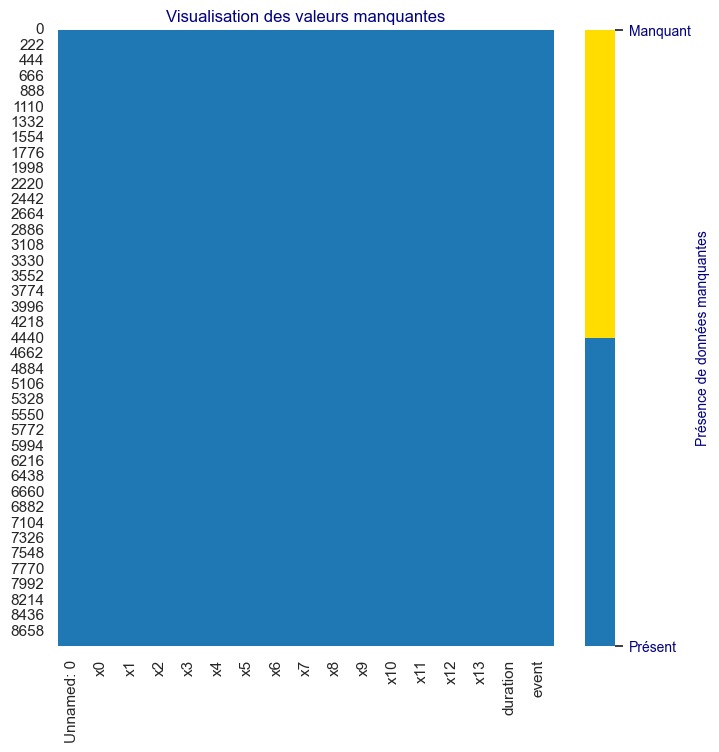

In [431]:
# couleurs
binary_cmap = sns.color_palette(["#1f77b4", "#ffdd00"]) 

# visualisation des valeurs manquantes 
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(DS_support.isnull(), cbar=True, cmap=binary_cmap, vmin=0, vmax=1)

# force la colorbar à n'afficher que deux valeurs : 0 et 1
heatmap.collections[0].colorbar.set_ticks([0, 1])
heatmap.collections[0].colorbar.set_ticklabels(['Présent', 'Manquant'], fontsize=10, color = 'navy')

heatmap.collections[0].colorbar.set_label('Présence de données manquantes', fontsize=10, color = 'navy')

plt.title('Visualisation des valeurs manquantes', fontsize=12, color = 'navy')
plt.show()

In [432]:
# ajuste les options d'affichage de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 
pd.set_option('display.max_rows', None)  

# résumé statistique
print(DS_support.describe())

        Unnamed: 0           x0           x1           x2           x3           x4           x5           x6           x7           x8           x9          x10          x11          x12          x13     duration        event
count  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000
mean   4436.000000    62.627502     0.437056     1.868477     1.249408     0.194185     0.032345     0.937338    84.528739    97.476209    23.355911    37.112211   137.565536    12.354897     1.776328   478.635411     0.680266
std    2561.558803    15.618359     0.496050     1.342225     0.618604     0.395594     0.176925     0.579671    27.824610    31.697252     9.626911     1.255770     6.070577     9.273233     1.694021   560.831587     0.466400
min       0.000000    18.041990     0.000000     0.000000     0.000000     0.000000     0.00

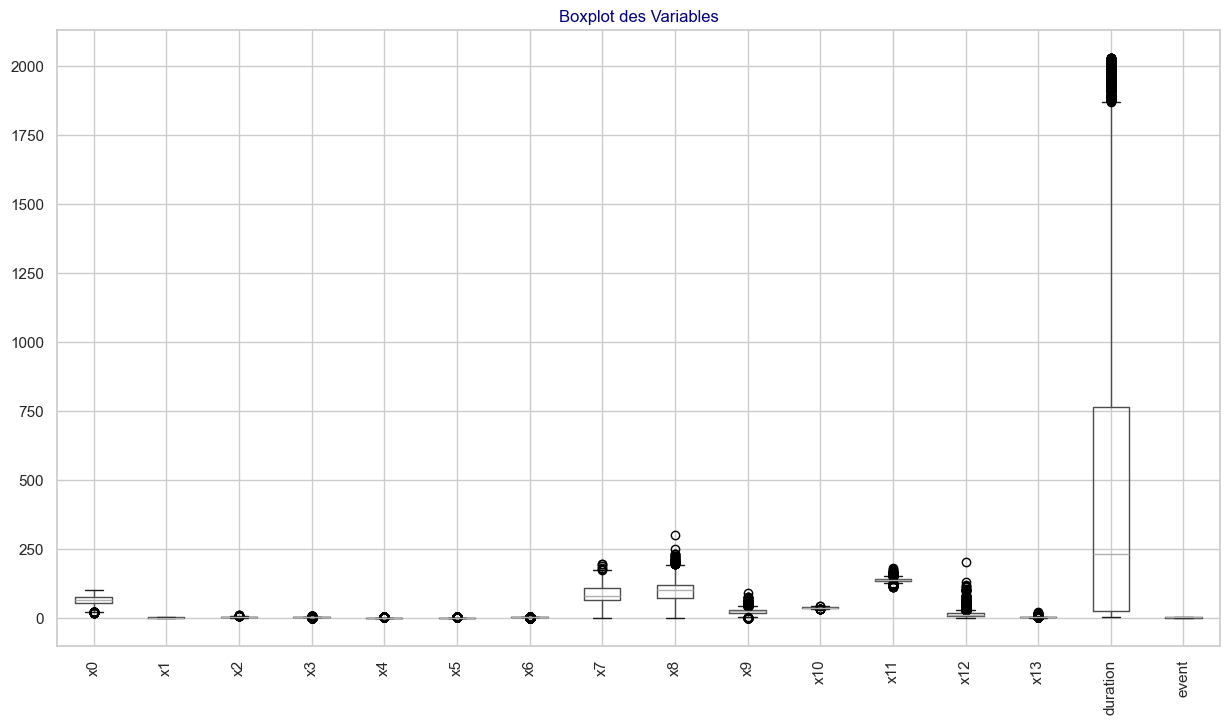

In [433]:
plt.figure(figsize=(15, 8))

# exclus la première colonne en utilisant l'indexation
DS_support.iloc[:, 1:].boxplot(rot=90) 
plt.title('Boxplot des Variables', color='navy')
plt.show()

Ce jeu de données se compose de 8 873 observations et de 14 variables, dont la plupart sont des variables continues. Les variables comprennent des mesures diverses - désignées de « x0 » à « x13 » -, la durée de l'événement et l'indicateur d'événement précisant si celui-ci est survenu durant la période d'observation. Une colonne nommée « Unnamed: 0 » semble avoir été incluse en tant qu'index ou identifiant, mais elle ne semble pas apporter d'informations significatives. Il est donc proposé de ne pas en tenir compte durant les modélisations subséquentes.

L'analyse préliminaire montre l'absence de valeurs manquantes dans le jeu de données, ce qui indique que les analyses subséquentes peuvent être effectuées sans nécessiter de gestion des valeurs manquantes. Elle montre également que l'événement étudié est binaire et ne concerne donc qu'un type d'événement.

Les statistiques descriptives fournissent un aperçu des caractéristiques des variables. Notamment, la variable « duration » varie de 0 à 2 029, avec une moyenne de 137,6 et un écart type de 6,1. Certaines autres variables, comme « x2 » ou « x3 », sont des variables catégorielles ayant plusieurs modalités. Ces informations seront utiles pour les modélisations.

Le boxplot des variables fournit quant à lui une représentation visuelle des distributions et des potentiels outliers dans le jeu de données. On peut observer que la variable « duration », comme relevé ci-dessus, se distingue par une volatilité plus importante, suggérant que le temps d'étude pour chaque observation diffère significativement d'un individu à l'autre. Ceci pourrait impacter le choix du modèle. Certaines des autres variables quantitatives montrent également des valeurs extrêmes qui pourraient nécessiter une attention particulière lors de l'interprétation des résultats.

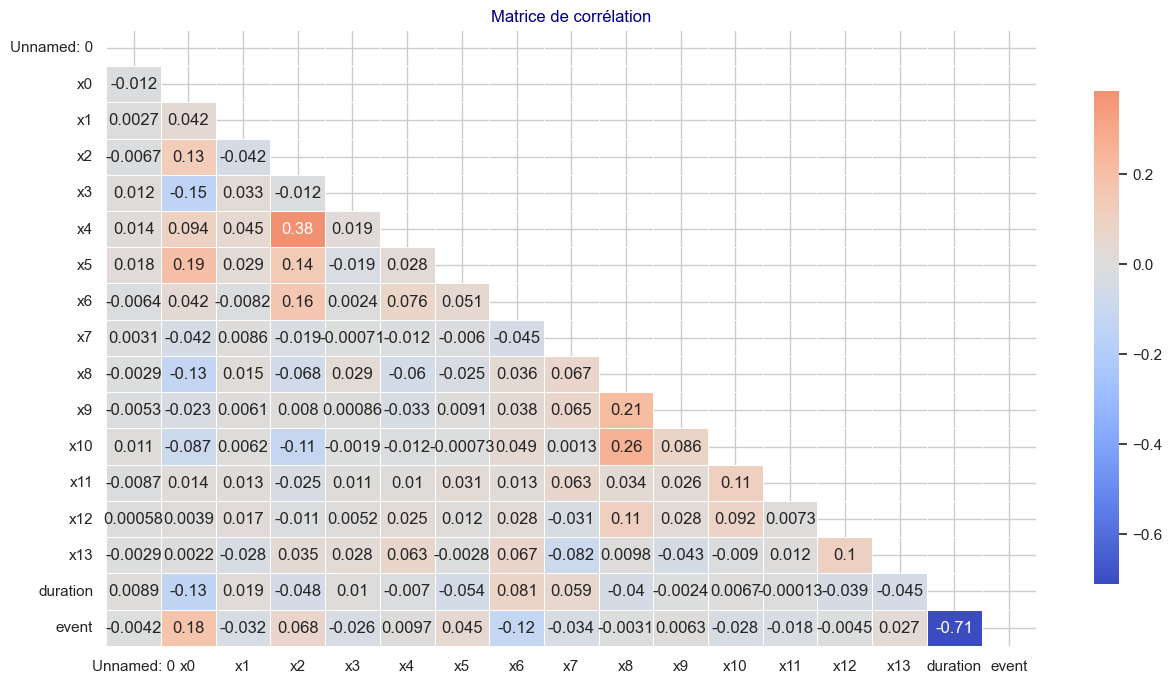

In [434]:
plt.figure(figsize=(15, 8))

# calcul de la matrice de corrélation
corr_matrix = DS_support.corr()

# création d'un masque pour la partie supérieure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# heatmap avec le masque
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, center=0, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matrice de corrélation', color = "navy")
plt.show()

La matrice de corrélation ne montre pas de corrélations très marquées entre les variables, bien que certaines d'entre elles semblent modérément corrélées à la variable duration. Cela suggère que, globalement, la multicolinéarité ne devrait pas influencer de manière majeure. Néanmoins, les corrélations observées peuvent fournir un aperçu préliminaire des relations simples entre les variables et la survie, sans pour autant indiquer directement leur impact réel sur le risque.

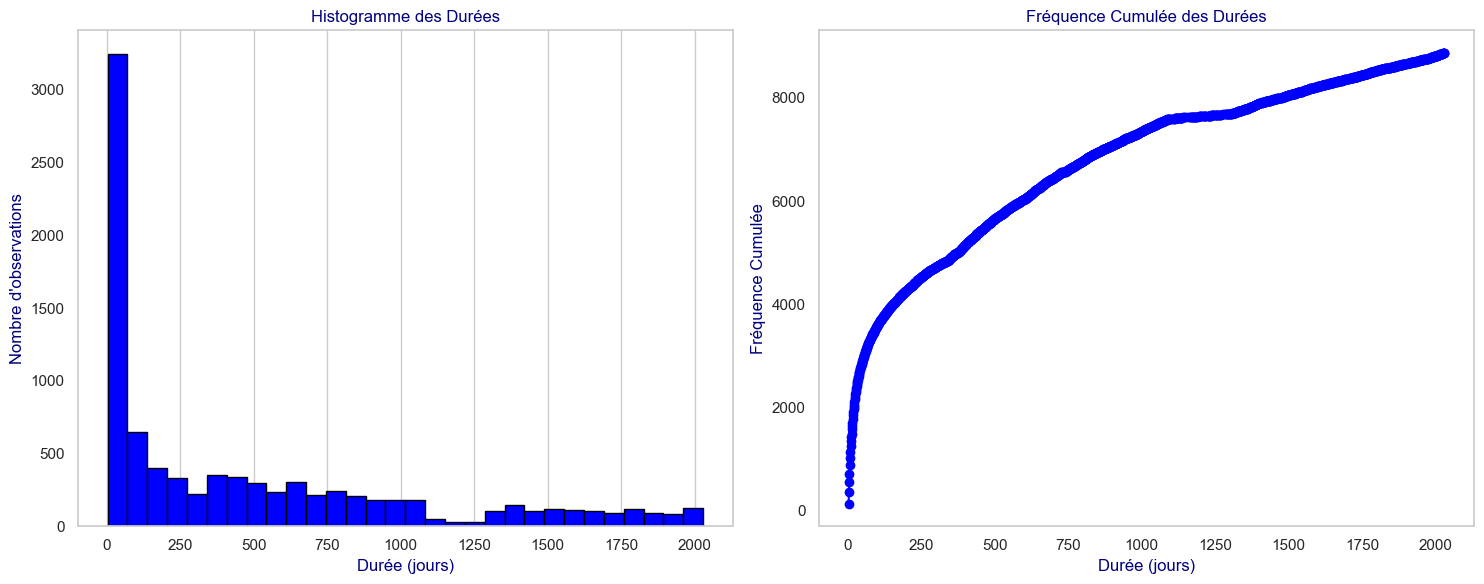

In [435]:
# crée une figure avec deux sous-graphes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) 

# trace l'histogramme de la variable 'duration' 
ax1.hist(DS_support['duration'], bins=30, color='blue', edgecolor='black') 
ax1.set_title('Histogramme des Durées', color = "navy")
ax1.set_xlabel('Durée (jours)', color = "navy")
ax1.set_ylabel('Nombre d\'observations', color = "navy")
ax1.grid(axis='y')

# calcule la fréquence des durées
duration_counts = DS_support['duration'].value_counts().sort_index()

# calcule la fréquence cumulée
cumulative_counts = duration_counts.cumsum()

# trace la courbe cumulative sur le deuxième axe
ax2.plot(cumulative_counts.index, cumulative_counts.values, color='blue', marker='o')
ax2.set_title('Fréquence Cumulée des Durées', color = "navy")
ax2.set_xlabel('Durée (jours)', color = "navy")
ax2.set_ylabel('Fréquence Cumulée', color = "navy")
ax2.grid()

plt.tight_layout()
plt.show()

In [436]:
# vérification de la proportion de données censurées
censures = DS_support['event'].value_counts()
print("Répartition des événements et des censures :")
print(censures)

# proportion
censures_percentage = DS_support['event'].value_counts(normalize=True) * 100
print("\nProportion des événements et des censures en pourcentage :")
print(censures_percentage)

Répartition des événements et des censures :
event
1    6036
0    2837
Name: count, dtype: int64

Proportion des événements et des censures en pourcentage :
event
1    68.026598
0    31.973402
Name: proportion, dtype: float64


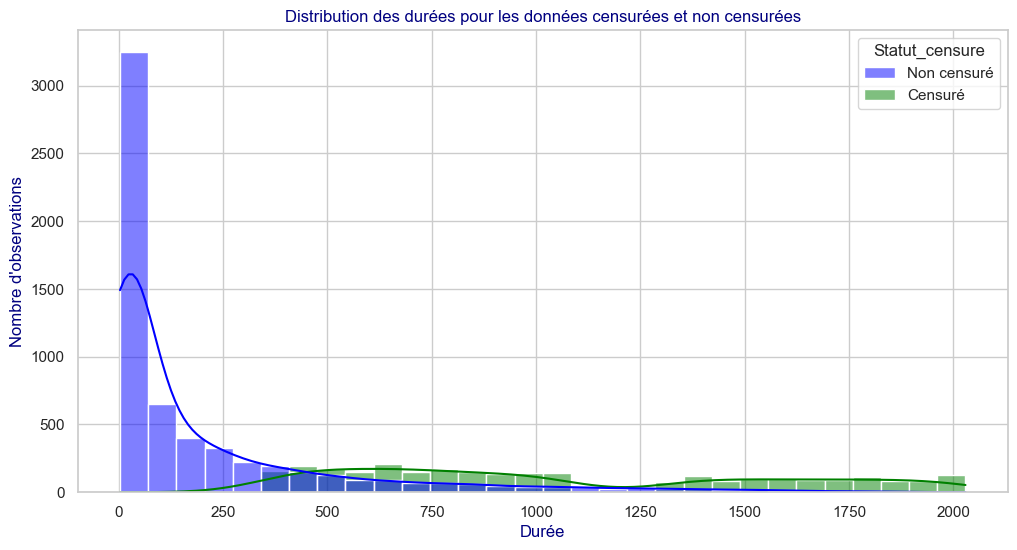

In [437]:
# création d'une colonne pour indiquer le statut de censure
DS_support['Statut_censure'] = DS_support['event'].apply(lambda x: 'Non censuré' if x == 1 else 'Censuré')

# histogramme des durées par statut de censure
plt.figure(figsize=(12, 6))
sns.histplot(data=DS_support, x='duration', hue='Statut_censure', bins=30, kde=True, 
             palette={'Non censuré': 'blue', 'Censuré': 'green'})  
plt.title('Distribution des durées pour les données censurées et non censurées', color = "navy")
plt.xlabel('Durée', color = "navy")
plt.ylabel('Nombre d\'observations', color = "navy")
plt.show()

En matière de répartition globale, le jeu de données contient 6 036 événements survenus, représentant 68,03 % des observations, tandis que 2 837 observations sont censurées. 

Le graphique montre une forte concentration d'événements non censurés au début de la période d'observation, notamment entre 0 et 250 jours. Durant cette période, la majorité des observations aboutissent à un événement, ce qui signifie que les individus (ou systèmes) atteignent l'événement d'intérêt relativement tôt dans la période étudiée. Cette tendance suggère une probabilité élevée que l'événement survienne au début de la période de suivi pour un nombre significatif d'observations.

En revanche, à mesure que la durée de l'observation augmente, le nombre d'événements observés diminue, tandis que la proportion d'observations censurées augmente. Cela est visible à travers une hausse progressive du nombre de censures dans les intervalles de temps plus élevés que 250 jours. Il est probable que certaines observations aient été interrompues avant que l'événement d'intérêt ne puisse se produire, ce qui résulte en des censures.

Les graphiques d'histogramme et de fréquence cumulée illustrent bien cette dynamique. L'histogramme montre que les événements se concentrent principalement sur les premières durées, tandis que la courbe cumulative révèle, notamment, qu'au-delà de 1 500 jours un nombre important d'observations reste non observé. Une autre observation notable concerne la longue queue des censures qui se prolonge jusqu'à environ 2 000 jours. Cette situation indique que certaines observations ont été suivies sur une période prolongée sans que l'événement ne survienne.

Les censures observées sur ces longues durées suggèrent que ces individus (ou systèmes) n'ont pas encore atteint l'événement d'intérêt à la fin de la période d'observation. Ceci impactera probablement les modélisations subséquentes, car une forte proportion de censures est susceptible de réduire la précision des estimations du temps moyen jusqu'à l'événement.

### I.b. Stratégies de modélisation pour les données censurées

#### I.b.1. Par un modèle de Kaplan - Meier

Cette méthode est une approche non paramétrique utilisée pour estimer la fonction de survie à partir de données censurées. Elle permet donc d'estimer la probabilité qu'un individu survive au-delà d'un certain temps, en tenant compte des événements censurés, tels que les observations qui ne se sont pas terminées par un événement d'intérêt - comme un décès ou une défaillance. Elle génère, entre autres, une courbe de survie, offrant une visualisation intuitive des probabilités de survie au fil du temps.

Mathématiquement, la fonction de survie $S(t)$ est définie comme la probabilité qu'un individu survive au-delà du temps $t$. Le calcul se fait en multipliant la probabilité de survie - soit le complémentaire à la probabilité de survenance - à chaque instant de temps où un événement se produit. La formule de Kaplan-Meier est ainsi donnée par :


$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$


- $t_i$ est le temps de l'événement pour l'individu $𝑖$ qui a expérimenté l'événement,
- $d_i$ est le nombre d'individus ayant expérimenté l'événement à $t_i$,
- $n_i$ est le nombre d'individus restants à risque à $t_i$.

Au cœur de cette approche se trouve le concept de taux de risque instantané $\lambda(t)$, qui représente la probabilité qu'un événement survienne dans le prochain intervalle de temps $dt$, étant donné qu'il ne s'est pas encore produit avant $t$. Ce taux de risque est étroitement lié à la fonction de survie $S(t)$ et à la fonction de risque cumulative $\Lambda(t)$, définie comme l'intégrale du taux de risque sur le temps :$\Lambda(t) = \int_0^t \lambda(u) \, du$.


Ces trois fonctions sont reliées par les relations suivantes :

- La fonction de survie, fondée sur une équation différentielle qui lie la fonction de survie au taux de risque instantané, peut être exprimée en fonction de la fonction de risque cumulative : $S(t) = e^{-\Lambda(t)}$.

- La fonction de risque instantané $\lambda(t)$ peut être obtenue en prenant la dérivée de la fonction de risque cumulative $\Lambda(t)$ par rapport au temps : $\lambda(t) = \frac{d\Lambda(t)}{dt} = -\frac{dS(t)}{dt} \cdot \frac{1}{S(t)}$. Cette relation illustre comment le taux de risque est connecté à la dynamique de la fonction de survie.

Ces relations permettent de mieux comprendre la dynamique des événements dans le cadre d'une analyse de survie en établissant des liens essentiels entre ces notions. En particulier, le taux de risque donne une indication sur la « vitesse » à laquelle les événements se produisent, tandis que la fonction cumulative aide à relier le risque total accumulé au fil du temps à la fonction de survie. En d'autres termes, une augmentation du taux de risque indique une diminution de la probabilité de survie. Cependant, il est important de noter que l'estimation par la méthode Kaplan - Meier s'effectue de manière globale par pas de temps et ne dépend pas des observations $x_i$. De plus, elle ne tient pas compte des covariables, ce qui limite la capacité à déduire des informations plus spécifiques sur l'impact de ces facteurs.

In [438]:
# crée une liste pour stocker les résultats
results_list = []

# statistiques en ignorant les données censurées
naive_stats_1 = DS_support.query("event == 1")["duration"].agg(["mean", "median"])
results_list.append({"Méthode": "Méthode biaisée 1 (données non censurées)", 
                     "Moyenne (jours)": naive_stats_1['mean'], 
                     "Médiane (jours)": naive_stats_1['median']})

# durée maximale observée dans le jeu de données
max_duration = DS_support["duration"].max()

# remplace les durées censurées par la durée maximale
naive_stats_2 = pd.Series(
    np.where(DS_support["event"], DS_support["duration"], max_duration)
).agg(["mean", "median"])

results_list.append({"Méthode": "Méthode biaisée 2 (censures à la fin)", 
                     "Moyenne (jours)": naive_stats_2['mean'], 
                     "Médiane (jours)": naive_stats_2['median']})

# ajuste le modèle Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(durations=DS_support['duration'], event_observed=DS_support['event'])

# médiane de la survie
median_survival_time = kmf.median_survival_time_

#  moyenne de la survie 
time_points = kmf.survival_function_.index
survival_probabilities = kmf.survival_function_['KM_estimate']
mean_survival_time = np.trapz(survival_probabilities, time_points)

# ajoute les résultats de Kaplan-Meier
results_list.append({"Méthode": "Estimation Kaplan-Meier", 
                     "Moyenne (jours)": mean_survival_time, 
                     "Médiane (jours)": median_survival_time})

# crée un DataFrame à partir de la liste de résultats
results = pd.DataFrame(results_list)

print(tabulate(results, headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".2f"))

╒═══════════════════════════════════════════╤═══════════════════╤═══════════════════╕
│ Méthode                                   │   Moyenne (jours) │   Médiane (jours) │
╞═══════════════════════════════════════════╪═══════════════════╪═══════════════════╡
│ Méthode biaisée 1 (données non censurées) │            205.45 │             57.00 │
├───────────────────────────────────────────┼───────────────────┼───────────────────┤
│ Méthode biaisée 2 (censures à la fin)     │            788.50 │            231.00 │
├───────────────────────────────────────────┼───────────────────┼───────────────────┤
│ Estimation Kaplan-Meier                   │            725.35 │            231.00 │
╘═══════════════════════════════════════════╧═══════════════════╧═══════════════════╛


Une première observation significative est déduite des résultats présentés ci-dessus : les méthodes biaisées fournissent des estimations de la durée de survie qui varient considérablement. La première méthode tend à sous-estimer la durée de survie, tandis que la deuxième méthode produit des estimations beaucoup plus élevées, potentiellement trompeuses. Ces biais sont causés par la manière dont les données censurées sont traitées. La première méthode, en ignorant complètement les observations censurées, ne tient pas compte des individus qui n'ont pas atteint l'événement d'intérêt, ce qui conduit à une sous-estimation de la survie. En revanche, la deuxième méthode, en remplaçant les durées censurées par la durée maximale observée, peut fausser les résultats en attribuant une durée de survie irréaliste à ces cas, masquant ainsi la véritable distribution des temps de survie.

En revanche, l'estimation de Kaplan-Meier, qui tient compte des événements censurés de manière appropriée, fournit des résultats plus réalistes et robustes. La médiane de survie estimée par Kaplan-Meier est identique à celle de la méthode biaisée n° 2, mais avec une moyenne significativement plus basse, indiquant une approche plus nuancée et précise dans l'évaluation de la survie.

La proximité apparente des résultats entre la seconde méthode et l'estimation par Kaplan-Meier dans ce cas spécifique semble découler de la structure des données, où, comme nous l'avons vu précédemment, une proportion significative des observations se termine par un événement au début de la période d'étude. Cela pourrait donner l'illusion que la méthode biaisée n° 2 est valide, alors qu'en réalité, elle masque la dynamique réelle des événements et pourrait induire en erreur si appliquée à des données avec une distribution différente.

Ces résultats illustrent que l'utilisation de méthodes alternatives plus sophistiquées, comme la méthode de Kaplan-Meier, est donc fondamentale pour obtenir des estimations de survie fiables, car elle intègre les données censurées sans compromettre l'intégrité des résultats.

In [396]:
# Vérifie que "duration" et "event" existent dans DS_support
if 'duration' not in DS_support.columns or 'event' not in DS_support.columns:
    raise ValueError("Les colonnes 'duration' et 'event' doivent être présentes dans DS_support.")

# initialise le Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# ajuste le modèle Kaplan-Meier
kmf.fit(durations=DS_support['duration'], event_observed=DS_support['event'])

# récupére les probabilités de survie
km_survival_probabilities = kmf.survival_function_.values.flatten()
times = kmf.survival_function_.index

# calcule la fonction de distribution cumulative F(t)
cumulative_distribution = 1 - km_survival_probabilities

# calcule la fonction de risque cumulative H(t)
cumulative_risk = -np.log(km_survival_probabilities)  # H(t) = -log(S(t))

# crée une figure avec 3 sous-graphiques côte à côte
fig = make_subplots(rows=1, cols=3, subplot_titles=("Courbe de survie de Kaplan-Meier", "Fonction de Risque Cumulative", "Fonction de Distribution Cumulative"))

# courbe de survie Kaplan-Meier
fig.add_trace(go.Scatter(x=times, y=km_survival_probabilities, mode='lines', name='Kaplan-Meier', line=dict(color='blue')), row=1, col=1)
fig.add_hline(y=0.5, line_dash="dash", line_color="red", annotation_text="Médiane", annotation_position="top right", row=1, col=1)

# courbe de la fonction de risque cumulative
fig.add_trace(go.Scatter(x=times, y=cumulative_risk, mode='lines', name='Fonction de Risque Cumulative', line=dict(color='orange')), row=1, col=2)

# courbe de la fonction de distribution cumulative
fig.add_trace(go.Scatter(x=times, y=cumulative_distribution, mode='lines', name='Fonction de Distribution Cumulative', line=dict(color='purple')), row=1, col=3)

# personnalise la mise en page
fig.update_layout(
    height=500,
    width=1200,
    title=dict(
        text="Analyse de Survie",
        font=dict(color='navy'),  
        xanchor='center',  
        x=0.5  
    ),
    yaxis_title=dict(
        text="Proportion de survie",
        font=dict(color='navy') 
    ),
    yaxis_range=[0, 1],
)

# centre l'axe des x
fig.update_xaxes(
    title=dict(
        text="Temps (jours)",
        font=dict(color='navy')
    )
)

fig.show()

# affiche la médiane de survie
median_survival_time = kmf.median_survival_time_
print(f"Médiane de survie : {median_survival_time} jours")

Médiane de survie : 231.0 jours


Le graphique indique une diminution progressive de la probabilité de survie, avec une médiane de survie estimée à 230,8 jours. Cette diminution reflète les événements qui surviennent dans la population étudiée, illustrant ainsi la dynamique des risques.

Comme évoqué supra, cette courbe de survie est intrinsèquement liée au taux d'incidence, qui représente la « vitesse » à laquelle les événements se produisent. Dans le cas étudié, une augmentation du taux d'incidence entraîne une diminution plus rapide de la courbe de survie, ce qui signifie qu'une plus grande proportion d'individus subit des événements au cours d'un intervalle de temps donné, ce qui apparaît cohérent avec la distribution des évènements non censurés observée supra.

La courbe de risque cumulative, représentée à droite, illustre comment le risque total s'accumule au fil du temps, en opposition à la courbe de survie qui montre la probabilité de survie à chaque instant. Lorsque la courbe de survie descend rapidement, cela correspond à une augmentation simultanée de la fonction de risque cumulative, indiquant que les événements surviennent à un rythme plus soutenu. En revanche, si la courbe de survie se stabilise ou diminue lentement, cela peut suggérer que le taux d'incidence est relativement faible à ce moment-là, ce qui se traduit par un risque cumulé moins important. Ainsi, l'interaction entre ces deux courbes illustre la dynamique des événements évoquée précédemment de manière plus approfondie, en reliant la probabilité de survie à l'accumulation du risque dans le temps.

La fonction de distribution cumulative, illustrée dans le troisième graphique, indique la probabilité qu'un individu ait subi l'événement d'intérêt au plus tard à un certain temps $𝑡$. Elle est étroitement liée à la fonction de survie, puisque $F(t)=1−S(t)$. Ainsi, l'interaction entre ces trois courbes offre une vue d'ensemble complète de la dynamique des événements. Cette représentation approfondie relie la probabilité de survie à l'accumulation du risque dans le temps et à la distribution des événements au sein de la population étudiée.

In [397]:
def calculate_global_indicators(df, time_points):
    # calcule les estimations de Kaplan-Meier pour l'ensemble du jeu de données
    x, y = kaplan_meier_estimator(
        df["event"].astype(bool),  
        df["duration"]              
    )

    # calcul de la fonction de distribution cumulative F(t)
    cumulative_distribution = 1 - y

    # stocke les résultats de survie et d'incidence
    survival_results = []
    
    # calcul des indicateurs
    for t in time_points:
        # probabilité de survie à t
        prob_survival_at_t = y[x == t].item() if t in x else None
        
        # taux d'incidence à t
        index_t = list(x).index(t) if t in x else -1
        if index_t != -1:
            num_events_at_t = df[df["duration"] <= t]["event"].sum()
            num_at_risk = len(df) * prob_survival_at_t
            incidence_rate_at_t = num_events_at_t / num_at_risk if num_at_risk > 0 else 0
        else:
            incidence_rate_at_t = None
        
        # ajoute les résultats au tableau
        survival_results.append((t, prob_survival_at_t, incidence_rate_at_t))

    # médiane de survie
    median_survival_time = compute_median_survival_time_with_interp1d(x, y)
    
    # calcul des quantiles de survie et de la fonction de distribution cumulative
    quantiles_km = [0.25, 0.5, 0.75]
    predicted_quantiles_km = {}
    for q in quantiles_km:
        quantile_time = interp1d(y, x, bounds_error=False)(q)
        predicted_quantiles_km[q] = quantile_time

    quantiles_fd = [0.25, 0.5, 0.75]
    predicted_quantiles_fd = {}
    for q in quantiles_fd:
        quantile_time_fd = interp1d(cumulative_distribution, x, bounds_error=False)(q)
        predicted_quantiles_fd[q] = quantile_time_fd
    
    return survival_results, predicted_quantiles_km, predicted_quantiles_fd, median_survival_time

def compute_median_survival_time_with_interp1d(times, survival_probabilities):
    """Get the time to a survival proba of 50% via linear interpolation."""
    reverse_survival_func = interp1d(survival_probabilities, times, kind="linear", bounds_error=False, fill_value=(0, 0))
    return reverse_survival_func([0.5])[0].round(decimals=1)

def display_results(survival_results, predicted_quantiles_km, predicted_quantiles_fd):
    # crée un DataFrame avec les résultats de survie et d'incidence
    survival_df = pd.DataFrame(survival_results, columns=["Temps (jours)", "Probabilité de survie", "Taux d'incidence"])

    # crée un DataFrame pour les quantiles sans la colonne "Temps correspondant"
    quantiles_data = {
        "Quantiles": ["Kaplan-Meier 25%", "Kaplan-Meier 50%", "Kaplan-Meier 75%", 
                      "Distribution cumulative 25%", "Distribution cumulative 50%", "Distribution cumulative 75%"],
        "Prédiction (jours)": [
            predicted_quantiles_km[0.25], predicted_quantiles_km[0.5], predicted_quantiles_km[0.75],
            predicted_quantiles_fd[0.25], predicted_quantiles_fd[0.5], predicted_quantiles_fd[0.75]
        ],
        "Observé (jours)": [26.0, 231.0, 763.0, 25.1, 230.8, 1788.2]  # Remplacez ces valeurs par les valeurs observées si disponibles
    }

    # crée les DataFrames
    df_survival = survival_df
    df_quantiles = pd.DataFrame(quantiles_data)

    # affiche les résultats en utilisant tabulate
    print("Résultats de Survie:")
    print(tabulate(df_survival, headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".2f"))

    print("\nQuantiles:")
    print(tabulate(df_quantiles, headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".2f"))

# appelle la fonction avec le jeu de données 
time_points = [100, 250, 500, 1000]
survival_results, predicted_quantiles_km, predicted_quantiles_fd, median_survival_time = calculate_global_indicators(DS_support, time_points)


display_results(survival_results, predicted_quantiles_km, predicted_quantiles_fd)

Résultats de Survie:
╒═════════════════╤═════════════════════════╤════════════════════╕
│   Temps (jours) │   Probabilité de survie │   Taux d'incidence │
╞═════════════════╪═════════════════════════╪════════════════════╡
│          100.00 │                    0.60 │               0.68 │
├─────────────────┼─────────────────────────┼────────────────────┤
│          250.00 │                    0.49 │               1.04 │
├─────────────────┼─────────────────────────┼────────────────────┤
│          500.00 │                    0.41 │               1.45 │
├─────────────────┼─────────────────────────┼────────────────────┤
│         1000.00 │                    0.33 │               1.99 │
╘═════════════════╧═════════════════════════╧════════════════════╛

Quantiles:
╒═════════════════════════════╤══════════════════════╤═══════════════════╕
│ Quantiles                   │   Prédiction (jours) │   Observé (jours) │
╞═════════════════════════════╪══════════════════════╪═══════════════════╡
│ Kap

Les résultats des probabilités de survie et des taux d'incidence à différents moments de l'étude fournissent des informations complémentaires sur la dynamique des événements dans la population étudiée. À 100 jours, la probabilité de survie est de 60 %, avec un taux d'incidence de 0,68, indiquant qu'une proportion significative des individus a survécu jusqu'à ce moment, mais le taux d'incidence suggère que des événements se produisent à un rythme relativement modéré.

À 250 jours, la probabilité de survie diminue à 49 %, tandis que le taux d'incidence augmente à 1,04, ce qui indique une accélération des événements dans la population. Cette tendance se renforce à 500 jours, où la probabilité de survie tombe à 41 % et le taux d'incidence monte à 1,45, révélant une fréquence croissante des événements.

À 1 000 jours, la situation se détériore davantage, avec une probabilité de survie réduite à 33 % et un taux d'incidence de 1,99. Cette dynamique est en cohérence avec la courbe de survie de Kaplan-Meier, qui montre une diminution continue de la survie au fil du temps. Notons également que cette dynamique, où le nombre d'individus censurés dépasse le nombre d'événements au-delà de 1 000 jours, suggère que les individus restants dans l'étude ont des caractéristiques de survie plus favorables - comme, potentiellement, un traitement médical efficace, des conditions de vie favorables, etc. -, ou possèdent, là encore potentiellement, des caractéristiques différentes de ceux qui subissent l’événement.

La comparaison entre les quantiles prédits par la fonction de distribution cumulative, qui mesure la proportion d'individus ayant subi l'événement au fil du temps, et les valeurs observées montre des résultats très proches pour le quantile à 25 % et la médiane. En revanche, une divergence notable se manifeste pour le quantile à 75 %, probablement due à la répartition des données censurées qui devient prédominante après environ le 1 000e jour de l'étude. Cette différence souligne l'importance d'interpréter les résultats des modèles avec précaution, surtout dans des contextes où les données sont fortement censurées.

In [439]:
def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    # divise les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    
    # assure que les durées du test sont dans la plage des durées de l'entraînement
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    
    # applique le masque aux ensembles d'entraînement et de test
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    
    return X_train, X_test, y_train, y_test, idx_train, idx_test

# exclus uniquement certaines colonnes
X = DS_support.drop(columns=["Unnamed: 0", "Statut_censure"])
y = DS_support[["duration", "event"]]

# applique la fonction train_test_split_within
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

In [440]:
# applique l'estimateur de Kaplan-Meier
km_times_train, km_survival_curve_train = kaplan_meier_estimator(
    y_train["event"].astype(bool),  
    y_train["duration"])

In [441]:
# crée une fonction d'interpolation à partir des courbes de survie de Kaplan-Meier
km_predict = interp1d(
    km_times_train,
    km_survival_curve_train,
    kind="previous",
    bounds_error=False,
    fill_value="extrapolate",
)


def make_test_time_grid(y_train, n_steps=300):
    """Bound times to the range of duration."""
    # sélectionne les durées observées pour les événements (non censurés) dans le jeu de test
    observed_duration = y_test.query("event > 0")["duration"]
    
    # génère une grille de temps uniformément espacée dans l'intervalle défini
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span
    stop = observed_duration.max() - 0.005 * span
    return np.linspace(start, stop, num=n_steps)


time_grid = make_test_time_grid(y_train)

In [442]:
# prédit la courbe de survie à l'aide du modèle de kaplan-meier pour chaque point dans le grille de temps
km_curve = km_predict(time_grid)

# création d'une matrice de prédictions de survie
y_pred_km_test = np.vstack([km_curve] * X_test.shape[0])

In [443]:
def as_sksurv_recarray(y_frame):
    """convertir un dataframe de survie en un format spécifique pour la bibliothèque scikit-survival."""
    
    # création d'un tableau vide avec le format attendu : un booléen pour l'événement et un float pour la durée
    y_recarray = np.empty(
        shape=y_frame.shape[0],
        dtype=[("event", np.bool_), ("duration", np.float64)],
    )
    
    # remplit la colonne "event" avec les valeurs de la colonne "event" du dataframe d'entrée
    y_recarray["event"] = y_frame["event"]
    
    # remplit la colonne "duration" avec les valeurs de la colonne "duration" du dataframe d'entrée
    y_recarray["duration"] = y_frame["duration"]
    
    # retourne le tableau au format recarray compatible avec scikit-survival
    return y_recarray

# calcul des brier scores pour la courbe de kaplan-meier
_, km_brier_scores = brier_score(
    survival_train=as_sksurv_recarray(y_train),  
    survival_test=as_sksurv_recarray(y_test),    
    estimate=y_pred_km_test,                    
    times=time_grid,                           
)

Afin d'estimer la qualité des estimations, nous retiendrons deux métriques d'erreurs dans la suite de nos analyses : le Brier Score et le C-index.

1. Le Brier Score :

Il s'agit d'une mesure utilisée pour évaluer la précision des prédictions probabilistes, en particulier dans le cadre de la modélisation des temps de survie. Il est particulièrement pertinent dans les analyses où les résultats sont binaires, tels que la survie ou la non-survie d'un individu à un moment donné. Il est défini comme la moyenne des erreurs quadratiques entre les probabilités prédites et les résultats observés. Mathématiquement, il est formulé comme suit : $Brier\ Score = \frac{1}{N} \sum_{i=1}^{N} (f_i - o_i)^2$, où :
- $N$ est le nombre total d'observations.
- $f_i$ est la probabilité prédite que l'événement se produise (par exemple, la probabilité de survie).
- $o_i$ est la variable binaire observée, qui vaut 1 si l'événement s'est produit et 0 sinon.

Le Brier Score varie entre 0 et 1, où :
- 0 indique une prévision parfaite, donc toutes les prévisions sont exactes.
- 1 signifie une prévision complètement incorrecte. 

En conséquence, des valeurs plus basses du Brier Score indiquent une meilleure précision des prédictions.

Plus spécifiquement pour les données de survie, le Brier Score peut être ajusté pour tenir compte des observations censurées. Dans ce contexte, le Brier Score est formulé comme suit : $$\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(d_i \leq t \land \delta_i = 1)
        \frac{(0 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(d_i)} + I(d_i > t)
        \frac{(1 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(t)}$$, où:
- $𝑑𝑖$ représente le temps jusqu'à l'événement pour l'individu $𝑖$, 
- $𝛿𝑖$ indique si l'événement a été observé (1) ou censuré (0), 
- $\hat{S}(t | \mathbf{x}_i)$ est la probabilité de survie estimée au temps $𝑡$ pour l'individu $i$,
- $\hat{G}(d_i)$ représente la probabilité que l'individu $i$ soit observé jusqu'au moment $d_i$ sans être censuré, estimée par la méthode de Kaplan-Meier appliquée aux données de censure,
- $\hat{G}(t)$ représente la probabilité générale de non-censure pour l'ensemble des individus jusqu'au temps $t$, obtenue via l'estimateur de Kaplan-Meier et évaluée pour toutes les observations.

Le Brier Score peut être calculé à des moments spécifiques pour évaluer la performance d'un modèle au fil du temps. Étant donné qu'il s'agit d'une mesure quadratique, le Brier Score évite les compensations entre erreurs positives et négatives, tout en donnant un poids plus important aux erreurs plus significatives, rendant ainsi les prédictions inexactes plus visibles. Cela permet de comparer la performance de différents modèles de prédiction. Néanmoins, il est important de noter que le Brier Score ne prend pas en compte les effets de temps dans les prédictions, ce qui peut limiter les conclusions de son analyse. En particulier, deux modèles pourraient avoir le même Brier Score tout en présentant des performances très différentes selon le moment où les événements se produisent.

Les pondérations $\hat{G}(d_i)$ et $\hat{G}(t)$ jouent un rôle important dans ce calcul car elles ajustent la contribution de chaque observation selon le nombre d'individus à risque aux moments spécifiés. Ces pondérations corrigent l'influence des observations censurées, reflétant leur caractère incomplet. Sans pondération, les individus censurés seraient considérés comme équivalents aux observations complètes, ce qui introduirait un biais dans l’évaluation du modèle. Concrètement, si un individu a une faible probabilité d'être censuré à un temps donné $t$ - par exemple, beaucoup d'autres individus ont été observés sans censure-, sa contribution à l'erreur est renforcée, et inversement.

Il est possible de déduire du Brier Score l'*Integrated Brier Score (IBS)* afin de résumer la courbe du Brier Score à une valeur et comparer la qualité de différents estimateurs de la courbe de survie sur le même ensemble de test, grâce à l'intégration suivante : $IBS = \frac{1}{t_{max} - t_{min}}\int^{t_{max}}_{t_{min}} BS(t) dt$.

Dans le contexte des courbes de survie, le Brier Score peut être utilisé pour évaluer à quel point les probabilités de survie prédites par le modèle correspondent aux résultats réels observés. Néanmoins, il est important de noter que le Brier Score ne prend pas en compte les effets de temps dans les prédictions, ce qui peut limiter les conclusions de son analyse. En particulier, deux modèles pourraient avoir le même Brier Score tout en présentant des performances très différentes selon le moment où les événements se produisent.
 

2. Le C-index 

Il est défini comme la proportion de paires d'individus pour lesquelles le modèle prédit correctement quel individu subira l'événement en premier. Mathématiquement, il est exprimé comme suit :

$$
C = \frac{n_{concordants}}{n_{concordants} + n_{discordants}}
$$

où :
- $n_{concordants}$ est le nombre de paires d'individus pour lesquelles le modèle a correctement prédit l'ordre des événements.
- $n_{discordants}$ est le nombre de paires pour lesquelles le modèle a prédit un ordre incorrect.

Le C-index varie entre 0 et 1 :
- 1 indique une concordance parfaite, c'est-à-dire que le modèle prédit toujours correctement quel individu subira l'événement en premier.
- 0.5 indique une performance équivalente au hasard, suggérant que le modèle n'est pas meilleur que la chance.
- 0 indique une discordance totale, où le modèle prédit toujours l'ordre incorrect.

Le C-index est particulièrement utile dans les modèles de survie où l'on cherche à comprendre non seulement si un événement se produira, mais aussi quand il se produira. Il présente l'avantage de ne pas être influencé par les censures dans les données, car il ne dépend que de l'ordre des événements observés. Cela en fait une métrique robuste dans les contextes où les données censurées sont fréquentes.

Cependant, il convient de noter que le c-index ne fournit pas d'informations sur la magnitude des différences de temps jusqu'à l'événement ; il ne fait que mesurer si le modèle prédit correctement l'ordre. Par conséquent, il est souvent utilisé en complément d'autres mesures, comme le Brier Score, pour obtenir une évaluation complète des performances du modèle.


In [444]:
from sksurv.metrics import integrated_brier_score

# calcul de l'IBS pour le modèle de Kaplan-Meie
km_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)

# créer une courbe de survie linéaire pour le test
linear_survival_curve = np.linspace(1.0, 0.0, time_grid.shape[0])
constant_linear_survival_curves = [linear_survival_curve] * y_test.shape[0]

# calcul de l'IBS pour la courbe de survie linéaire constante
linear_survival_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=constant_linear_survival_curves,
    times=time_grid,
)

In [445]:
from sksurv.metrics import concordance_index_censored

# assure la cohérence de la structure avant calcul
def compute_c_index(event, duration, survival_curves):
    survival_curves = np.asarray(survival_curves)
    if survival_curves.ndim != 2:
        raise ValueError(
            "`survival_probs` must be a 2d array of "
            f"shape (n_samples, times), got {survival_curves.shape}"
        )
    assert event.shape[0] == duration.shape[0], survival_curves.shape[0]

    # calcul du risque cumulatif à partir des courbes de survie.
    cumulative_hazard = survival_to_risk_estimate(survival_curves)
    metrics = concordance_index_censored(event, duration, cumulative_hazard)
    return metrics[0]

# calcul du risque cumulatif
def survival_to_risk_estimate(survival_probs_matrix):
    return -np.log(survival_probs_matrix + 1e-8).sum(axis=1)

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.2844,0.5,1036.1,686.1,459.3
1,Kaplan-Meier,0.2250,0.5,1282.4,426.5,461.9


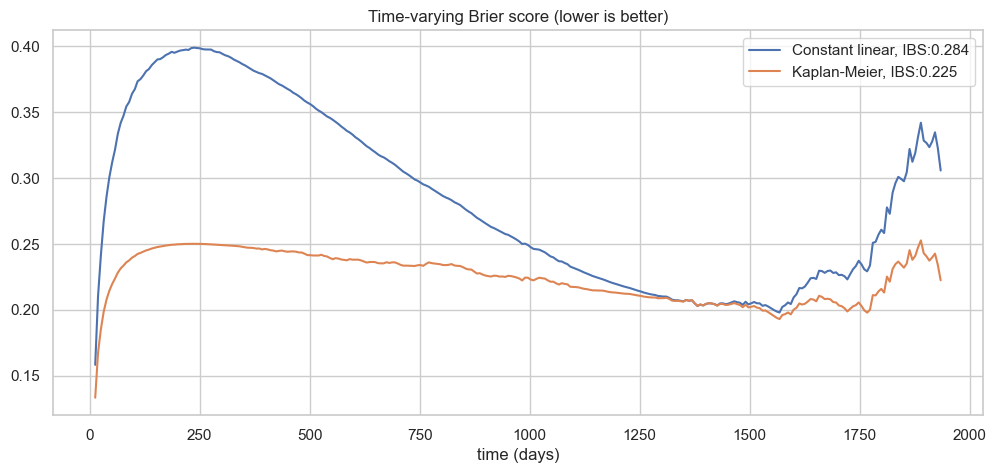

In [446]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score, integrated_brier_score
from scipy.interpolate import interp1d

# fonction pour calculer les temps de survie pour un quantile donné
def quantile_survival_times(times, survival_curves, q=0.5):
    increasing_survival_curves = survival_curves[:, ::-1]
    median_indices = np.apply_along_axis(
        lambda a: a.searchsorted(q), axis=1, arr=increasing_survival_curves
    )
    return times[-median_indices]

# classe pour évaluer les modèles de survie avec différentes métriques et quantiles
class SurvivalAnalysisEvaluator:
    
    def __init__(self, y_train, y_test, time_grid):
        self.model_data = {}
        self.y_train = as_sksurv_recarray(y_train)
        self.y_test = as_sksurv_recarray(y_test)
        self.time_grid = time_grid
    # ajoute un modèle et calcule les métriques de survie pour ce modèle    
    def add_model(self, model_name, survival_curves):
        survival_curves = np.asarray(survival_curves)
        _, brier_scores = brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        ibs = integrated_brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        c_index = compute_c_index(
            self.y_test["event"],
            self.y_test["duration"],
            survival_curves,
        )
        
        # calcul des erreurs absolues moyennes pour les quantiles spécifiés
        quantile_metrics = {}
        for q in [0.25, 0.5, 0.75]:
            y_pred = quantile_survival_times(self.time_grid, survival_curves, q=q)
            mae = mean_absolute_error(self.y_test["duration"], y_pred)
            quantile_metrics[f"MAE for q={np.round(q, 2)}"] = mae.round(1)
        # stocke les données du modèle dans le dictionnaire
        self.model_data[model_name] = {
            "brier_scores": brier_scores,
            "ibs": ibs,
            "c_index": c_index,
            "survival_curves": survival_curves,
            **quantile_metrics
        }
    # affiche les métriques sous forme de tableau
    def metrics_table(self):
        return pd.DataFrame([
            {
                "Model": model_name,
                "IBS": info["ibs"],
                "C-index": info["c_index"],
                **{k: v for k, v in info.items() if k.startswith("MAE for q=")}
            }
            for model_name, info in self.model_data.items()
        ]).round(decimals=4)
    # trace les scores de brier pour les modèles ajouté
    def plot(self, model_names=None):
        if model_names is None:
            model_names = list(self.model_data.keys())
        fig, ax = plt.subplots(figsize=(12, 5))
        self._plot_brier_scores(model_names, ax=ax)

    def _plot_brier_scores(self, model_names, ax):
        for model_name in model_names:
            info = self.model_data[model_name]
            ax.plot(
                self.time_grid,
                info["brier_scores"],
                label=f"{model_name}, IBS:{info['ibs']:.3f}");
        ax.set(
            title="Time-varying Brier score (lower is better)",
            xlabel="time (days)",
        )
        ax.legend()
        
    def __call__(self, model_name, survival_curves, model_names=None):
        self.add_model(model_name, survival_curves)
        self.plot(model_names=model_names)
        return self.metrics_table()

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator.add_model("Constant linear", constant_linear_survival_curves)
evaluator.add_model("Kaplan-Meier", y_pred_km_test)
evaluator.plot()
evaluator.metrics_table()

Les résultats présentés ci-dessus illustrent l'évolution du Brier Score dans le temps ainsi que le C-index pour deux modèles de survie portant sur le jeu de données étudié : un modèle linéaire constant et le modèle Kaplan-Meier.

Le modèle Kaplan-Meier démontre une performance supérieure par rapport au modèle linéaire constant, avec un Brier Score plus bas à travers la plupart des intervalles de temps et globalement. Cela suggère que le modèle Kaplan-Meier est plus efficace pour prédire les probabilités de survie à différentes étapes de l'observation. Le modèle linéaire constant affiche des fluctuations plus importantes, particulièrement après environ 1 000 jours, ce qui suggère une instabilité dans ses prédictions sur des périodes prolongées. Cette instabilité est probablement influencée par la prédominance des données censurées après le 1 000e jour que nous avons observé précédemment. Elle est visible dans les deux courbes, qui montrent une tendance à augmenter - ce qui indique que les erreurs de prédiction s'accumulent au fil du temps - bien que la courbe de Kaplan-Meier reste plus stable et prévisible. Ainsi, le modèle Kaplan-Meier, en tenant compte des événements et des censures, semble mieux s'adapter aux données, offrant une estimation plus précise des probabilités de survie.

Toutefois, il est à noter que le C-index des deux modèles est évalué à 0.5, ce qui signifie que les deux modèles ne font pas mieux que le hasard dans leurs prédictions. Cela souligne l'importance d'explorer d'autres modèles ou méthodes d'estimation pour améliorer la capacité de discrimination et la précision des prédictions.

En complément de l'analyse des métriques d'erreur, il est proposé d'observer les courbes de survies au sein d'une variable catégorielle, et de procéder à un test de log-rank sur la variable « x3 » afin de tenter de détecter des relations avec certaines autres variables.

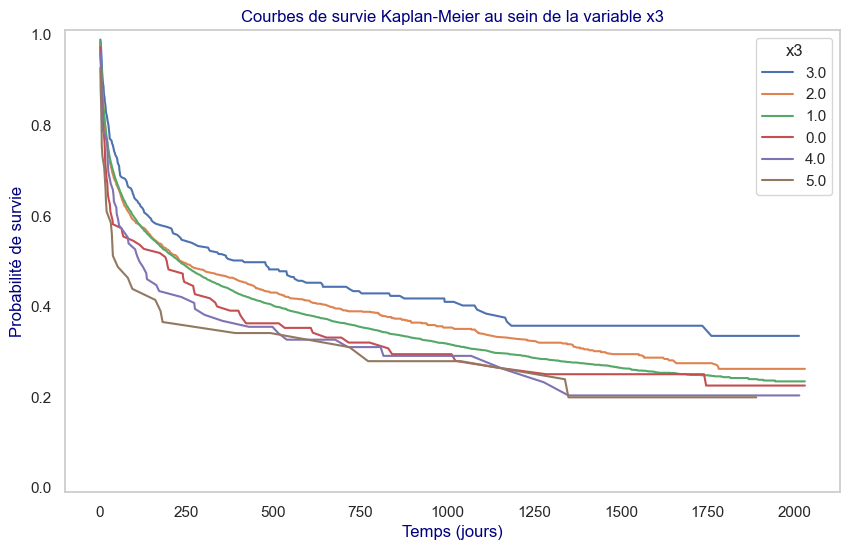

In [447]:
def plot_km_curve_by_variable(df, variable):
    """Plot Kaplan-Meier survival curves by a specified variable, sorted by survival probability."""
    unique_values = df[variable].unique()  
    survival_probs = {}  

    # calcule les courbes de survie pour chaque valeur unique
    for value in unique_values:
        # filtre le DataFrame pour obtenir uniquement les données de la valeur actuelle
        df_filtered = df[df[variable] == value]
        
        # calcule les estimations par la méthode Kaplan-Meier
        x, y = kaplan_meier_estimator(
            df_filtered["event"].astype(bool),
            df_filtered["duration"]              
        )
        
        # stocke la probabilité de survie finale pour cette valeur
        survival_probs[value] = y[-1]

    # trie les valeurs par probabilité de survie
    sorted_values = sorted(survival_probs, key=survival_probs.get, reverse=True)

    plt.figure(figsize=(10, 6))  

    # trace les courbes dans l'ordre trié
    for value in sorted_values:
        df_filtered = df[df[variable] == value]
        x, y = kaplan_meier_estimator(
            df_filtered["event"].astype(bool),
            df_filtered["duration"]              
        )
        plt.plot(x, y, label=str(value))
    
    plt.legend(title=variable)
    plt.ylim(-0.01, 1.01)
    plt.title(f"Courbes de survie Kaplan-Meier au sein de la variable {variable}", color="navy")
    plt.xlabel("Temps (jours)", color="navy")
    plt.ylabel("Probabilité de survie", color="navy")
    plt.grid()
    plt.show()

# appelle la fonction pour la variable souhaitée
plot_km_curve_by_variable(DS_support, "x3")

In [407]:
# défini les groupes en fonction de x3
groups = [DS_support[DS_support['x3'] == i] for i in range(6)]

# initialise une liste pour stocker les résultats
results_list = []

# effectue les tests de log-rang pour chaque paire de groupes
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        result = logrank_test(
            groups[i]['duration'],
            groups[j]['duration'],
            event_observed_A=groups[i]['event'],
            event_observed_B=groups[j]['event']
        )

        results_list.append({
            'Group A': i,
            'Group B': j,
            'Test Statistic': result.test_statistic,
            'P-Value': result.p_value
        })

# crée un DataFrame pour les résultats
results_df = pd.DataFrame(results_list)

display(results_df.style.hide(axis="index"))

Group A,Group B,Test Statistic,P-Value
0,1,1.006041,0.315853
0,2,2.166941,0.141007
0,3,6.597322,0.010213
0,4,0.027163,0.869092
0,5,0.416499,0.518689
1,2,2.810036,0.093676
1,3,8.641764,0.003285
1,4,1.397100,0.237210
1,5,2.204951,0.137568
2,3,3.935332,0.047282


Les courbes de survie indiquent que les individus classés dans la catégorie x3 = 3.0 ont la probabilité de survie la plus élevée et diminuent à un rythme plus lent comparé aux autres catégories. En revanche, ceux dans la catégorie x3 = 5.0 affichent la probabilité de survie la plus faible. Au début de la période d'observation, les probabilités de survie sont relativement élevées, mais cette tendance s'inverse rapidement, avec des différences notables entre les catégories intermédiaires. Cela suggère que la variable « x3 » a un impact significatif sur la dynamique des événements dans la population étudiée.

Les résultats du test de log-rank montrent des comparaisons significatives entre les groupes définis par « x3 ». Des p-values inférieures à 0.05 entre les groupes 0 et 3, et entre les groupes 1 et 4, indiquent des différences statistiquement significatives. Cela pourrait signifier que ces groupes présentent des caractéristiques de survie différentes. En revanche, des comparaisons entre les groupes 0 et 1 et entre 1 et 2 n'indiquent pas de différences significatives.

Ces résultats soulignent, notamment, l’importance de considérer les différences entre les variables et entre les groupes au sein d'un même variable, permettant ainsi une meilleure compréhension des facteurs influençant la survie, les risques associés à chaque catégorie, et les interactions potentielles entre les variables qui ne seraient pas prises en compte par la méthode de Kaplan-Meier. Outre la valeur observée du C-index qui est proche de celle du hasard, cela suggère que des analyses plus approfondies pourraient être nécessaires pour explorer les relations entre les variables et leur impact sur la survie. Il est dès lors proposé de comparer les résultats obtenus avec l'estimation par la méthode Kaplan - Meier à des stratégies de modélisations différentes.

### I.b.2. Par un modèle de Cox

L'un des principaux avantages du modèle de risques proportionnels de Cox par rapport au modèle de Kaplan-Meier réside dans sa capacité à intégrer des covariables, permettant ainsi d'évaluer l'effet de plusieurs facteurs sur le risque de survenue de l'événement tout en tenant compte de la censure des données. En d'autres termes, alors que le modèle de Kaplan-Meier fournit une estimation non paramétrique du taux de survie en fonction du temps, le modèle de Cox est semi-paramétrique et permet d'incorporer des variables explicatives susceptibles d'influencer le temps jusqu'à l'événement. Ainsi, bien que la méthode Kaplan-Meier se révèle performante pour décrire les données de manière globale, le modèle de Cox permet d’obtenir des estimations des risques associés aux covariables, offrant une analyse plus nuancée des facteurs de risque individuels.

Le modèle de Cox repose sur l'hypothèse que le risque instantané d'un événement peut être modélisé comme un produit de deux composantes : une fonction de risque de base, qui dépend uniquement du temps, et une fonction exponentielle qui dépend des covariables. Cette formulation permet d'analyser l'effet des covariables sans imposer de forme spécifique pour le risque de base. La forme générale de la fonction de risque dans le modèle de Cox est exprimée comme suit : $\lambda(t, x_i) = \lambda_0(t) \exp(x_i^\top \beta)
$, où :
- $\lambda(t, x_i)$ est le risque à un instant $t$ pour un individu ayant des covariables $x_i$,
- $\lambda_0(t)$ est la fonction de risque de base, commune à tous les individus,
- $\beta$ est le vecteur des coefficients associés aux covariables,
- $\exp(x_i^\top \beta)$ représente l'effet multiplicatif des covariables sur le risque.

La probabilité que l'individu $i$ subisse l'événement en $T_i$, sachant qu'un événement a eu lieu en $T_i$, est donnée par :

$$
\frac{\lambda_0(T_i) \exp(\beta' Z_{(i)})}{\sum_{j \in R(T_i)} \lambda_0(T_i) \exp(\beta' Z_j)} = \frac{\exp(\beta' Z_{(i)})}{\sum_{j \in R(T_i)} \exp(\beta' Z_j)}
$$

La vraisemblance partielle est alors :

$$
L_{\text{Cox}}(\beta) = \prod_{i=1}^{d} \frac{\exp(x_i^\top \beta)}{\sum_{j \in R(T_i)} \exp(x_j^\top \beta)}
$$

et la log-vraisemblance s'exprime comme :

$$
\log L(\beta) = \sum_{i=1}^{d} \left( x_i^\top \beta \right) - \sum_{i=1}^{d} \log \left( \sum_{j \in R(T_i)} \exp(x_j^\top \beta) \right)
$$

Il apparaît alors que la vraisemblance partielle ne dépend pas de la fonction de risque de base $\lambda_0(t)$, ce qui permet d'estimer les coefficients $\beta$ sans faire d'hypothèse sur la forme de $\lambda_0(t)$.

Une fois les coefficients $\beta$ estimés, ils quantifient l'impact des covariables sur le risque d'événement. Un coefficient positif indique que l'augmentation de la covariable correspondante accroît le risque de l'événement, tandis qu'un coefficient négatif indique une réduction du risque.

Par ailleurs, le rapport des risques entre deux individus est donné par la relation suivante : $\frac{\lambda(t, x_i)}{\lambda(t, x_j)} = \frac{\lambda_0(t) e^{x_i^\top \beta}}{\lambda_0(t) e^{x_j^\top \beta}}=\frac{e^{x_i^\top \beta}}{e^{x_j^\top \beta}}$. L'hypothèse de proportionnalité des risques découle de ce rapport, puisqu'après simplification, celui-ci est indépendant de $\lambda_0(t)$. Par conséquent, le rapport des risques reste constant dans le temps car il est uniquement déterminé par les covariables et leurs coefficients associés, qui sont estimés par le modèle. Cela implique que les relations entre les risques pour différents individus ne changent pas au cours du temps, et les effets des covariables sont donc proportionnels et constants tout au long de l'étude.

En raison des différences d'échelle entre certaines covariables (comme observé dans les boxplots), certaines d'entre elles pourraient dominer l'influence du modèle, faussant ainsi les résultats. En l'absence d'informations plus précises sur la nature de chaque variable, il est proposé de standardiser les données afin que chaque variable contribue de manière équitable à l'évaluation du risque.

In [448]:
# exclusion des colonnes non pertinentes
X_train = DS_support.drop(columns=["Unnamed: 0", "Statut_censure", "event", "duration"])

# préparation des données de survie
y_train = Surv.from_dataframe("event", "duration", DS_support)

# prétraitement : encodage pour x2, x3, x6 et standardisation des colonnes numériques
simple_preprocessor = make_column_transformer(
    (OneHotEncoder(), ["x2", "x3", "x6"]),
    (StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns.difference(["x2", "x3", "x6"])),
    remainder="drop",  
    verbose_feature_names_out=False
)

# création et ajustement du pipeline
cox_ph = make_pipeline(
    simple_preprocessor,
    CoxPHSurvivalAnalysis(alpha=1e-4)
)
cox_ph.fit(X_train, as_sksurv_recarray(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['x2', 'x3', 'x6']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['x0', 'x1', 'x10', 'x11', 'x12', 'x13', 'x4', 'x5', 'x7', 'x8', 'x9'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.0001))])

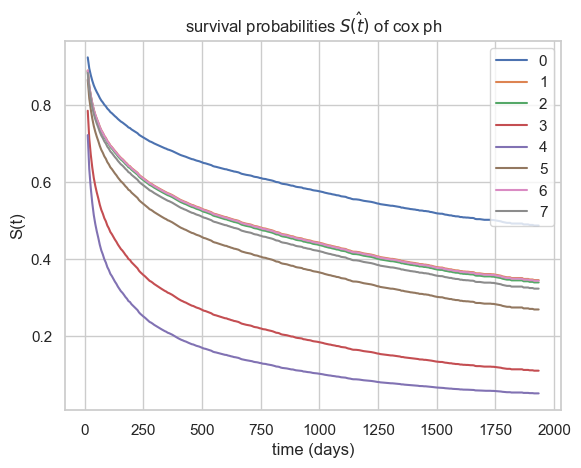

In [449]:
# prédit les fonctions de survie pour chaque observation dans X_test 
cox_ph_survival_funcs = cox_ph.predict_survival_function(X_test)

fig, ax = plt.subplots()

# trace les courbes de survie pour les 8 premières observations de l'ensemble de test
for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:8]):
    survival_curve = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)

ax.set(
    title=r"survival probabilities $\hat{S(t)}$ of cox ph", 
    xlabel="time (days)",
    ylabel="S(t)",
)

plt.legend()
plt.show()

In [450]:
X_test.head(8).reset_index(drop=True)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,40.34998,1.0,1.0,2.0,0.0,0.0,1.0,110.0,60.0,20.0,36.09375,137.0,5.500000,1.099854,70.0,1
1,60.63797,1.0,0.0,1.0,0.0,0.0,1.0,142.0,72.0,26.0,38.00000,136.0,10.699219,10.599609,26.0,1
2,47.43298,0.0,2.0,1.0,0.0,0.0,1.0,73.0,115.0,24.0,36.89844,141.0,5.099609,1.699951,17.0,1
3,66.77594,0.0,5.0,1.0,1.0,0.0,2.0,77.0,78.0,24.0,36.59375,131.0,6.599609,2.899902,575.0,1
4,72.55896,0.0,1.0,1.0,0.0,0.0,0.0,43.0,46.0,30.0,38.50000,145.0,1.399902,3.399902,26.0,1
5,72.71198,0.0,3.0,1.0,0.0,0.0,1.0,73.0,96.0,20.0,36.29688,137.0,5.699219,0.799927,424.0,0
6,61.44800,0.0,3.0,2.0,0.0,0.0,1.0,117.0,82.0,28.0,36.59375,139.0,7.000000,1.199951,608.0,1
7,63.10199,0.0,5.0,1.0,1.0,0.0,1.0,97.0,50.0,16.0,35.79688,146.0,4.299805,2.500000,8.0,1


In [451]:
feature_names = cox_ph[-2].get_feature_names_out()
feature_names.tolist()

['x2_0.0',
 'x2_1.0',
 'x2_2.0',
 'x2_3.0',
 'x2_4.0',
 'x2_5.0',
 'x2_6.0',
 'x2_7.0',
 'x2_8.0',
 'x2_9.0',
 'x3_0.0',
 'x3_1.0',
 'x3_2.0',
 'x3_3.0',
 'x3_4.0',
 'x3_5.0',
 'x6_0.0',
 'x6_1.0',
 'x6_2.0',
 'x0',
 'x1',
 'x10',
 'x11',
 'x12',
 'x13',
 'x4',
 'x5',
 'x7',
 'x8',
 'x9']

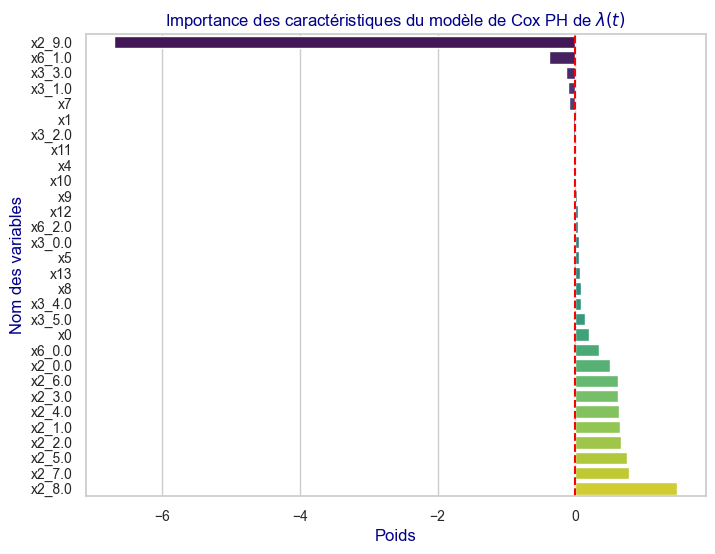

In [452]:
# création du DataFrame des caractéristiques
features = (
    pd.DataFrame(
        dict(
            feature_name=feature_names,
            weight= cox_ph[-1].coef_,
        )
    )
    .sort_values("weight")
)

# définit une palette de couleurs
palette = sns.color_palette("viridis", len(features))

# création du barplot 
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=features, y="feature_name", x="weight", palette=palette, orient="h")
ax.set_title("Importance des caractéristiques du modèle de Cox PH de $\\lambda(t)$", color="darkblue", fontsize=12)
ax.set_xlabel("Poids", color="darkblue", fontsize=12)
ax.set_ylabel("Nom des variables", color="darkblue", fontsize=12)
ax.tick_params(axis="y", labelsize=10)
ax.tick_params(axis="x", labelsize=10)
ax.axvline(0, color="red", linestyle="--")
plt.show()

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.2844,0.5000,1036.1,686.1,459.3
1,Kaplan-Meier,0.2250,0.5000,1282.4,426.5,461.9
2,Cox PH,0.2029,0.5996,637.9,429.3,450.0


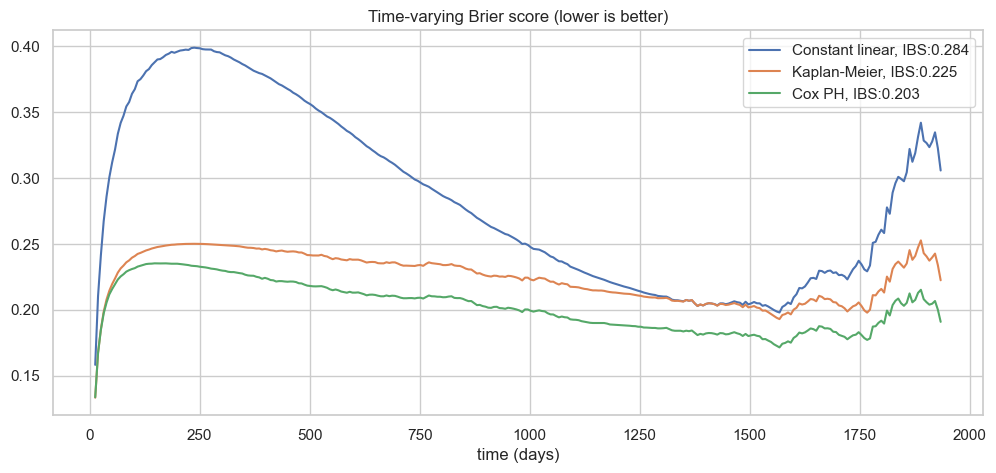

In [453]:
# calcul les métriques d'erreurs associées à l'estimation par le modèle de cox et la courbe du brier score
cox_survival_curves = np.vstack(
    [
        cox_ph_survival_func(time_grid)
        for cox_ph_survival_func in cox_ph_survival_funcs
    ]
)
evaluator("Cox PH", cox_survival_curves)

Le premier graphique montre les courbes de survie estimées par le modèle de Cox PH pour les huit premières observations de l’ensemble de test. Ces courbes représentent la probabilité de survie estimée pour des individus distincts, en fonction de leurs caractéristiques individuelles. On peut observer que la probabilité de survie diminue avec le temps, et que les courbes varient entre elles, ce qui indique que les covariables influencent les probabilités de survie de manière individuelle. Les courbes plus élevées correspondent à une meilleure survie pour certains individus, tandis que celles plus basses indiquent un risque accru d’événement pour d’autres, reflétant les variations individuelles dans les caractéristiques du jeu de données.

Le second graphique présente l'importance des caractéristiques du modèle de Cox PH en fonction des poids estimés. Les variables « x2 » et « x6 » semblent jouer un rôle influent, avec une prédominance très marquées de la variable « x2 », soulignant l'importance de cette variable dans la modélisation du risque.

Le modèle de Cox PH présente un IBS inférieur aux deux autres modèles testés, ce qui indique que le modèle de Cox offre des prévisions de survie plus précises. De plus, le C-index de ce modèle est supérieur, ce qui suggère une capacité plus importante à discriminer les événements et les censures. En somme, les résultats du modèle de Cox PH indiquent une capacité plus robuste à estimer les probabilités de survie tout en tenant compte des effets des covariables. Bien que cela indique une certaine performance, des améliorations pourraient être possibles en tentant d'affiner le modèle.

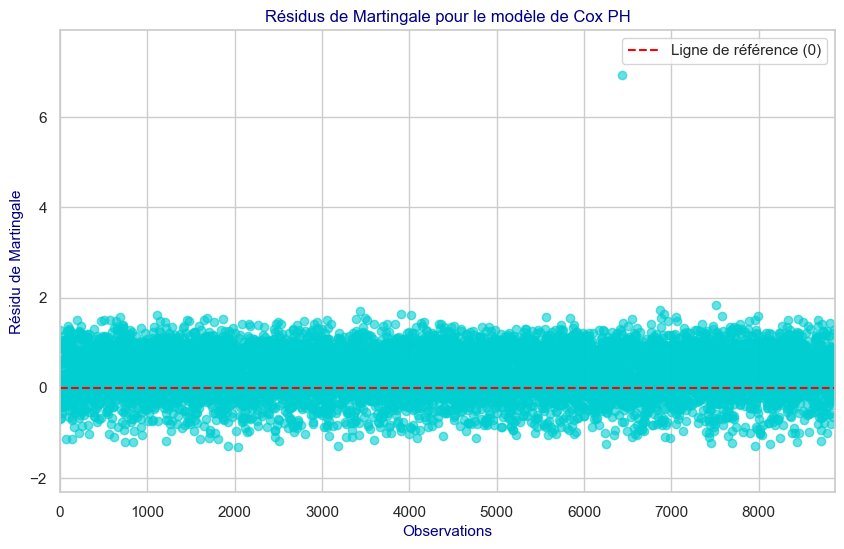

In [300]:
plt.figure(figsize=(10, 6))

# prédiction du risque cumulé pour chaque observation
cox_ph_risks = cox_ph.predict(X_train)

# calcul des résidus de martingale : M_i = delta_i - risque_i
# delta_i est l'indicateur de l'événement (1 si non censuré, 0 si censuré)
delta_i = y_train['event'] 
residuals_martingale = delta_i - cox_ph_risks

plt.scatter(np.arange(len(residuals_martingale)), residuals_martingale, alpha=0.6, color='darkturquoise')
plt.axhline(0, color='red', linestyle='--', label='Ligne de référence (0)')
plt.title("Résidus de Martingale pour le modèle de Cox PH", fontsize=12, color="navy")
plt.xlabel("Observations", fontsize=11, color="navy")
plt.ylabel("Résidu de Martingale", fontsize=11, color="navy")
plt.legend()

# ajuste les limites des axes si nécessaire
plt.xlim(0, len(residuals_martingale))  
plt.ylim(min(residuals_martingale) - 1, max(residuals_martingale) + 1) 


plt.show()

In [301]:
# exclus les colonnes non pertinentes
DS_support_clean = DS_support.drop(columns=["Unnamed: 0", "Statut_censure"])

# One-Hot encodage des variables catégorielles x2, x3 et x6
DS_support_encoded = pd.get_dummies(DS_support_clean, columns=["x2", "x3", "x6"], drop_first=True)

# entraîne le modèle Cox avec lifelines
cph = CoxPHFitter()
cph.fit(DS_support_clean, duration_col='duration', event_col='event')

# test de Schoenfeld pour l'hypothèse de proportionnalité
results = proportional_hazard_test(cph, DS_support_clean, time_transform='rank')
print(results)


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8873 total observations, 2837 right-censored observations>
         test_name = proportional_hazard_test

---
     test_statistic      p  -log2(p)
x0            28.23 <0.005     23.15
x1             5.61   0.02      5.80
x10            6.02   0.01      6.15
x11            5.36   0.02      5.60
x12           12.62 <0.005     11.36
x13           14.40 <0.005     12.72
x2           148.08 <0.005    110.76
x3             0.54   0.46      1.11
x4             0.07   0.80      0.33
x5             3.95   0.05      4.42
x6           301.19 <0.005    221.71
x7            49.88 <0.005     39.15
x8            10.24 <0.005      9.51
x9             2.95   0.09      3.54


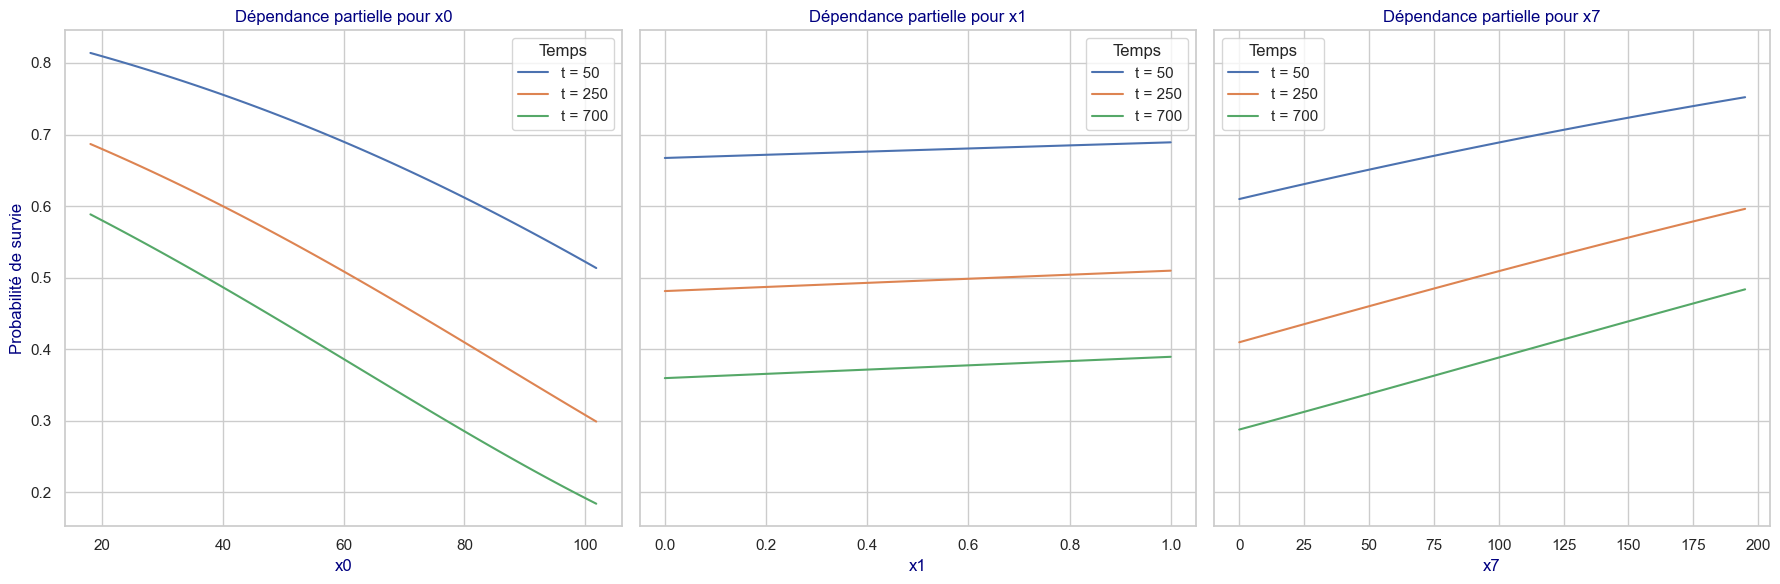

In [302]:
# ajustement du modèle de Cox avec lifelines
cph = CoxPHFitter()
cph.fit(DS_support_clean, duration_col='duration', event_col='event')

# liste des variables avec lesquelles créer les dépendances partielles
variables = ['x0', 'x1', 'x7']

# création de la figure avec 3 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# définition des temps à tracer
times_to_plot = [50, 250, 700]

# boucle pour générer le graphique de dépendance partielle pour chaque variable
for i, variable in enumerate(variables):
    # définit les valeurs pour la covariable
    values = np.linspace(DS_support_clean[variable].min(), DS_support_clean[variable].max(), 100)
    
    # calcule les prédictions de survie pour chaque valeur de la covariable sélectionnée
    survival_predictions = []
    for val in values:
        # crée une copie des données avec la variable fixée à `val`
        data = DS_support_clean.copy()
        data[variable] = val

        # calcule la survie moyenne pour cette valeur de la variable
        survival_function = cph.predict_survival_function(data).mean(axis=1)
        survival_predictions.append(survival_function.values)
    
    # conversion en DataFrame pour faciliter le traçage
    survival_df = pd.DataFrame(survival_predictions, index=values, columns=survival_function.index)
    
    # trace le graphique de dépendance partielle pour la variable actuelle aux temps définis
    for time in times_to_plot:
        if time in survival_function.index: 
            axes[i].plot(survival_df.index, survival_df[time], label=f"t = {time}")
    axes[i].set_title(f"Dépendance partielle pour {variable}", color='navy')
    axes[i].set_xlabel(variable, color='navy')
    if i == 0:
        axes[i].set_ylabel("Probabilité de survie", color='navy')
    axes[i].legend(title="Temps")

plt.tight_layout()
plt.show()

Les résidus de Martingale évaluent l'ajustement des modèles de survie par le modèle Cox PH. Ils représentent la différence entre le statut observé de l'événement - censure ou occurrence de l'événement - et la probabilité estimée de cet événement par le modèle. Ces résidus permettent d'identifier des observations qui s'écartent du modèle ajusté, offrant un aperçu de sa précision. Si les résidus de Martingale présentent de forts écarts ou des tendances, cela peut indiquer un ajustement inadéquat du modèle ou la présence de valeurs influentes qui mériteraient une analyse plus approfondie.
Le graphique montre une dispersion des résidus de Martingale autour de la ligne de référence à 0, sans schéma particulièrement visible, ce qui est un bon indicateur de l'ajustement du modèle aux données. La majorité des points se concentrent autour de cette ligne, avec peu de valeurs éloignées, ce qui suggère que le modèle capture correctement les relations principales dans les données sans présenter de fortes erreurs systématiques. Cependant, on observe quelques résidus extrêmes au-dessus et en dessous de la ligne de référence, ce qui pourrait indiquer des observations influentes ou des effets non capturés par le modèle. Une analyse plus approfondie pourrait être envisagée pour identifier la cause de ces écarts.

De plus, le test des risques proportionnels examine si l'hypothèse de proportionnalité des risques, fondamentale pour le modèle de Cox, est vérifiée pour chaque variable. Les statistiques de test et les valeurs $p$ montrent que certaines variables ne respectent pas cette hypothèse. En particulier, les variables « x0 », « x2 », « x6 » et « x7 » affichent des valeurs $p$ inférieures à 0.005, suggérant des écarts significatifs par rapport à la proportionnalité des risques. Cela peut indiquer que les effets de ces variables sur le risque de l'événement varient dans le temps, ce qui remet en question l'usage du modèle de Cox standard pour ces covariables.

Les graphiques de dépendance partielle montrent quant à eux l'influence des variables « x0 », « x1 » et « x7 » sur la probabilité de survie estimée par le modèle de Cox PH à différents instants dans le temps. La première courbe, associée à la variable « x0 », indique une diminution notable de la probabilité de survie à mesure que la valeur de « x0 » augmente, et ce pour chaque instant, ce qui suggère un effet négatif de cette variable sur la survie. En revanche, les courbes pour « x1 » montrent une probabilité de survie relativement stable, avec des variations faibles quel que soit le temps, suggérant que cette variable a un impact moindre sur la survie. Enfin, la variable « x7 » présente une relation positive avec la probabilité de survie : les courbes montrent que l'augmentation de « x7 » est associée à une meilleure survie, avec des courbes légèrement ascendantes pour chaque instant. Ces résultats confirment l'influence hétérogène des covariables dans le modèle et mettent en évidence des effets distincts sur la survie, en accord avec l'importance observée pour certaines de ces variables dans le modèle.

Pour tenter de mieux capturer ces effets de non-proportionnalité et améliorer la robustesse des estimations, il est proposé d’explorer plusieurs variantes du modèle. Dans un premier temps, l'ajustement d'un modèle de Cox stratifié pourrait offrir une meilleure flexibilité en tenant compte de la variabilité des effets dans le temps pour les covariables présentant une non-proportionnalité marquée.

### I.b.3  Par un modèle de Cox stratifié

Le modèle de Cox stratifié est une extension du modèle de Cox proportionnel qui permet de traiter des situations où l'hypothèse de proportionnalité des risques n'est pas respectée pour certaines variables. Contrairement au modèle de Cox proportionnel, qui suppose un rapport de risques constant pour toutes les covariables, le modèle stratifié permet à certaines variables d'avoir des risques de base différents selon leurs niveaux. Cela signifie que le modèle ajuste un risque de base propre à chaque strate, tout en permettant d'estimer l'effet des autres covariables de manière proportionnelle.

Il est proposé de stratifier sur un modèle la variable « x2 », car les tests ont montré que cette variable ne respectait pas l'hypothèse de proportionnalité des risques. Il pourrait être envisagé de stratifier ce modèle sur plus de variables mais cela alourdit de manière importante les temps de calcul, et les tests effectués ont révélés un meilleur ajustement global du modèle mais pas de différences majeures concernant l'IBS et le C-index.

In [347]:
from sksurv.metrics import brier_score, integrated_brier_score
from sklearn.metrics import mean_absolute_error

# préparation des colonnes pour l'entraînement en excluant 'Unnamed: 0','Statut_censure', 'event', et 'duration'
X_train = DS_support.drop(columns=["Unnamed: 0", "Statut_censure", "event", "duration"])

# préparation des données de survie à partir des colonnes 'event' et 'duration'
y_train = Surv.from_dataframe("event", "duration", DS_support)

# encodage de 'x3' et 'x6' uniquement, sans inclure 'x2'
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), ["x3", "x6"]),
    remainder="passthrough",
    verbose_feature_names_out=False
)

# transformation des données d'entraînement
X_encoded = preprocessor.fit_transform(X_train.drop(columns=["x2"])) 

# conversion en DataFrame avec les noms des colonnes
X_encoded_df = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names_out())

# ajoute 'duration', 'event', et 'x2' aux données transformées
train_df = pd.concat([X_encoded_df, DS_support[['duration', 'event', 'x2']].reset_index(drop=True)], axis=1)

# ajustement du modèle de Cox stratifié avec pénalisation, en stratifiant sur 'x2'
coxph = CoxPHFitter(penalizer=0.01)
coxph.fit(train_df, duration_col='duration', event_col='event', strata='x2')
coxph.print_summary()

# calcul des fonctions de survie pour les observations d'entraînement
survival_funcs_train = coxph.predict_survival_function(train_df)

# calcul de la courbe de survie moyenne
coxph_curve_train = survival_funcs_train.mean(axis=1).values
coxph_times_train = survival_funcs_train.index

# préparation de la fonction de prédiction interpolée pour les courbes de survie
coxph_predict = interp1d(
    coxph_times_train,
    coxph_curve_train,
    kind="previous",
    bounds_error=False,
    fill_value="extrapolate",
)

def make_test_time_grid(y_train, n_steps=300):
    observed_duration = y_train[y_train["event"] > 0]["duration"]
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span
    stop = observed_duration.max() - 0.005 * span
    return np.linspace(start, stop, num=n_steps)

# génération de la grille de temps et courbes de survie pour la prédiction
time_grid = make_test_time_grid(pd.DataFrame(y_train))
coxph_curve = coxph_predict(time_grid)
y_pred_coxph_test = np.vstack([coxph_curve] * X_encoded_df.shape[0])

# conversion des données pour sksurv
def as_sksurv_recarray(y_frame):
    y_recarray = np.empty(
        shape=y_frame.shape[0],
        dtype=[("event", np.bool_), ("duration", np.float64)],
    )
    y_recarray["event"] = y_frame["event"]
    y_recarray["duration"] = y_frame["duration"]
    return y_recarray

# calcul des Brier Scores sur la grille de temps
_, coxph_brier_scores = brier_score(
    survival_train=as_sksurv_recarray(pd.DataFrame(y_train)),
    survival_test=as_sksurv_recarray(pd.DataFrame(y_train)),
    estimate=y_pred_coxph_test,
    times=time_grid,
)

# calcul de l'Integrated Brier Score (IBS)
coxph_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(pd.DataFrame(y_train)),
    survival_test=as_sksurv_recarray(pd.DataFrame(y_train)),
    estimate=y_pred_coxph_test,
    times=time_grid,
)
print(f"IBS of stratified Cox model on test set: {coxph_ibs_test:.4f}")

# calcul des MAE pour les quantiles pour le meilleur modèle
all_mae_best = []
coxph_times_best = coxph_times_train
survival_funcs_best = survival_funcs_train

for q in [0.25, 0.5, 0.75]:
    y_pred_quantile_best = np.quantile(survival_funcs_best.values.T, q, axis=1)
    mae_best = mean_absolute_error(train_df['duration'], y_pred_quantile_best)
    all_mae_best.append((q, mae_best.round(1)))

# affiche les MAE pour les quantiles pour le meilleur modèle
for q, mae in all_mae_best:
    print(f"MAE for best model q={q}: {mae}")

model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event'
penalizer,0.01
l1 ratio,0.0
strata,x2
baseline estimation,breslow
number of observations,8873
number of events observed,6036
partial log-likelihood,-41315.08
time fit was run,2024-10-31 21:53:03 UTC


IBS of stratified Cox model on test set: 0.2184
MAE for best model q=0.25: 478.4
MAE for best model q=0.5: 478.3
MAE for best model q=0.75: 478.2


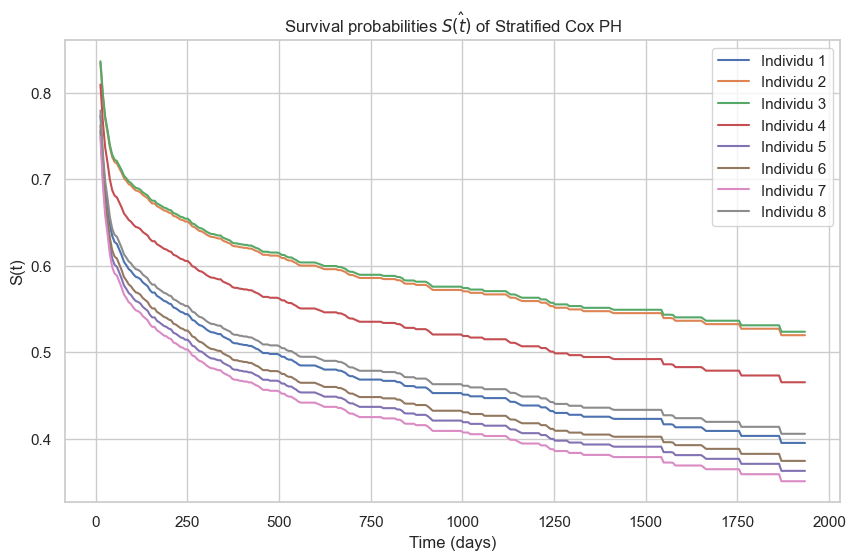

In [361]:
# prédiction des fonctions de survie sur l'ensemble de test avec stratification sur 'x2'
X_encoded_df['x2'] = DS_support['x2']

coxph_survival_funcs_test = coxph.predict_survival_function(X_encoded_df, times=time_grid)

# tracé des courbes de survie pour les instances de test
fig, ax = plt.subplots(figsize=(10, 6))
for idx in range(min(8, len(coxph_survival_funcs_test.columns))):
    survival_curve = coxph_survival_funcs_test.iloc[:, idx]
    ax.plot(time_grid, survival_curve, label=f"Individu {idx+1}")

ax.set(
    title=r"Survival probabilities $\hat{S(t)}$ of Stratified Cox PH", 
    xlabel="Time (days)",
    ylabel="S(t)"
)
plt.legend()
plt.show()

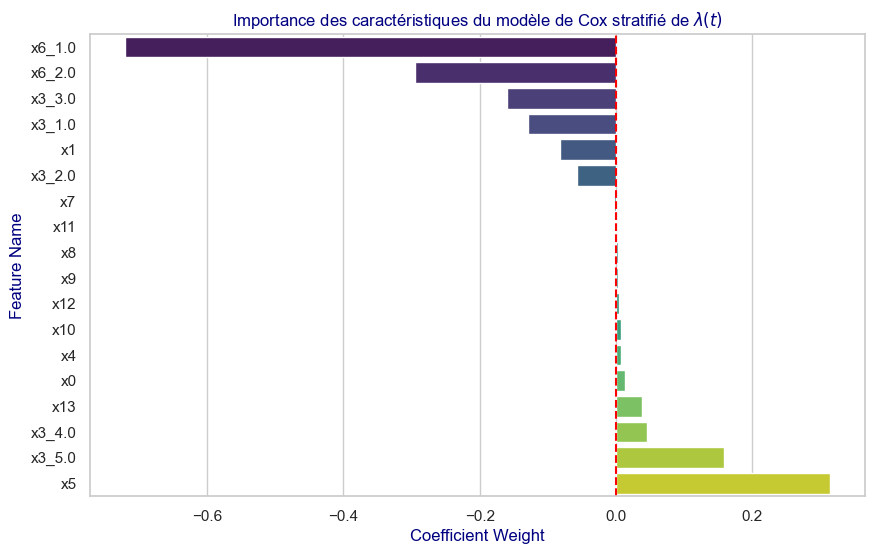

In [362]:
# extrait les coefficients du modèle Cox stratifié
feature_importance = pd.DataFrame({
    "feature_name": coxph.params_.index,
    "weight": coxph.params_.values
}).sort_values(by="weight")

# définit une palette de couleurs pour la visualisation
palette = sns.color_palette("viridis", len(feature_importance))

# création du barplot avec la palette de couleurs
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=feature_importance, y="feature_name", x="weight", orient="h", palette=palette)
ax.axvline(0, color="red", linestyle="--")
ax.set_title("Importance des caractéristiques du modèle de Cox stratifié de $\\lambda(t)$", color = "navy")
ax.set_xlabel("Coefficient Weight", color = "navy")
ax.set_ylabel("Feature Name", color = "navy")
plt.show()

Il est proposé de revenir sur l’analyse comparative des métriques à la fin de ce chapitre, afin d'effectuer un bilan global des modèles. Notons cependant que dans le modèle de Cox stratifié, les courbes de survie apparaissent davantage segmentées, mieux adaptées aux spécificités de chaque strate. Les différences dans l'importance des variables sont également notables entre les deux modèles. Dans le modèle de Cox PH, les variables semblent avoir un impact plus diffus, avec une prédominance marquée de la variable « x2_9 ». En revanche, dans le modèle stratifié, la répartition de l’importance des variables est globalement plus homogène, et certaines variables comme « x6_1.0 » et « x1 » apportent également une contribution significative. En atténuant l'effet d'une variable ne respectant pas l’hypothèse de proportionnalité, la stratification semble restituer des effets plus complexes et nuancés liés à d’autres variables.

#### I.b.4. Par un modèle de Cox polynomial

Ce modèle est une variante du modèle de Cox proportionnel qui permet de modéliser de manière plus flexible la relation entre les covariables et le risque. Contrairement au modèle de Cox classique, qui suppose une relation linéaire entre les covariables et le logarithme du risque, le modèle de Cox polynomial introduit des termes non linéaires pour certaines covariables. Cela permet de mieux capturer les effets complexes et non linéaires de ces variables sur le risque.

Il est proposé d’utiliser un modèle de Cox polynomial de degré 2, afin de limiter de le risque de sur-ajustement, pour les variables « x6 », « x2 », « x7 », « x13 », et « x0 », car une relation linéaire pourrait ne pas suffire pour représenter leur impact. En introduisant des termes polynomiaux et en appliquant des transformations de type spline sur ces variables, le modèle pourrait se révéler plus adapté et potentiellement plus précis. Cette approche est notamment guidée par les résultats du test de proportionnalité, qui indiquent que certaines variables, notamment x2 et x6, violent l’hypothèse de proportionnalité. 

En outre, le noyau utilisé pour créer les termes polynomiaux peut être ajusté pour mieux représenter la relation entre les variables et le risque. Par exemple, des noyaux comme le noyau polynomial ou le noyau gaussien (RBF) peuvent être employés pour capturer des interactions de manière plus complexe, permettant ainsi d'adapter le modèle aux spécificités des données.

<h5 style="margin-left: 60px;"> I.b.4.1. Avec un noyau polynomial de degré 2

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.2844,0.5000,1036.1,686.1,459.3
1,Kaplan-Meier,0.2250,0.5000,1282.4,426.5,461.9
2,Cox PH,0.2029,0.5996,637.9,429.3,450.0
3,Cox PH polynomial,0.1913,0.6379,634.1,438.2,436.7


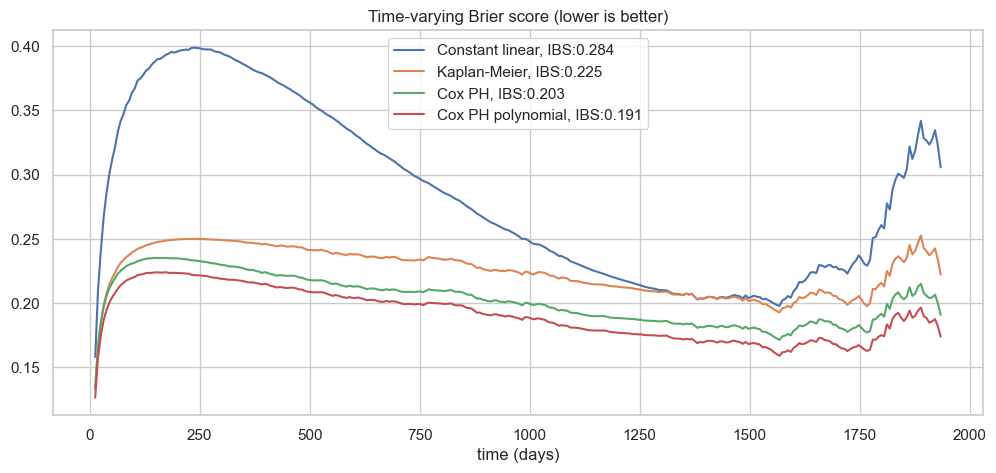

In [454]:
# exclusion de la colonne "Statut_censure" et d'autres colonnes non pertinentes
X_train = DS_support.drop(columns=["Unnamed: 0", "Statut_censure", "event", "duration"])

# préparation des données de survie à partir de la colonne 'event' (pour indiquer la censure) et 'duration' (pour la durée)
y_train = Surv.from_dataframe("event", "duration", DS_support)

# applique les splines à `x6`, `x2`, `x7`, `x13`, et ajout de `x0`
spline_preprocessor = make_column_transformer(
    (SplineTransformer(degree=3), ["x6", "x2", "x7", "x13", "x0"]),
    (OneHotEncoder(), ["x2", "x3", "x6"]),
    (StandardScaler(), X_train.columns),
    verbose_feature_names_out=False
)

# modèle polynomial avec Nystroem 
poly_cox_ph = make_pipeline(
    spline_preprocessor,
    Nystroem(kernel="poly", degree=2, n_components=300),
    CoxPHSurvivalAnalysis(alpha=1e-2)
)

# ajuste le modèle polynomial Cox PH
poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

# prédiction des fonctions de survie pour l'ensemble de test
poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)

# limite les prédictions aux observations filtrées par le masque de durée
poly_cox_ph_survival_curves = np.vstack(
    [
        poly_cox_ph_survival_func(time_grid)
        for poly_cox_ph_survival_func in poly_cox_ph_survival_funcs
    ]
)

# évalue et compare le modèle avec les autres modèles
evaluator("Cox PH polynomial", poly_cox_ph_survival_curves)

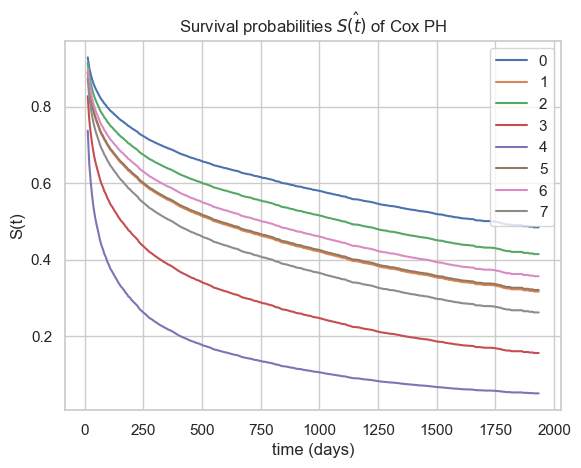

In [455]:
# fonctions de survie pour chaque observation dans X_test 
cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:8]):
    survival_curve = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)

ax.set(
    title=r"Survival probabilities $\hat{S(t)}$ of Cox PH", 
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend()
plt.show() 

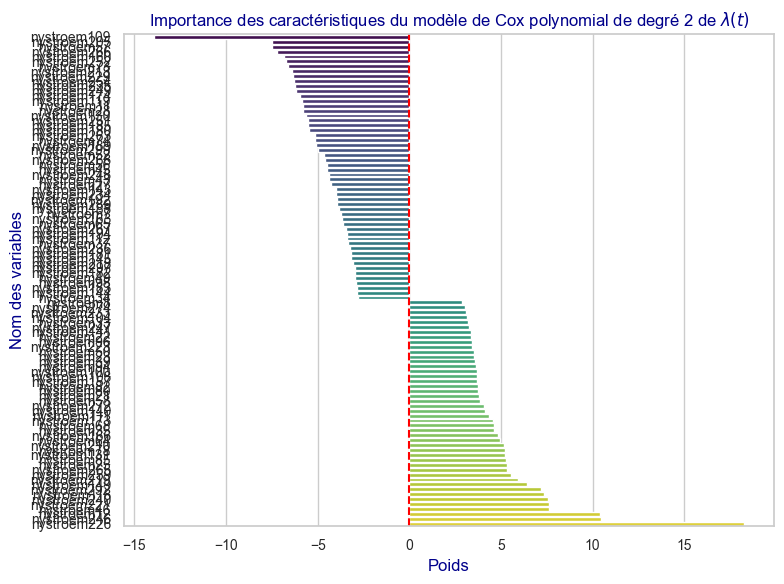

In [456]:
# création du DataFrame des caractéristiques
features = (
    pd.DataFrame(
        dict(
            feature_name=poly_cox_ph[-2].get_feature_names_out(),
            weight=poly_cox_ph[-1].coef_,
        )
    )
    .sort_values("weight")
)

# limite le nombre de caractéristiques à afficher
features["abs_weight"] = features["weight"].abs() 
top_features = features.nlargest(100, "abs_weight").sort_values("weight")

# visualisation des caractéristiques importantes
palette = sns.color_palette("viridis", len(top_features))  # Définir une palette de couleurs avec 'viridis'
plt.figure(figsize=(8, 6))  # Taille de la figure
ax = sns.barplot(data=top_features, y="feature_name", x="weight", palette=palette, orient="h")  # Barplot horizontal
ax.set_title("Importance des caractéristiques du modèle de Cox polynomial de degré 2 de $\\lambda(t)$", color="darkblue", fontsize=12)
ax.set_xlabel("Poids", color="darkblue", fontsize=12)
ax.set_ylabel("Nom des variables", color="darkblue", fontsize=12)
ax.tick_params(axis="y", labelsize=10)  # Taille de la police des labels de l'axe y
ax.tick_params(axis="x", labelsize=10)  # Taille de la police des labels de l'axe x
ax.axvline(0, color="red", linestyle="--")  # Ligne verticale pour indiquer x = 0

plt.tight_layout()  
plt.show() 

Comparé au modèle de Cox classique, le modèle polynomial de degré 2 identifie un nombre nettement plus élevé de variables significatives, en raison de l'ajout de termes non linéaires et de termes d'interaction entre les covariables. Cette structure permet de capturer des relations plus fines et complexes entre les variables et le risque de survie, ce qui améliore potentiellement l'ajustement du modèle aux données. Cependant, cette complexité accrue rend également l'interprétation plus difficile, car les interactions et les effets non linéaires nécessitent une analyse approfondie pour comprendre l'impact individuel de chaque variable. Bien que le modèle semble capturer plus finement les interactions dans les données, il introduit aussi un risque de sur-ajustement et complique l’interprétation des effets de chaque covariable. Cela appelle donc à une certaine vigilance pour respecter les objectifs de performance et de parcimonie.

<h5 style="margin-left: 60px;"> I.b.4.2. Avec un noyau gaussien

In [462]:
# utilisation d'un backend "silencieux" pour matplotlib qui ne produit pas d'affichage graphique
plt.ioff() 

# exclusion des colonnes non pertinentes
X_train = DS_support.drop(columns=["Unnamed: 0", "Statut_censure", "event", "duration"])

# préparation des données de survie 
y_train = Surv.from_dataframe("event", "duration", DS_support)

# applique les splines à `x6`, `x2`, `x7`, `x13`, et `x0` 
spline_preprocessor = make_column_transformer(
    (SplineTransformer(degree=3), ["x6", "x2", "x7", "x13", "x0"]),
    (OneHotEncoder(), ["x2", "x3", "x6"]),
    (StandardScaler(), X_train.columns),
    verbose_feature_names_out=False
)

# modèle Cox PH avec noyau gaussien (RBF) via Nystroem
rbf_cox_ph = make_pipeline(
    spline_preprocessor,
    Nystroem(kernel="rbf", gamma=0.1, n_components=300), 
    CoxPHSurvivalAnalysis(alpha=1e-2)
)

# ajuster le modèle 
rbf_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

# prédiction des fonctions de survie
rbf_cox_ph_survival_funcs = rbf_cox_ph.predict_survival_function(X_test)

# limite les prédictions aux observations filtrées par le masque de durée
rbf_cox_ph_survival_curves = np.vstack(
    [
        rbf_cox_ph_survival_func(time_grid)
        for rbf_cox_ph_survival_func in rbf_cox_ph_survival_funcs
    ]
)

# évalue et comparer le modèle avec d'autres modèles
evaluator("Cox PH avec noyau gaussien (RBF)", rbf_cox_ph_survival_curves)

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.2844,0.5000,1036.1,686.1,459.3
1,Kaplan-Meier,0.2250,0.5000,1282.4,426.5,461.9
2,Cox PH,0.2029,0.5996,637.9,429.3,450.0
3,Cox PH polynomial,0.1913,0.6379,634.1,438.2,436.7
4,Cox PH avec noyau gaussien (RBF),0.1917,0.6359,634.9,434.9,438.1


### I.b.5. Par un modèle de Cox avec fragilité

Ce modèle est une extension du modèle de Cox proportionnel qui introduit un terme de fragilité pour capturer l’hétérogénéité non observée entre les groupes ou les individus. Contrairement au modèle de Cox classique, le modèle avec fragilité ajoute un effet aléatoire pour modéliser les variations de risque inexpliquées par les covariables.

Ce terme de fragilité, souvent représenté par une variable aléatoire suivant une loi gamma, permet de capturer les effets spécifiques à des groupes - comme les individus appartenant à une même région géographique, une même cohorte, etc. - ou des différences individuelles non mesurées. En intégrant cet effet aléatoire, le modèle de Cox avec fragilité peut mieux ajuster les données en prenant en compte des facteurs non observés qui influencent le risque.

Il est proposé d’utiliser un modèle de Cox avec fragilité pour les groupes définis par la variable « x2 » car cette variable semble violer l'hypothèse de proportionnalité des risques selon les résultats du test de proportionnalité. En intégrant la variable « x2 » comme un effet de fragilité, il est espéré une meilleure captation de l’hétérogénéité non observée entre les groupes associés à cette variable, tout en évitant que son influence n'éclipse les effets d'autres covariables. Ce modèle applique également des transformations spline sur les covariables « x0 » et « x7 » pour mieux modéliser les relations non linéaires. Les variables catégorielles, telles que « x3 » et « x6 », sont encodées, et une standardisation est appliquée aux variables continues restantes. Une validation croisée est utilisée pour sélectionner la meilleure valeur de pénalisation, en optimisant l’Integrated Brier Score (IBS) et en calculant des MAE pour différents quantiles, afin de s'assurer que le modèle est ajusté de manière optimale aux spécificités de chaque groupe.

In [322]:
from sksurv.metrics import brier_score, integrated_brier_score

# préparation des colonnes pour l'entraînement en excluant les colonnes non pertinentes
X_train = DS_support.drop(columns=["Unnamed: 0", "Statut_censure", "event", "duration"])
y_train = DS_support[['event', 'duration']]

# fonction pour créer le préprocesseur
def create_preprocessor(variables):
    return make_column_transformer(
        (SplineTransformer(degree=3), ["x0", "x7"]),  # Transformation spline pour x0 et x7
        (OneHotEncoder(), ["x3", "x6"]),  # Encodage OneHot pour x3 et x6
        (StandardScaler(), variables.difference(["x0", "x7", "x2"])),  # Standardisation des autres variables
        verbose_feature_names_out=False
    )

# création de la grille de temps pour l'évaluation
def make_test_time_grid(test_data, n_steps=300):
    observed_duration = test_data["duration"]
    start = observed_duration.min() + 0.01 * (observed_duration.max() - observed_duration.min())
    stop = observed_duration.max() - 0.01 * (observed_duration.max() - observed_duration.min())
    return np.linspace(start, stop, num=n_steps)

# calcul de l'IBS et du Brier Score avec validation croisée
def compute_ibs_with_cv(train_df, penalizer=0.01, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    ibs_scores = []
    brier_scores_fragilisé = []
    
    for train_index, test_index in kf.split(train_df):
        train_data = train_df.iloc[train_index]
        test_data = train_df.iloc[test_index]
        
        # ajuste le modèle avec effet de fragilité sur les données d'entraînement
        coxph = CoxPHFitter(penalizer=penalizer)
        coxph.fit(train_data, duration_col='duration', event_col='event', cluster_col='group')
        
        # génération de la fonction de survie pour les données de test
        baseline_times = coxph.baseline_survival_.index
        baseline_curve = coxph.baseline_survival_['baseline survival'].values
        survival_predictor = interp1d(
            baseline_times,
            baseline_curve,
            kind="previous",
            bounds_error=False,
            fill_value="extrapolate",
        )
        
        # création de la grille de temps spécifique à l'ensemble de test
        time_grid = make_test_time_grid(test_data)
        survival_curves = np.vstack([survival_predictor(time_grid)] * test_data.shape[0])

        # conversion des données pour sksurv
        def as_sksurv_recarray(df):
            y_recarray = np.empty(
                shape=df.shape[0],
                dtype=[("event", np.bool_), ("duration", np.float64)],
            )
            y_recarray["event"] = df["event"]
            y_recarray["duration"] = df["duration"]
            return y_recarray

        y_train_rec = as_sksurv_recarray(train_data)
        y_test_rec = as_sksurv_recarray(test_data)

        # calcul de l'Integrated Brier Score (IBS) pour ce split
        ibs_score = integrated_brier_score(
            survival_train=y_train_rec,
            survival_test=y_test_rec,
            estimate=survival_curves,
            times=time_grid,
        )
        ibs_scores.append(ibs_score)
        
        # calcul du Brier Score à chaque temps unique pour le test set
        durations = test_data['duration'].values
        events = test_data['event'].values
        unique_times_fragilisé = np.sort(np.unique(durations))
        
        brier_scores_split = []
        for time in unique_times_fragilisé:
            # vérifie que le temps est dans l'index des fonctions de survie
            if time in survival_predictor.x:
                predicted_survival = survival_predictor(time)
                mask = (durations >= time)
                brier_score_value_bis = np.mean((predicted_survival - events[mask]) ** 2)
                brier_scores_split.append(brier_score_value_bis)
        
        # calcul du Brier Score moyen pour ce split
        brier_scores_fragilisé.append(np.mean(brier_scores_split))

    # moyenne des IBS et du Brier Score sur tous les splits
    return np.mean(ibs_scores), np.std(ibs_scores), np.mean(brier_scores_fragilisé)

# liste des valeurs de pénalisation à tester
penalizer_values = [0.001, 0.01, 0.1, 1]

# préparation des données d'entraînement pour inclure 'group' et ajouter 'x2' comme variable de fragilité
train_df = pd.concat([X_train, y_train], axis=1)
train_df['group'] = DS_support['x2'] 

# sélection des variables et initialisation des valeurs de départ
selected_variables = X_train.columns
best_score = float("inf")
best_penalizer = None

for penalizer in penalizer_values:
    mean_ibs, std_ibs, mean_brier = compute_ibs_with_cv(train_df, penalizer=penalizer)
    print(f"Pénalisation: {penalizer}, IBS moyen: {mean_ibs:.4f}, Écart-type IBS: {std_ibs:.4f}, Brier Score moyen: {mean_brier:.4f}")
    
    if mean_ibs < best_score:
        best_score = mean_ibs
        best_penalizer = penalizer

print(f"Meilleure pénalisation : {best_penalizer} avec un IBS moyen de {best_score:.4f}")
print(f"Variables sélectionnées finales : {selected_variables}")
print(f"Pénalisation optimale : {best_penalizer}")

# ajuste le modèle final avec la meilleure valeur de pénalisation sur l'ensemble des données d'entraînement
coxph_best = CoxPHFitter(penalizer=best_penalizer)
coxph_best.fit(train_df, duration_col='duration', event_col='event', cluster_col='group')

# affiche le résumé du modèle ajusté
coxph_best.print_summary()

# calcul des fonctions de survie pour les observations d'entraînement du meilleur modèle
survival_funcs_best = coxph_best.predict_survival_function(train_df)

# calcul de la courbe de survie moyenne pour le meilleur modèle
coxph_curve_best = survival_funcs_best.mean(axis=1).values
coxph_times_best = survival_funcs_best.index

# calcul des MAE pour les quantiles pour le meilleur modèle
all_mae_best = []
for q in [0.25, 0.5, 0.75]:
    y_pred_quantile_best = quantile_survival_times(coxph_times_best, survival_funcs_best.values.T, q=q)
    mae_best = mean_absolute_error(train_df['duration'], y_pred_quantile_best)
    all_mae_best.append((q, mae_best.round(1)))

# affiche les MAE pour les quantiles pour le meilleur modèle
for q, mae in all_mae_best:
    print(f"MAE for best model q={q}: {mae}")

Pénalisation: 0.001, IBS moyen: 0.2176, Écart-type IBS: 0.0097, Brier Score moyen: 0.1975
Pénalisation: 0.01, IBS moyen: 0.2176, Écart-type IBS: 0.0097, Brier Score moyen: 0.1974
Pénalisation: 0.1, IBS moyen: 0.2176, Écart-type IBS: 0.0097, Brier Score moyen: 0.1968
Pénalisation: 1, IBS moyen: 0.2176, Écart-type IBS: 0.0098, Brier Score moyen: 0.1960
Meilleure pénalisation : 1 avec un IBS moyen de 0.2176
Variables sélectionnées finales : Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13'], dtype='object')
Pénalisation optimale : 1


model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event'
cluster col,'group'
penalizer,1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,8873
number of events observed,6036
partial log-likelihood,-51489.30


MAE for best model q=0.25: 930.0
MAE for best model q=0.5: 416.5
MAE for best model q=0.75: 459.5


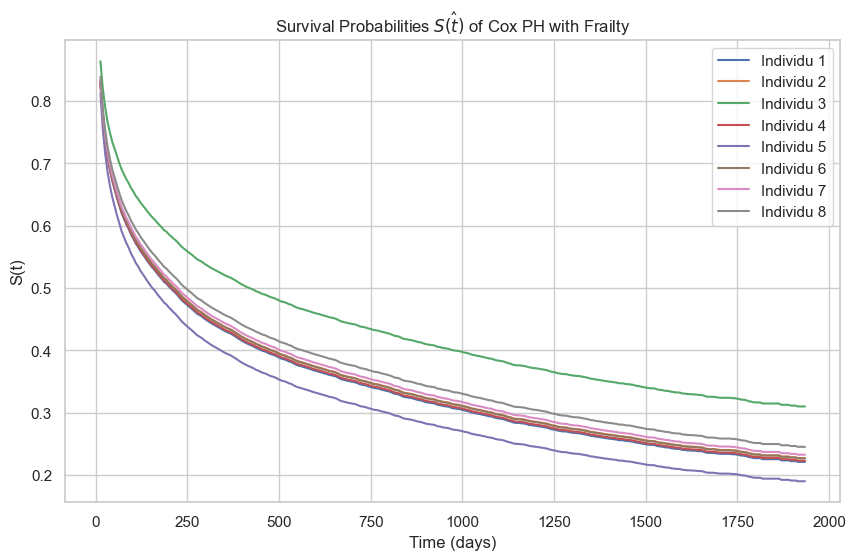

In [365]:
# s'assure que `x3` et `x6` sont bien incluses dans "X_encoded_df"
X_encoded_df = X_encoded_df.copy()
X_encoded_df[['x3', 'x6']] = DS_support[['x3', 'x6']]

# prédiction des fonctions de survie sur l'ensemble de test
coxph_survival_funcs_test = coxph_best.predict_survival_function(X_encoded_df, times=time_grid)

fig, ax = plt.subplots(figsize=(10, 6))
for idx in range(min(8, len(coxph_survival_funcs_test.columns))):  # Limite à 8 courbes pour lisibilité
    # Récupération de la courbe de survie pour chaque instance testée
    survival_curve = coxph_survival_funcs_test.iloc[:, idx]
    ax.plot(time_grid, survival_curve, label=f"Individu {idx+1}")
ax.set(
    title=r"Survival Probabilities $\hat{S(t)}$ of Cox PH with Frailty",
    xlabel="Time (days)",
    ylabel="S(t)"
)
plt.legend()
plt.show()

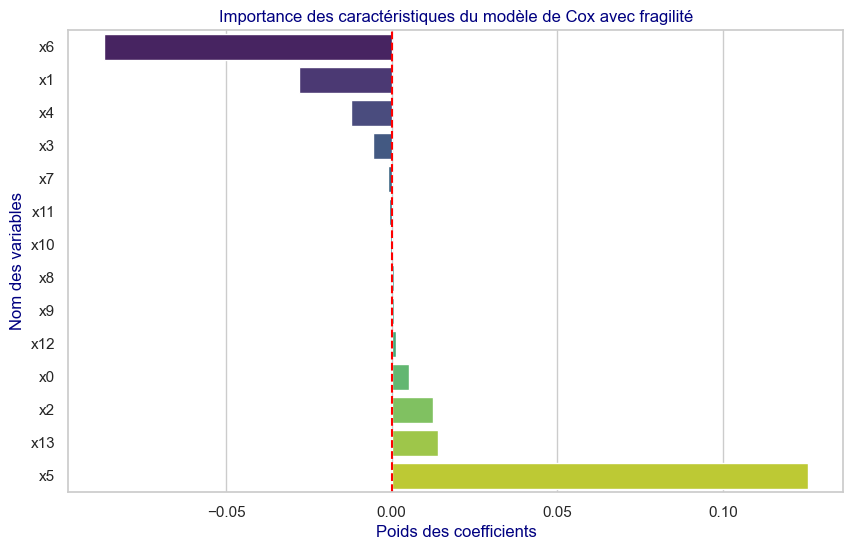

In [366]:
# extrait les coefficients du modèle
feature_importance = pd.DataFrame({
    "feature_name": coxph_best.params_.index,
    "weight": coxph_best.params_.values
}).sort_values(by="weight")

palette = sns.color_palette("viridis", len(feature_importance))
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=feature_importance, y="feature_name", x="weight", orient="h", palette=palette)
ax.axvline(0, color="red", linestyle="--")
ax.set_title("Importance des caractéristiques du modèle de Cox avec fragilité", color = "navy")
ax.set_xlabel("Poids des coefficients", color = "navy")
ax.set_ylabel("Nom des variables", color = "navy")
plt.show()

#### I.b.6. Par un modèle Random Survival Forest

Ce modèle utilise une approche de forêts aléatoires pour estimer les probabilités de survie en fonction des covariables, offrant ainsi une plus grande flexibilité que les modèles vus précédemment. Contrairement à ces modèles, le modèle de forêt aléatoire pour la survie construit de multiples arbres de décision sur des sous-échantillons des données, permettant de capturer des relations non linéaires et des interactions complexes entre les covariables. En agrégeant les prédictions de plusieurs arbres, le modèle random forest présente une capacité de généralisation accrue et s’adapte potentiellement mieux aux effets complexes et aux interactions entre covariables.

In [475]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(
    simple_preprocessor,
    RandomSurvivalForest(n_estimators=10, max_depth=8, n_jobs=-1),
)
rsf.fit(X_train, as_sksurv_recarray(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['x2', 'x3', 'x6']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['x0', 'x1', 'x10', 'x11', 'x12', 'x13', 'x4', 'x5', 'x7', 'x8', 'x9'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomsurvivalforest',
                 RandomSurvivalForest(max_depth=8, n_estimators=10,
                                      n_jobs=-1))])

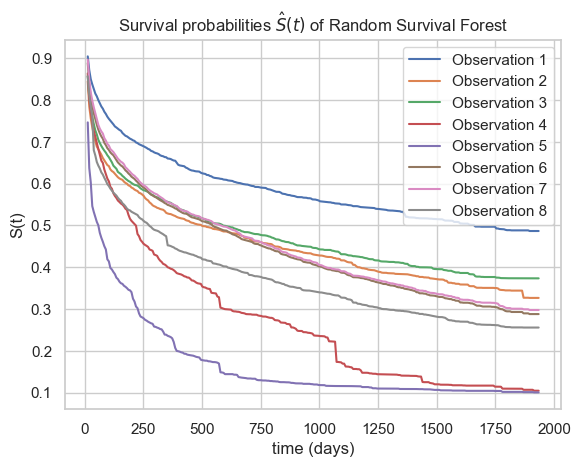

In [476]:
rsf_survival_funcs = rsf.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, survival_func in enumerate(rsf_survival_funcs[:8]):
    survival_curve = survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=f'Observation {idx+1}')
ax.set(
    title=r"Survival probabilities $\hat{S}(t)$ of Random Survival Forest",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend()
plt.show()

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.2844,0.5000,1036.1,686.1,459.3
1,Kaplan-Meier,0.2250,0.5000,1282.4,426.5,461.9
2,Cox PH,0.2029,0.5996,637.9,429.3,450.0
3,Cox PH polynomial,0.1913,0.6379,634.1,438.2,436.7
4,Cox PH avec noyau gaussien (RBF),0.1917,0.6359,634.9,434.9,438.1
5,Random Survival Forest,0.1921,0.6323,648.9,408.2,450.4


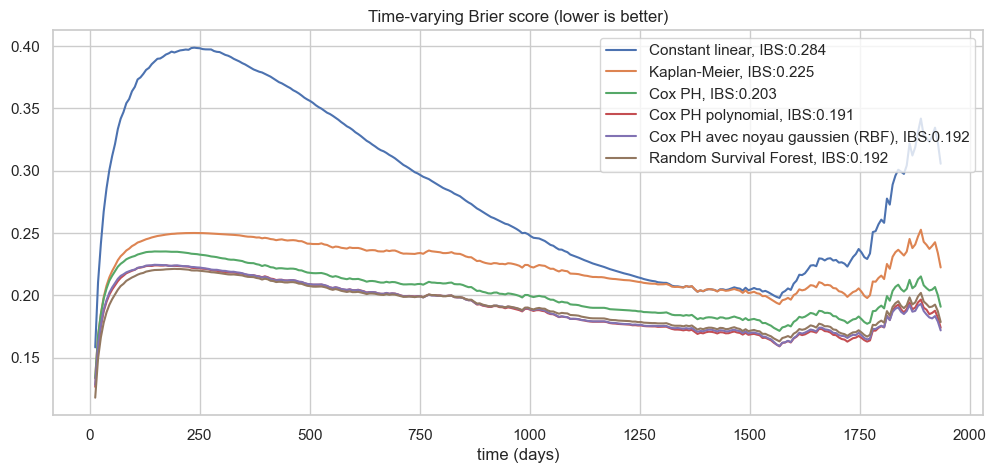

In [477]:
plt.ion()  # Active le mode interactif

rsf_survival_curves = np.vstack(
    [func(time_grid) for func in rsf_survival_funcs]
)
evaluator("Random Survival Forest", rsf_survival_curves)

#### I.b.7. Par un modèle GradientBoosted

Ce modèle utilise une approche de gradient boosting spécifiquement adaptée aux données de survie, en employant des arbres de décision pour estimer la probabilité cumulative d'incidence (Cumulative Incidence Function, CIF) des événements en fonction des covariables. Contrairement aux modèles de Cox traditionnels ou aux forêts aléatoires de survie, le gradient boosting CIF construit chaque arbre de manière séquentielle, en ajustant chaque itération pour corriger les erreurs de prédiction des arbres précédents. Cette méthode contraste donc avec l'approche de la forêt aléatoire, où les arbres sont construits indépendamment. En agrégeant ensuite ses prédictions, cette approche doit permettre de capturer des relations complexes et non linéaires tout en optimisant les performances en ajustant la profondeur des arbres et le taux d'apprentissage.

In [478]:
import sys
# Ajouter le dossier parent de "models" à sys.path
sys.path.append(r"C:\\Users\\vince\\OneDrive\\Documents\\Université PSL\\Université Dauphine - PSL\\Données censurées\\cours")

# Importer les modules depuis le package "models"
from models.gradient_boosted_cif import GradientBoostedCIF
from model_selection.wrappers import PipelineWrapper

# Définir le pipeline pour le modèle GradientBoostedCIF
gb_cif = make_pipeline(
    simple_preprocessor,
    GradientBoostedCIF(n_iter=100, max_leaf_nodes=5, learning_rate=0.1),
)

# Utiliser PipelineWrapper
gb_cif = PipelineWrapper(gb_cif)

# Entraîner le modèle
gb_cif.fit(X_train, y_train, time_grid)

100%|██████████| 100/100 [00:02<00:00, 44.54it/s]


100%|██████████| 300/300 [00:03<00:00, 82.84it/s]


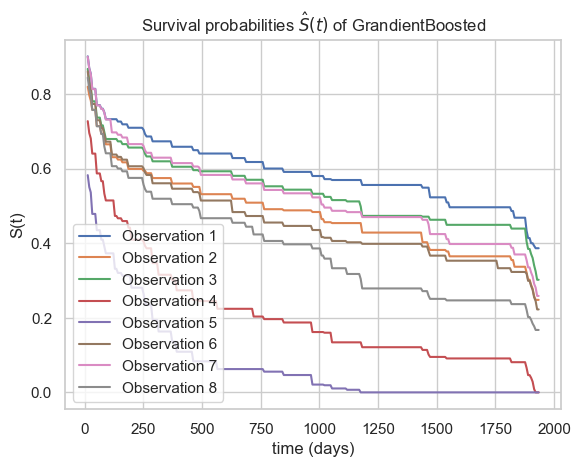

In [481]:
rsf_survival_funcs = gb_cif.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, survival_curve in enumerate(rsf_survival_funcs[:8]):  
    ax.plot(time_grid, survival_curve, label=f'Observation {idx+1}')

# Mise en forme du graphique
ax.set(
    title=r"Survival probabilities $\hat{S}(t)$ of GrandientBoosted",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend()
plt.show()

100%|██████████| 300/300 [00:03<00:00, 82.85it/s]


,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.2844,0.5000,1036.1,686.1,459.3
1,Kaplan-Meier,0.2250,0.5000,1282.4,426.5,461.9
2,Cox PH,0.2029,0.5996,637.9,429.3,450.0
3,Cox PH polynomial,0.1913,0.6379,634.1,438.2,436.7
4,Cox PH avec noyau gaussien (RBF),0.1917,0.6359,634.9,434.9,438.1
5,Random Survival Forest,0.1921,0.6323,648.9,408.2,450.4
6,Gradient Boosting CIF,0.1904,0.6245,814.4,447.2,445.0


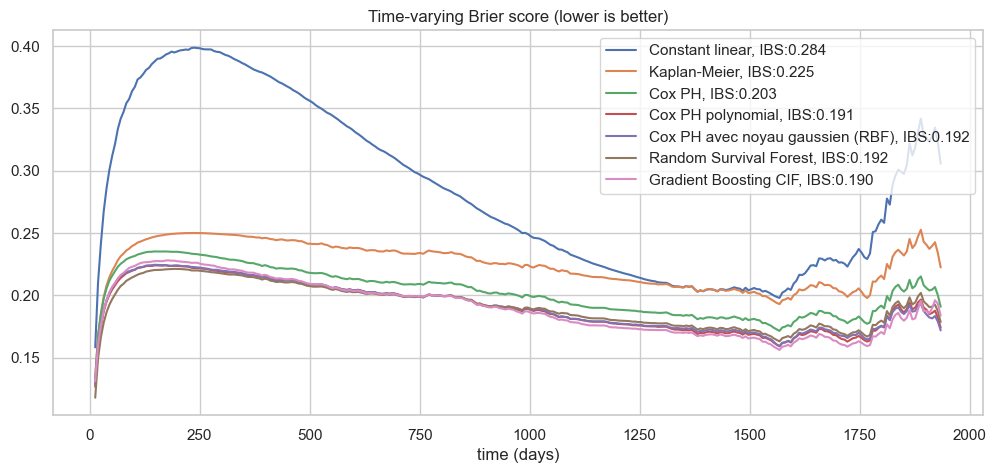

In [480]:
gb_cif_survival_curves = gb_cif.predict_survival_function(X_test, time_grid)
evaluator("Gradient Boosting CIF", gb_cif_survival_curves)

In [351]:
# données des modèles stratifié et avec fragilité
données = [
    ["Modèle de Cox Stratifié", 0.60, 82666.17, 807.42, 528.45, 0.2184, 478.4, 478.3, 478.2],
    ["Modèle de Cox avec Fragilité", 0.57, 103006.61, 177.13, 98.35, 0.2176, 930.0, 416.5, 459.5]
]
en_tête = ["Modèle", "Concordance", "Partial AIC", "Log-Likelihood Ratio Test", "-log2(p) du ll-ratio", "IBS", "MAE for q=0.25", "MAE for q=0.5", "MAE for q=0.75"]

# affichage du tableau
print(tabulate(données, headers=en_tête, tablefmt='fancy_grid', showindex=False))

╒══════════════════════════════╤═══════════════╤═══════════════╤═════════════════════════════╤════════════════════════╤════════╤══════════════════╤═════════════════╤══════════════════╕
│ Modèle                       │   Concordance │   Partial AIC │   Log-Likelihood Ratio Test │   -log2(p) du ll-ratio │    IBS │   MAE for q=0.25 │   MAE for q=0.5 │   MAE for q=0.75 │
╞══════════════════════════════╪═══════════════╪═══════════════╪═════════════════════════════╪════════════════════════╪════════╪══════════════════╪═════════════════╪══════════════════╡
│ Modèle de Cox Stratifié      │          0.6  │       82666.2 │                      807.42 │                 528.45 │ 0.2184 │            478.4 │           478.3 │            478.2 │
├──────────────────────────────┼───────────────┼───────────────┼─────────────────────────────┼────────────────────────┼────────┼──────────────────┼─────────────────┼──────────────────┤
│ Modèle de Cox avec Fragilité │          0.57 │      103007   │           

Le graphique et les tableaux ci-dessus résument les performances obtenues par les modèles testés selon plusieurs critères : l'Integrated Brier Score (IBS), le C-index, et le Mean Absolute Error (MAE) pour des quantiles spécifiques. Les modèles traditionnels (Kaplan-Meier, Cox PH) et les modèles avancés (varainates du modèle de Cox, Random Forest de survie et Gradient Boosting CIF) ont chacun montré des performances distinctes, reflétant leurs capacités à capturer les relations entre les covariables et la probabilité de survie.

Le modèle Kaplan-Meier, avec un IBS de 0.225 et un C-index de 0.5, surpasse légèrement le modèle constant en précision, bien qu'il reste limité dans sa capacité de discrimination. Le modèle de Cox PH classique améliore ces scores avec un IBS de 0.2029 et un C-index de 0.5996, mais il ne capture pas aussi efficacement les relations non linéaires. Les versions améliorées du Cox PH, incluant des termes polynomiaux et des noyaux gaussiens, obtiennent des IBS de 0.1913 et 0.1917, avec des C-index autour de 0.637, montrant leur capacité accrue à capturer des interactions complexes.

Les modèles de machine learning, tels que le Random Survival Forest et le Gradient Boosting CIF, montrent de bonnes performances en modélisant des interactions non linéaires. Le modèle Random Survival Forest présente un IBS de 0.1921 et un C-index de 0.6323, tandis que le Gradient Boosting CIF obtient le meilleur score global avec un IBS de 0.1904 et un C-index de 0.6245. Ces résultats suggèrent que les modèles de boosting sont particulièrement bien adaptés aux données de survie multivariées et complexes.

En parallèle, les modèles de Cox stratifiés et avec fragilité ont également été explorés pour capturer des effets de groupes ou des effets aléatoires. Globalement, le modèle de Cox stratifié offre une meilleure concordance (C-index de 0.6), tandis que le modèle de fragilité semble plus pertinent dans les contextes où des effets aléatoires non observés influencent les résultats.

En somme, les modèles avancés comme le Gradient Boosting CIF et les variantes du Cox PH (polynomial, noyau gaussien) offrent les meilleures performances globales, grâce à leur capacité à capturer des relations non linéaires complexes. Le modèle Random Survival Forest, les modèles de Cox stratifiés et de Cox avec fragilité restent compétitifs et fournissent des approches robustes pour gérer les particularités des données de survie mais n'apporte pas de plus-value majeure dans le cas étudié. Ces résultats soulignent l'importance de l’adaptation des modèles aux spécificités des données pour obtenir des prédictions de survie précises et robustes.

### I.c. Stratégies de modèlisations complémentaires

Dans cette section, il es proposé d'explorer des stratégies de modélisation complémentaires, inspirées en particulier des modèles décrits dans les documents *kkbox_cv_benchmark* et *msk_mettropism*. L’objectif est avant tout d'essayer d'examiner, par curiosité et pour enrichir l'analyse, des modèles alternatifs à ceux abordés en cours afin d'approfondir la compréhension des différentes approches en modélisation de survie. Bien que je ne sois pas certain d’avoir saisi toutes les subtilités de ces modèles, cette exploration vise avant tout à expérimenter de nouvelles méthodes et à évaluer leur potentiel dans le cadre de ce projet.

#### I.c.1. Par un modèle YASGBT

Ce modèle utilise l'approche des Gradient Boosted Trees pour estimer les probabilités de survie, combinant l’efficacité des méthodes de boosting avec la flexibilité des modèles de survie. Contrairement aux modèles traditionnels de Cox ou de Kaplan-Meier, le YASGBTClassifier génère une série d'arbres de décision construits séquentiellement. Chaque arbre apprend à corriger les erreurs des précédents, permettant ainsi de capturer des interactions complexes entre les covariables. En ajustant les prédictions à chaque itération, le modèle YASGBT optimise progressivement ses performances, offrant une précision normalement plus accrue pour estimer les risques de survie dans des contextes de données fortement multivariées.

Ce modèle semble particulièrement adapté aux situations où des interactions non linéaires et des dépendances complexes influencent le risque d’événement. Contrairement à un modèle de Random Forest, qui construit des arbres indépendants pour la robustesse, YASGBT ajuste chaque arbre de façon séquentielle, ce qui semble mieux adapté pour capturer les structures complexes et offrir une généralisation plus marquée pour des données multivariées.

In [352]:
import sys
import warnings
import os
import pandas as pd
import numpy as np
from pathlib import Path
from models.yasgbt import YASGBTClassifier
from model_selection.cross_validation import run_cv
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# filtre les avertissements FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# ajoute le chemin vers vos modèles si nécessaire
sys.path.append(r"C:\\Users\\vince\\OneDrive\\Documents\\Université PSL\\Université Dauphine - PSL\\Données censurées\\cours")

# définit le chemin pour sauvegarder les résultats
def get_path_results():
    path = Path(r"C:\\Users\\vince\\OneDrive\\Documents\\Université PSL\\Université Dauphine - PSL\\Données censurées\\projet\\résultats")
    path.mkdir(parents=True, exist_ok=True)
    return path

# importe "get_path_results" dans le module "cross_validation"
sys.modules['model_selection.cross_validation'].get_path_results = get_path_results

# fonction de découpage avec contrainte de durées
def train_test_split_within(X, y, idx, **kwargs):
    """Assure que les durées du test sont dans la plage des durées de l'entraînement."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    
    return X_train, X_test, y_train, y_test, idx_train, idx_test

# préparation des données d'entrée
X = DS_support.drop(columns=["Unnamed: 0", "Statut_censure"])
y = DS_support[["duration", "event"]] 

# encode les variables catégorielles 'x2', 'x3', et 'x6'
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(), ["x2", "x3", "x6"])],
    remainder="passthrough"
)

# applique l'encodage
X_encoded = preprocessor.fit_transform(X)

# applique la fonction de split sur les données encodées
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X_encoded, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

# conversion des données de survie pour `sksurv`
y_train_surv = Surv.from_dataframe("event", "duration", y_train)
y_test_surv = Surv.from_dataframe("event", "duration", y_test)

# initialisation du modèle YASGBT
yasgbt = YASGBTClassifier(
    sampling_strategy="uniform",
    n_iter=50,
    show_progressbar=False,
)

# exécution de la validation croisée sur le jeu d'entraînement
run_cv(X_train, y_train_surv, yasgbt)

print("Chemin de sauvegarde des résultats :", get_path_results())

train set: 1774, val set: 444
train set: 1774, val set: 444
train set: 1774, val set: 444
train set: 1775, val set: 443
train set: 1775, val set: 442
--------
ibs: 0.0100 ± 0.0010
c_index: 0.9259 ± 0.0155
training_duration: 0.3802 ± 0.0209
prediction_duration: 0.0715 ± 0.0065
Chemin de sauvegarde des résultats : C:\Users\vince\OneDrive\Documents\Université PSL\Université Dauphine - PSL\Données censurées\projet\résultats


#### I.c.2. Par un modèle XGBoost Survival Embeddings (XGBSE)

Ce modèle utilise une approche de gradient boosting, spécifiquement optimisée pour les données de survie, en s'appuyant sur la technique de dé-biased binary cross-entropy (Debiased BCE) de l’algorithme XGBoost Survival Embeddings (XGBSE). Contrairement aux modèles de Cox traditionnels ou aux modèles basés sur des forêts aléatoires de survie, le XGBSEDebiasedBCE construit une série d'arbres de décision séquentiels qui visent à minimiser une fonction de coût adaptée à la survie en temps, ici une version ajustée de l'entropie binaire. Contrairement aux modèles de survie en forêt aléatoire, qui construisent des arbres indépendants pour la robustesse, XGBSE utilise un boosting séquentiel où chaque itération affine les prédictions des arbres précédents pour mieux capturer les interactions complexes et non linéaires entre les covariables. Sa configuration semble conçue pour optimiser la précision des prédictions tout en minimisant les erreurs des itérations précédentes. 

In [353]:
import os
import sys
import warnings  
import pandas as pd
import numpy as np
from xgbse import XGBSEDebiasedBCE
from model_selection.cross_validation import run_cv
from model_selection.wrappers import XGBSEWrapper
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# filtre les avertissements FutureWarning spécifiques à xgbse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgbse")

# définit le chemin pour sauvegarder les résultats
os.environ["PYCOX_DATA_DIR"] = "C:/Users/vince/OneDrive/Documents/Université PSL/Université Dauphine - PSL/Données censurées/cours/results"

# fonction de découpage avec contrainte de durées
def train_test_split_within(X, y, idx, **kwargs):
    """Assure que les durées du test sont dans la plage des durées de l'entraînement."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    
    return X_train, X_test, y_train, y_test, idx_train, idx_test

# préparation des données d'entrée
X = DS_support.drop(columns=["Unnamed: 0", "Statut_censure"])
y = DS_support[["duration", "event"]]

# OneHotEncoder pour les variables 'x2', 'x3' et 'x6'
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(), ["x2", "x3", "x6"])],
    remainder="passthrough"  # Conserver les autres colonnes
)

# applique l'encodage
X_encoded = preprocessor.fit_transform(X)

# applique la fonction de split sur les données encodées
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X_encoded, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

# conversion des données de survie pour `sksurv`
y_train_surv = Surv.from_dataframe("event", "duration", y_train)
y_test_surv = Surv.from_dataframe("event", "duration", y_test)

# définit les paramètres pour le modèle DebiasedBCE de XGBSE
PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}

# initialise le modèle
xgbse_bce_cox = XGBSEDebiasedBCE(PARAMS_TREE_COX, n_jobs=4)

# configuration pour l'entraînement
fit_kwargs = {
    "num_boost_round": 30,
    "verbose_eval": 5, 
}

# enveloppe le modèle
xgbse_bce_cox = XGBSEWrapper(xgbse_bce_cox, fit_kwargs=fit_kwargs)
xgbse_bce_cox.name = "MSK_XGBSE_Debiased_BCE" 

# Exécute la validation croisée sur le jeu d'entraînement
run_cv(X_train, y_train_surv, xgbse_bce_cox)

train set: 1774, val set: 444
train set: 1774, val set: 444
train set: 1774, val set: 444
train set: 1775, val set: 443
train set: 1775, val set: 442
--------
ibs: 0.0030 ± 0.0010
c_index: 0.8397 ± 0.0121
training_duration: 0.7044 ± 0.6958
prediction_duration: 0.0504 ± 0.0026


#### I.c.3. Par un modèle XGBSE Kaplan Tree

Ce modèle utilise une approche de KaplanTree pour estimer les probabilités de survie en fonction des covariables, en combinant des arbres de décision et l'estimation de Kaplan-Meier. Le KaplanTree segmente les données en sous-groupes en construisant des arbres de décision. Contrairement aux modèles précédants, le KaplanTree semble construire chaque arbre indépendamment et appliquer une estimation de Kaplan-Meier pour chaque feuille de l'arbre. Dans chaque segment, une estimation de survie de Kaplan-Meier est appliquée, ce qui permet d’obtenir une prédiction spécifique pour chaque sous-groupe de données. Cette méthode semble donc particulièrement adaptée pour capturer des effets de survie propres à chaque sous-groupe, sans hypothèse de proportionnalité des risques.

In [354]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
from xgbse import XGBSEKaplanTree
from model_selection.cross_validation import run_cv
from model_selection.wrappers import XGBSEWrapper
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# filtre les avertissements FutureWarning spécifiques à xgbse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgbse")

# définit les options de pandas pour réduire les avertissements
pd.set_option('future.no_silent_downcasting', True)

# défini le chemin pour sauvegarder les résultats
os.environ["PYCOX_DATA_DIR"] = "C:/Users/vince/OneDrive/Documents/Université PSL/Université Dauphine - PSL/Données censurées/cours/results"

# fonction de découpage avec contrainte de durées
def train_test_split_within(X, y, idx, **kwargs):
    """Assure que les durées du test sont dans la plage des durées de l'entraînement."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    
    return X_train, X_test, y_train, y_test, idx_train, idx_test

# préparation des données d'entrée
X = DS_support.drop(columns=["Unnamed: 0", "Statut_censure"])
y = DS_support[["duration", "event"]]

# OneHotEncoder pour les variables 'x2', 'x3' et 'x6'
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(), ["x2", "x3", "x6"])],
    remainder="passthrough"  # Conserver les autres colonnes
)

# applique l'encodage
X_encoded = preprocessor.fit_transform(X)

# applique la fonction de split sur les données encodées
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X_encoded, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

# conversion des données de survie pour `sksurv`
y_train_surv = Surv.from_dataframe("event", "duration", y_train)
y_test_surv = Surv.from_dataframe("event", "duration", y_test)

# définit les paramètres pour le modèle KaplanTree de XGBSE
PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}

# initialise le modèle
xgbse_kaplan_tree = XGBSEKaplanTree(PARAMS_TREE_COX)

# configuration pour l'entraînement
fit_kwargs = {"persist_train": False}
xgbse_wrapper = XGBSEWrapper(xgbse_kaplan_tree, fit_kwargs=fit_kwargs)

# exécute la validation croisée sur le jeu d'entraînement
run_cv(X_train, y_train_surv, xgbse_wrapper)

train set: 1774, val set: 444
train set: 1774, val set: 444
train set: 1774, val set: 444
train set: 1775, val set: 443
train set: 1775, val set: 442
--------
ibs: 0.0108 ± 0.0016
c_index: 0.9538 ± 0.0055
training_duration: 0.0478 ± 0.0032
prediction_duration: 0.0187 ± 0.0018


#### I.c.4. Par un modèle MetaGridBC 

Ce modèle semble adopter une approche de méta-classification, donc entraîné pour combiner ou améliorer les prédictions de plusieurs modèles de base, pour la survie en utilisant une combinaison de modèles de classification et des techniques d'optimisation spécifiques aux données de survie. Le MetaGridBC emploie un classifieur pour évaluer les risques de manière itérative. Il utilise une grille de paramètres pour optimiser la classification en fonction des durées et événements observés, permettant une grande flexibilité pour s'adapter aux données.

In [355]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
from sksurv.util import Surv
from model_selection.cross_validation import run_cv
from models.meta_grid_bc import MetaGridBC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# ajoute le dossier parent de "models" à sys.path
sys.path.append(r"C:\\Users\\vince\\OneDrive\\Documents\\Université PSL\\Université Dauphine - PSL\\Données censurées\\cours")

# filtre les avertissements FutureWarning spécifiques
warnings.filterwarnings("ignore", category=FutureWarning)

# fonction de découpage avec contrainte de durées
def train_test_split_within(X, y, idx, **kwargs):
    """Assure que les durées du test sont dans la plage des durées de l'entraînement."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    
    return X_train, X_test, y_train, y_test, idx_train, idx_test

# préparation des données d'entrée
X = DS_support.drop(columns=["Unnamed: 0", "Statut_censure"])
y = DS_support[["duration", "event"]]

# OneHotEncoder pour les variables 'x2', 'x3' et 'x6'
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(), ["x2", "x3", "x6"])],
    remainder="passthrough"  # Conserver les autres colonnes
)

# applique l'encodage
X_encoded = preprocessor.fit_transform(X)

# applique la fonction de split sur les données encodées
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X_encoded, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

# conversion des données de survie pour `sksurv`
y_train_surv = Surv.from_dataframe("event", "duration", y_train)
y_test_surv = Surv.from_dataframe("event", "duration", y_test)

# initialisation du modèle MetaGridBC
meta_grid_bc = MetaGridBC(classifier=LogisticRegression(), n_jobs=-1, verbose=1)

# exécution de la validation croisée sur le jeu d'entraînement
run_cv(X_train, y_train_surv, meta_grid_bc)

print("Validation croisée terminée.")

train set: 1774, val set: 444


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


train set: 1774, val set: 444


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


train set: 1774, val set: 444


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


train set: 1775, val set: 443


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


train set: 1775, val set: 442


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


--------
ibs: 0.0072 ± 0.0016
c_index: 0.9958 ± 0.0003
training_duration: 1.0722 ± 1.5063
prediction_duration: 0.3032 ± 0.0096
Validation croisée terminée.


In [356]:
# données des résultats pour chaque modèle
data = {
    "Model": ["YASGBT", "XGBSE DebiasedBCE", "XGBSE KaplanTree", "MetaGridBC"],
    "IBS": [0.0100, 0.0030, 0.0108, 0.0072],
    "IBS Std": [0.0010, 0.0010, 0.0016, 0.0016],
    "C-Index": [0.9259, 0.8397, 0.9538, 0.9958],
    "C-Index Std": [0.0155, 0.0121, 0.0055, 0.0003],
    "Training Duration": [0.3802, 0.7044, 0.0478, 1.0722],
    "Training Duration Std": [0.0209, 0.6958, 0.0032, 1.5063],
    "Prediction Duration": [0.0715, 0.0504, 0.0187, 0.3032],
    "Prediction Duration Std": [0.0065, 0.0026, 0.0018, 0.0096],
}

results_df = pd.DataFrame(data)

print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════╤═══════════╤═══════════╤═══════════════╤═════════════════════╤═════════════════════════╤═══════════════════════╤═══════════════════════════╕
│ Model             │    IBS │   IBS Std │   C-Index │   C-Index Std │   Training Duration │   Training Duration Std │   Prediction Duration │   Prediction Duration Std │
╞═══════════════════╪════════╪═══════════╪═══════════╪═══════════════╪═════════════════════╪═════════════════════════╪═══════════════════════╪═══════════════════════════╡
│ YASGBT            │ 0.01   │    0.001  │    0.9259 │        0.0155 │              0.3802 │                  0.0209 │                0.0715 │                    0.0065 │
├───────────────────┼────────┼───────────┼───────────┼───────────────┼─────────────────────┼─────────────────────────┼───────────────────────┼───────────────────────────┤
│ XGBSE DebiasedBCE │ 0.003  │    0.001  │    0.8397 │        0.0121 │              0.7044 │                  0.6958 │                0.0504 │   

En supposant l'absence d'erreur d'implémentation de ces modèles, les résultats comparatifs des modèles affichent des performances très supérieures aux modèles utilisés précédemment. 

Ils indiquent que le modèle MetaGridBC se démarque par le meilleur c-index, indiquant une précision élevée pour distinguer les événements. Cependant, son score IBS de 0.0072, bien que bon, n’est pas le plus bas, laissant une légère marge d’amélioration dans l’estimation de survie. XGBSE KaplanTree présente un excellent compromis avec un c-index de 0.9538 et un IBS de 0.0108, tandis que le YASGBT et XGBSE DebiasedBCE montrent des scores IBS compétitifs mais des c-index moins élevés.

S'agissant de la durée, MetaGridBC est le modèle le plus exigeant avec un temps d'entraînement moyen d'environ 1 seconde, supérieur aux autres modèles. XGBSE KaplanTree est le plus rapide à s’entraîner, avec une durée moyenne de 0.0478, et reste très performant. Le YASGBT et XGBSE DebiasedBCE offrent des temps d'entraînement intermédiaires tout en conservant des scores raisonnables, faisant d'eux des choix équilibrés entre performance et efficacité temporelle.

Ces résultats soulignent que le choix du modèle dépend également en partie du compromis souhaité entre la précision des prédictions et l'efficacité computationnelle. MetaGridBC semble être un excellent choix pour maximiser la précision (c-index) lorsque le temps n'est pas une contrainte prioritaire, tandis que XGBSE KaplanTree propose une alternative rapide et précise, adaptée aux contextes où le temps de calcul est limité.

## II. Jeu de données complémentaire

Cette seconde partie propose d’explorer un jeu de données complémentaire, axé sur l’analyse de la durée de vie restante (Remaining Useful Life, RUL) dans le cadre de la maintenance prédictive de moteurs de turboréacteurs. Ce jeu de données, fourni par le centre de Pronostics de la NASA Ames, est basé sur des simulations de dégradation « Run-to-Failure » réalisées avec le simulateur C-MAPSS. Le lien est disponible au document [3] des documents de référence. Ce jeu de données comprend quatre ensembles simulant différentes combinaisons de conditions opérationnelles et modes de panne, et l’objectif est de prédire le RUL, soit le nombre de cycles de vol restant pour chaque moteur.

Il ne s'agit pas ici d'une étude formelle, appliquée et complète du jeu de données, mais plutôt de créer un cadre expérimental qui permet d'explorer des scénarios de données censurées avec plusieurs types d'événements. Etant donné que le jeu de données de base ne comporte ni panne ni censure, une première étape consiste à transformer les données, en générant notamment des événements censurés et non censurés ainsi que différents types de pannes, pour les rendre exploitables avec la fonction d’incidence cumulée (CIF, Cumulative Incidence Function). Contrairement aux modèles binaires précédemment utilisés, la CIF permet de modéliser la probabilité de survenue de différents types d'événements concurrents au fil du temps.

L’objectif de cette partie est donc d'expérimenter des modèles complémentaires à ceux utilisés précédemment - principalement Kaplan-Meier, Cox PH et leurs variantes - qui étaient conçus pour des données censurées avec des événements binaires : censure ou occurrence. Ces modèles présentent dès lors des limites lorsqu'il s'agit d'étudier des événements de nature variée. Cette exploration vise à essayer de tester des approches alternatives adaptées à la gestion de plusieurs types d'événements concurrents, afin d'enrichir la compréhension des différences analytiques et d'élargir l'étude du cadre des méthodes disponibles.

### II.a. Importation et structuration du jeu de données

Dans cette section, le jeu de données, nommé « DS_Turbofan », est préalablement mis en forme et assorti de points de contrôle.

In [171]:
# définit le chemin du dossier contenant les fichiers
DS_Turbofan  = r'C:\Users\vince\OneDrive\Documents\Université PSL\Université Dauphine - PSL\Données censurées\projet\CMaps'

# liste les fichiers dans le répertoire
files = os.listdir(DS_Turbofan)

# initialise des listes pour les DataFrames
train_Turbofan  = []
test_Turbofan  = []

# charge les fichiers d'entraînement et de test
for file in files:
    if 'train' in file: 
        df = pd.read_csv(os.path.join(DS_Turbofan, file), sep='\s+', header=None)
        train_Turbofan.append(df)
    elif 'test' in file: 
        df = pd.read_csv(os.path.join(DS_Turbofan, file), sep='\s+', header=None)
        test_Turbofan.append(df)

# combine tous les DataFrames en un seul
train_data = pd.concat(train_Turbofan, ignore_index=True)
test_data = pd.concat(test_Turbofan, ignore_index=True)

# affiche les premières lignes des données chargées
print('Données d\'entraînement :')
print(train_data.head())
print('\nDonnées de test :')
print(test_data.head())

<>:14: SyntaxWarning:

invalid escape sequence '\s'

<>:17: SyntaxWarning:

invalid escape sequence '\s'

<>:14: SyntaxWarning:

invalid escape sequence '\s'

<>:17: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\vince\AppData\Local\Temp\ipykernel_59444\669869906.py:14: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\vince\AppData\Local\Temp\ipykernel_59444\669869906.py:17: SyntaxWarning:

invalid escape sequence '\s'



Données d'entraînement :
   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      16       17       18      19    20   21    22     23     24  \
0  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

        25  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.373

In [172]:
# affiche des informations sur les données d'entraînement
print('Informations sur les données d\'entraînement :')
print(train_data.info())

# affiche des informations sur les données de test
print('\nInformations sur les données de test :')
print(test_data.info())

Informations sur les données d'entraînement :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       160359 non-null  int64  
 1   1       160359 non-null  int64  
 2   2       160359 non-null  float64
 3   3       160359 non-null  float64
 4   4       160359 non-null  float64
 5   5       160359 non-null  float64
 6   6       160359 non-null  float64
 7   7       160359 non-null  float64
 8   8       160359 non-null  float64
 9   9       160359 non-null  float64
 10  10      160359 non-null  float64
 11  11      160359 non-null  float64
 12  12      160359 non-null  float64
 13  13      160359 non-null  float64
 14  14      160359 non-null  float64
 15  15      160359 non-null  float64
 16  16      160359 non-null  float64
 17  17      160359 non-null  float64
 18  18      160359 non-null  float64
 19  19      160359 non-null  float64
 20  20

In [173]:
# crée la liste des noms de colonnes
column_names = [
    'engine', 'cycle', 'setting_1', 'setting_2', 'setting_3',
    '(Fan inlet temperature) (°R)',
    '(LPC outlet temperature) (°R)',
    '(HPC outlet temperature) (°R)',
    '(LPT outlet temperature) (°R)',
    '(Fan inlet Pressure) (psia)',
    '(bypass-duct pressure) (psia)',
    '(HPC outlet pressure) (psia)',
    '(Physical fan speed) (rpm)',
    '(Physical core speed) (rpm)',
    '(Engine pressure ratio(P50/P2)',
    '(HPC outlet Static pressure) (psia)',
    '(Ratio of fuel flow to Ps30) (pps/psia)',
    '(Corrected fan speed) (rpm)',
    '(Corrected core speed) (rpm)',
    '(Bypass Ratio)',
    '(Burner fuel-air ratio)',
    '(Bleed Enthalpy)',
    '(Required fan speed)',
    '(Required fan conversion speed)',
    '(High-pressure turbines Cool air flow)',
    '(Low-pressure turbines Cool air flow)'
]

# assure que la longueur de la liste des noms de colonnes = au nombre de colonnes
print(f"Nombre de colonnes dans train_data : {train_data.shape[1]}")
print(f"Nombre de noms de colonnes dans column_names : {len(column_names)}")

# ajoute les noms de colonnes aux DataFrames s'ils correspondent en nombre
if train_data.shape[1] == len(column_names):
    train_data.columns = column_names
    test_data.columns = column_names

    # vérifie les premières lignes des données
    print('Données d\'entraînement :')
    print(train_data.head())
    print('\nDonnées de test :')
    print(test_data.head())
else:
    print("Le nombre de colonnes dans le DataFrame ne correspond pas au nombre de noms spécifiés dans 'column_names'. Veuillez vérifier les colonnes.")

Nombre de colonnes dans train_data : 26
Nombre de noms de colonnes dans column_names : 26
Données d'entraînement :
   engine  cycle  setting_1  setting_2  setting_3  \
0       1      1    -0.0007    -0.0004      100.0   
1       1      2     0.0019    -0.0003      100.0   
2       1      3    -0.0043     0.0003      100.0   
3       1      4     0.0007     0.0000      100.0   
4       1      5    -0.0019    -0.0002      100.0   

   (Fan inlet temperature) (°R)  (LPC outlet temperature) (°R)  \
0                        518.67                         641.82   
1                        518.67                         642.15   
2                        518.67                         642.35   
3                        518.67                         642.35   
4                        518.67                         642.37   

   (HPC outlet temperature) (°R)  (LPT outlet temperature) (°R)  \
0                        1589.70                        1400.60   
1                        1591.82   

In [174]:
# affiche la liste des colonnes train_data
print("Colonnes actuelles de train_data :")
print(train_data.columns)

Colonnes actuelles de train_data :
Index(['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3',
       '(Fan inlet temperature) (°R)', '(LPC outlet temperature) (°R)',
       '(HPC outlet temperature) (°R)', '(LPT outlet temperature) (°R)',
       '(Fan inlet Pressure) (psia)', '(bypass-duct pressure) (psia)',
       '(HPC outlet pressure) (psia)', '(Physical fan speed) (rpm)',
       '(Physical core speed) (rpm)', '(Engine pressure ratio(P50/P2)',
       '(HPC outlet Static pressure) (psia)',
       '(Ratio of fuel flow to Ps30) (pps/psia)',
       '(Corrected fan speed) (rpm)', '(Corrected core speed) (rpm)',
       '(Bypass Ratio)', '(Burner fuel-air ratio)', '(Bleed Enthalpy)',
       '(Required fan speed)', '(Required fan conversion speed)',
       '(High-pressure turbines Cool air flow)',
       '(Low-pressure turbines Cool air flow)'],
      dtype='object')


In [175]:
# ajoute les noms de colonnes aux DataFrames
train_data.columns = column_names
test_data.columns = column_names

# Vérifie les premières lignes des données 
print('Données d\'entraînement :')
print(train_data.head())
print('\nDonnées de test :')
print(test_data.head())

Données d'entraînement :
   engine  cycle  setting_1  setting_2  setting_3  \
0       1      1    -0.0007    -0.0004      100.0   
1       1      2     0.0019    -0.0003      100.0   
2       1      3    -0.0043     0.0003      100.0   
3       1      4     0.0007     0.0000      100.0   
4       1      5    -0.0019    -0.0002      100.0   

   (Fan inlet temperature) (°R)  (LPC outlet temperature) (°R)  \
0                        518.67                         641.82   
1                        518.67                         642.15   
2                        518.67                         642.35   
3                        518.67                         642.35   
4                        518.67                         642.37   

   (HPC outlet temperature) (°R)  (LPT outlet temperature) (°R)  \
0                        1589.70                        1400.60   
1                        1591.82                        1403.14   
2                        1587.99                        14

In [176]:
def add_RUL_column(df):
    # groupe par 'engine' et trouve le nombre maximum de cycles pour chaque unité
    train_grouped_by_unit = df.groupby(by='engine')
    max_time_cycles = train_grouped_by_unit['cycle'].max()

    # fusionne pour ajouter la colonne 'max_time_cycle' à chaque ligne correspondant à une unité
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='engine', right_index=True)

    # calcule la RUL pour chaque ligne
    merged["RUL"] = merged["max_time_cycle"] - merged['cycle']

    # supprime la colonne 'max_time_cycle' car elle n'est plus nécessaire
    merged = merged.drop("max_time_cycle", axis=1)

    return merged

# applique la fonction au jeu d'entraînement
train_data = add_RUL_column(train_data)

# affiche les premières lignes pour vérifier le résultat
print(train_data[['engine', 'RUL']].head())

   engine  RUL
0       1  320
1       1  319
2       1  318
3       1  317
4       1  316


In [177]:
# calcule le RUL maximum par unité
maxrul_u = train_data.groupby('engine')['RUL'].max().reset_index()
print(maxrul_u.head())

   engine  RUL
0       1  320
1       2  298
2       3  306
3       4  273
4       5  268


In [178]:
# affiche la liste des colonnes train_data
print("Colonnes actuelles de train_data :")
print(train_data.columns)

Colonnes actuelles de train_data :
Index(['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3',
       '(Fan inlet temperature) (°R)', '(LPC outlet temperature) (°R)',
       '(HPC outlet temperature) (°R)', '(LPT outlet temperature) (°R)',
       '(Fan inlet Pressure) (psia)', '(bypass-duct pressure) (psia)',
       '(HPC outlet pressure) (psia)', '(Physical fan speed) (rpm)',
       '(Physical core speed) (rpm)', '(Engine pressure ratio(P50/P2)',
       '(HPC outlet Static pressure) (psia)',
       '(Ratio of fuel flow to Ps30) (pps/psia)',
       '(Corrected fan speed) (rpm)', '(Corrected core speed) (rpm)',
       '(Bypass Ratio)', '(Burner fuel-air ratio)', '(Bleed Enthalpy)',
       '(Required fan speed)', '(Required fan conversion speed)',
       '(High-pressure turbines Cool air flow)',
       '(Low-pressure turbines Cool air flow)', 'RUL'],
      dtype='object')


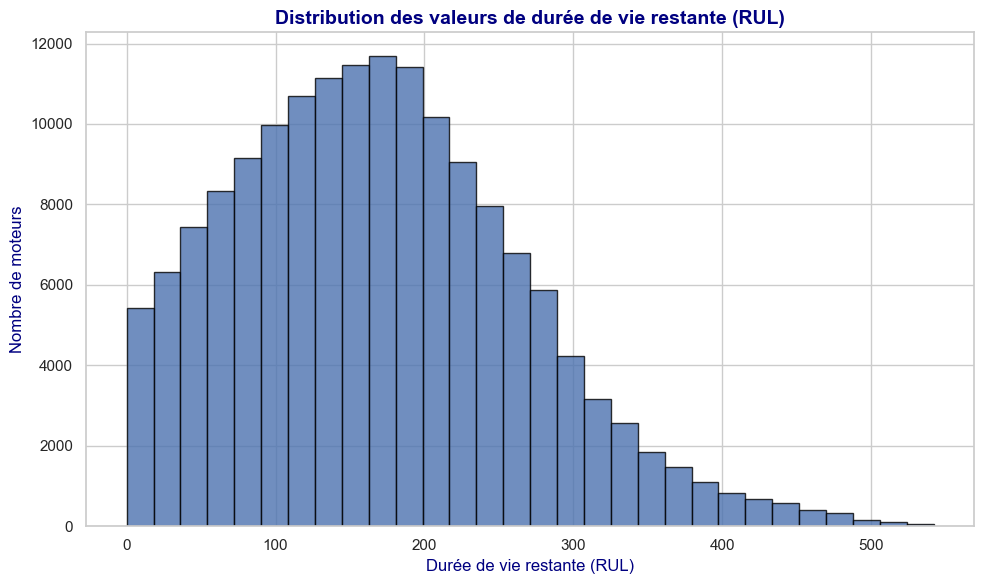

In [261]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6)) 
plt.hist(
    train_data['RUL'], 
    bins=30, 
    edgecolor='black', 
    color='#4c72b0',
    alpha=0.8 
)
plt.xlabel('Durée de vie restante (RUL)', fontsize=12, color = "navy")  
plt.ylabel('Nombre de moteurs', fontsize=12, color = "navy")  
plt.title('Distribution des valeurs de durée de vie restante (RUL)', fontsize=14, fontweight='bold', color = "navy")
plt.tight_layout()
plt.show()

In [180]:
# calcule les quartiles pour les valeurs de RUL
quantiles = train_data['RUL'].quantile([0.25, 0.5, 0.75])
print(quantiles)

0.25     97.0
0.50    163.0
0.75    230.0
Name: RUL, dtype: float64


In [181]:
show(train_data)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\vince\AppData\Local\Temp\ipykernel_59444\2161184459.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\vince\AppData\Local\Temp\ipykernel_59444\2161184459.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\vince\AppData\Local\Temp\ipykernel_59444\2161184459.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\vince\AppData\Local\Temp\ipykernel_59

### II.b. Génération de censures et d'événements concurrents de différents types

Dans cette seconde section, la première étape propose d'identifier les caractéristiques les plus influentes pour prédire la durée de vie restante (RUL) des moteurs. Pour ce faire, un modèle de forêt aléatoire est entraîné, en utilisant toutes les variables explicatives disponibles, à l’exception des identifiants de moteur, du cycle, du RUL, et des colonnes de censure. Ce modèle vise à calculer l'importance de chaque caractéristique et ainsi de sélectionner les douze variables ayant le plus d’influence sur la RUL. Ces caractéristiques sont alors retenues pour les étapes suivantes de l’analyse, car elles représentent les éléments les plus pertinents dans la prévision de l’état de dégradation des moteurs.

Ensuite, pour structurer les moteurs en groupes similaires, une étape de clustering est appliquée sur les caractéristiques importantes retenues. Cette étape utilise l’algorithme de K-Means pour segmenter les moteurs en trois clusters distincts, chacun caractérisé par des moyennes différentes sur les caractéristiques influentes. En regroupant ainsi les moteurs, il est envisagé de détecter des schémas de dégradation similaires et de représenter chaque groupe par des profils spécifiques. Ces clusters facilitent également la création de types d'événements distincts, chacun correspondant à des probabilités de panne et de survie uniques, en fonction des caractéristiques de chaque cluster.

Pour introduire la censure dans les données, il est ensuite proposé d'ajuster une loi de Weibull aux valeurs de RUL. Cette distribution statistique est choisie car elle est couramment citée dans la littérature pour modéliser les durées de vie, notamment en ingénierie de fiabilité. À partir de la loi de Weibull ajustée, des probabilités de panne sont calculées pour chaque moteur, offrant une première estimation du risque de défaillance. Cependant, afin de mieux adapter ces probabilités aux spécificités des moteurs, elles sont ajustées en fonction des caractéristiques importantes : un facteur d’ajustement est appliqué aux moteurs présentant des valeurs élevées sur certaines caractéristiques influentes. Cela permet de simuler une situation où les moteurs plus vulnérables (ayant des caractéristiques dépassant certains seuils) ont des risques de panne plus élevés. Enfin, une censure est générée en fonction des probabilités ajustées pour obtenir une répartition plus représentative des événements observés et censurés. En fixant un seuil de probabilité, chaque moteur est soit censuré, soit associé à un événement de panne observé. Cette méthode espère ainsi créer un jeu de données plutôt réaliste, où tous les moteurs n’atteignent pas forcément la panne observée, certains étant censurés en fonction de leur risque individuel. Cela donne lieu à un ensemble de données enrichi et adapté aux analyses de survie, en particulier pour l’exploration de modèles CIF, permettant de différencier les types de défaillances en fonction des clusters obtenus, constitue l'objectif final de cette seconde partie.

Caractéristiques sélectionnées : ['setting_1', 'setting_2', 'setting_3', '(Fan inlet temperature) (°R)', '(LPC outlet temperature) (°R)', '(HPC outlet temperature) (°R)', '(LPT outlet temperature) (°R)', '(Fan inlet Pressure) (psia)', '(bypass-duct pressure) (psia)', '(HPC outlet pressure) (psia)', '(Physical fan speed) (rpm)', '(Physical core speed) (rpm)', '(Engine pressure ratio(P50/P2)', '(HPC outlet Static pressure) (psia)', '(Ratio of fuel flow to Ps30) (pps/psia)', '(Corrected fan speed) (rpm)', '(Corrected core speed) (rpm)', '(Bypass Ratio)', '(Burner fuel-air ratio)', '(Bleed Enthalpy)', '(Required fan speed)', '(Required fan conversion speed)', '(High-pressure turbines Cool air flow)', '(Low-pressure turbines Cool air flow)', 'cluster']


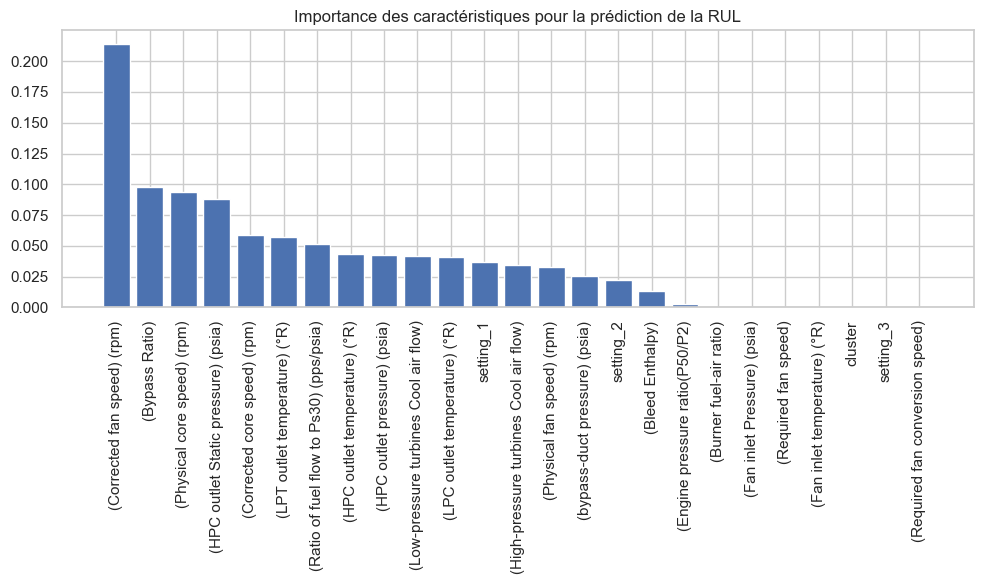

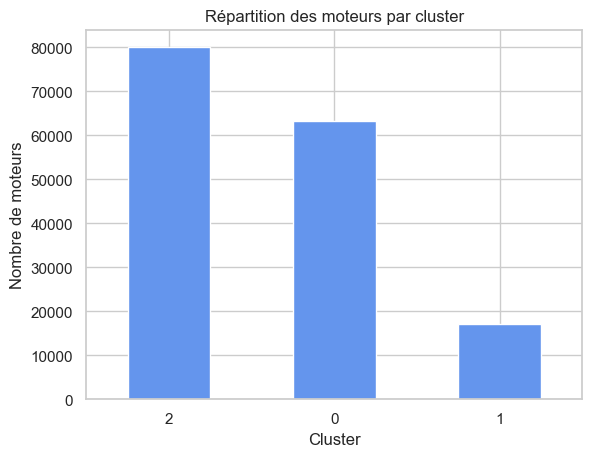

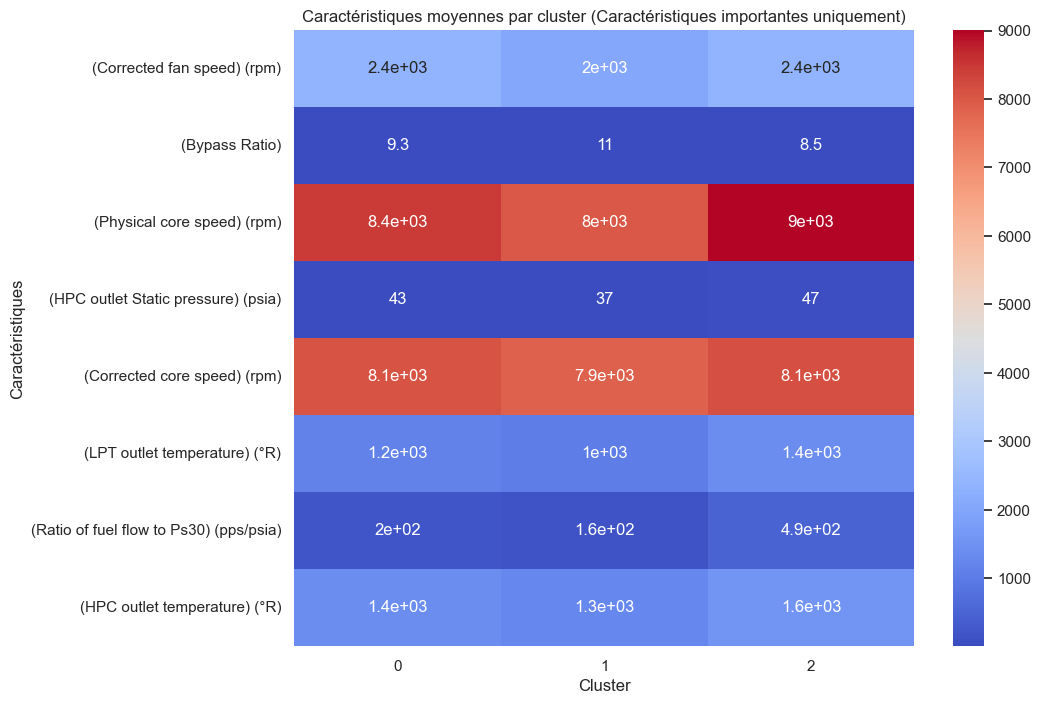

censored_weibull
0    98964
1    61395
Name: count, dtype: int64


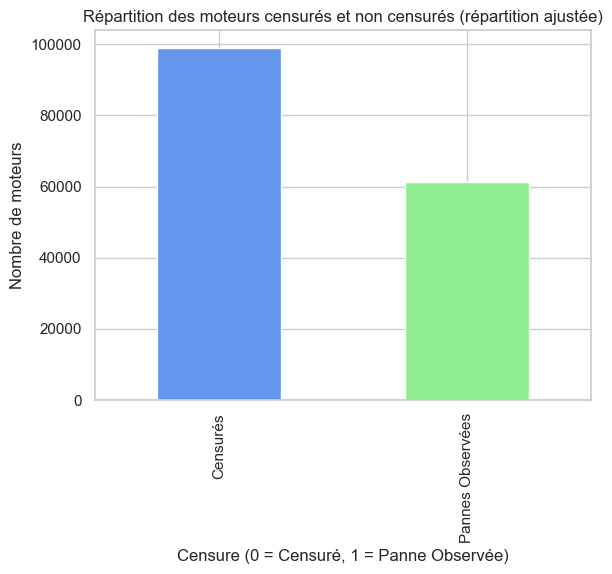

In [194]:
# 1re étape : utilise Random Forest pour identifier les caractéristiques importantes
# définit les colonnes qui seront utilisées comme caractéristiques pour l'entraînement
features = [col for col in train_data.columns if col not in ['engine', 'cycle', 'RUL', 'censored_weibull']]

# vérifie les caractéristiques sélectionnées
print("Caractéristiques sélectionnées :", features)

# sépare les caractéristiques et la variable cible
X = train_data[features]
y = train_data['RUL']

# entraîne un modèle de forêt aléatoire en utilisant 12 cœurs
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=12)
model.fit(X, y)

# extrait l'importance des caractéristiques
importances = model.feature_importances_

# visualise l'importance des caractéristiques
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.title("Importance des caractéristiques pour la prédiction de la RUL")
plt.tight_layout()
plt.show()


# 2e étape : sélectionne les caractéristiques les plus importantes
# retient les 12 caractéristiques les plus influentes 
top_features = [features[i] for i in indices[:8]]


# 3e étape : crée des clusters basés sur les caractéristiques importantes
scaler = StandardScaler()
scaled_top_features = scaler.fit_transform(train_data[top_features])

# applique KMeans pour créer des clusters en utilisant 12 cœurs
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
train_data['cluster'] = kmeans.fit_predict(scaled_top_features)

# visualise la répartition des clusters
cluster_counts = train_data['cluster'].value_counts()
cluster_counts.plot(kind='bar', color='cornflowerblue')
plt.xlabel('Cluster')
plt.ylabel('Nombre de moteurs')
plt.title('Répartition des moteurs par cluster')
plt.xticks(rotation=0)
plt.show()

# calcule la moyenne des caractéristiques par cluster
cluster_summary = train_data.groupby('cluster')[top_features].mean()

# trace les caractéristiques moyennes de chaque cluster sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, annot=True, cmap="coolwarm")
plt.title("Caractéristiques moyennes par cluster (Caractéristiques importantes uniquement)")
plt.xlabel("Cluster")
plt.ylabel("Caractéristiques")
plt.show()


# 4e étape : définit la censure basée sur les probabilités de Weibull et les caractéristiques importantes
# ajuste une loi de Weibull aux valeurs de RUL existantes
shape, loc, scale = weibull_min.fit(train_data['RUL'], floc=0)

# génére les probabilités de panne pour chaque moteur
weibull_probs = weibull_min.cdf(train_data['RUL'], shape, loc, scale)

# ajuste la probabilité Weibull avec les caractéristiques importantes
adjustment_factor = 1.4  # ajuste la censure afin d'obtenir un jeu de données plus conservateur sur les probabilités si besoin
                         # (ie. pénalise plus certaines caractéristiques pour tenir compte de leur poids respectif)
thresholds = {feature: train_data[feature].quantile(0.9) for feature in top_features}

adjusted_probs = weibull_probs
for feature, threshold in thresholds.items():
    adjusted_probs[train_data[feature] > threshold] *= adjustment_factor

# # génére la censure en fonction des probabilités ajustées, avec 1 pour panne observée et 0 pour censure
threshold = 0.6 # ajuste le seuil pour augmenter la proportion de censure afin d'obtenir un jeu de données plus conservateur sur les probabilités si besoin 
train_data['censored_weibull'] = (np.random.rand(len(train_data)) <= adjusted_probs * threshold).astype(int)

# vérifie la nouvelle répartition des censures
event_counts_weibull = train_data['censored_weibull'].value_counts()
print(event_counts_weibull)

# visualise la nouvelle répartition des censures
event_counts_weibull.plot(kind='bar', color=['cornflowerblue', 'lightgreen'])
plt.xlabel('Censure (0 = Censuré, 1 = Panne Observée)')
plt.ylabel('Nombre de moteurs')
plt.title('Répartition des moteurs censurés et non censurés (répartition ajustée)')
plt.xticks([1, 0], ['Pannes Observées', 'Censurés'])
plt.show()

Répartition des moteurs censurés et non censurés par cluster :
censored_weibull      0      1
cluster                       
0                 43955  19220
1                 10153   6988
2                 44856  35187


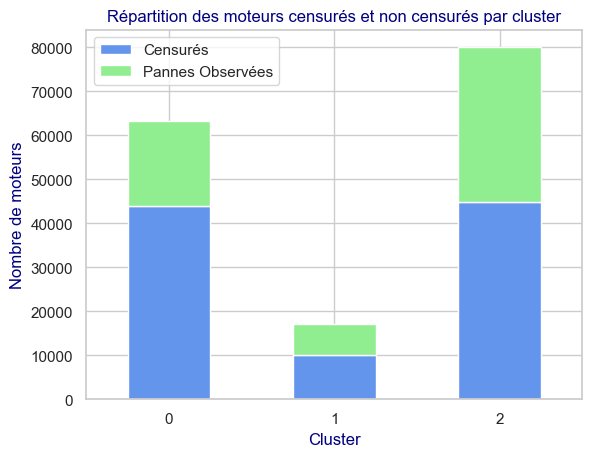

In [259]:
# compte le nombre de moteurs censurés et non censurés par cluster
censored_counts = train_data.groupby('cluster')['censored_weibull'].value_counts().unstack()

# afficher les données de censure par cluster
print("Répartition des moteurs censurés et non censurés par cluster :")
print(censored_counts)

# visualise la répartition des censures par cluster
censored_counts.plot(kind='bar', stacked=True, color=['cornflowerblue', 'lightgreen'])
plt.xlabel('Cluster', color= "navy")
plt.ylabel('Nombre de moteurs',  color= "navy")
plt.title('Répartition des moteurs censurés et non censurés par cluster',  color= "navy")
plt.xticks(rotation=0)
plt.legend(['Censurés', 'Pannes Observées'])
plt.show()


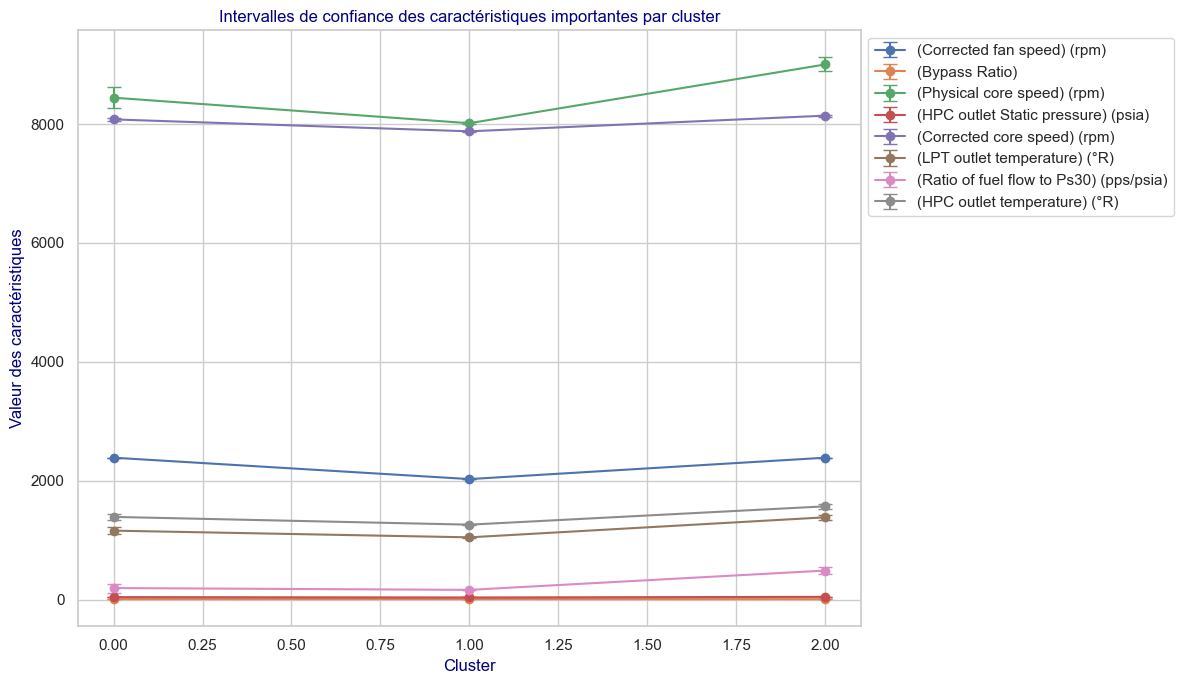

In [260]:
# calcule la moyenne et l'écart-type des caractéristiques importantes pour chaque cluster
means = train_data.groupby('cluster')[top_features].mean()
stds = train_data.groupby('cluster')[top_features].std()

# trace les intervalles de confiance pour les caractéristiques importantes
fig, ax = plt.subplots(figsize=(12, 7))
for feature in top_features: 
    x = means.index
    y = means[feature]
    yerr = stds[feature]
    ax.errorbar(x, y, yerr=yerr, label=feature, fmt='-o', capsize=5)

ax.set_xlabel('Cluster',  color= "navy")
ax.set_ylabel('Valeur des caractéristiques',  color= "navy")
ax.set_title('Intervalles de confiance des caractéristiques importantes par cluster',  color= "navy")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

L'analyse des clusters révèle une séparation globalement satisfaisante en trois groupes, avec une répartition non uniforme des moteurs. Le graphique de répartition indique que le cluster n° 2 est le plus important, regroupant environ 80 000 moteurs. Le cluster n° 0 en rassemble environ 60 000, tandis que le cluster n° 1 est nettement plus petit, avec près de 17 000 moteurs. Cette distribution suggère des différences notables entre les groupes.

Bien que non optimales, la heatmap des moyennes des caractéristiques par cluster révèle des variations plutôt significatives parmi les groupes. Par exemple, le cluster n° 2 se démarque par des valeurs plus élevées de la vitesse du cœur physique (« Physical core speed ») et de la pression statique de sortie du compresseur haute pression (« HPC outlet Static pressure »), ce qui semble indiquer que les moteurs de ce cluster sont soumis à des régimes de fonctionnement plus intenses. En revanche, la température de sortie de la turbine basse pression (« LPT outlet temperature ») est légèrement plus basse dans le cluster n° 1 que dans les clusters n° 0 et n° 2, suggérant des conditions thermiques plus modérées pour les moteurs de ce groupe. Le cluster n° 0 semble se distinhuer par une vitesse corrigée du ventilateur (« Corrected fan speed ») qui se situe à un niveau intermédiaire par rapport aux autres clusters. Ces observations suggèrent que chaque cluster représente des conditions opérationnelles uniques. 

Elle sont appuyées par le dernier graphique, représentant les intervalles de confiance des caractéristiques importantes par cluster, qui illustre la variabilité des caractéristiques pour chaque groupe. Les barres d'erreur montrent que certaines caractéristiques, comme la « Physical core speed » et la « Corrected fan speed », varient de manière significative entre les clusters, tandis que d'autres, comme la température de sortie de la turbine basse pression (« LPT outlet temperature »), présentent une variabilité plus modérée.

En examinant la répartition des événements observés par cluster, on constate que le cluster n° 2 présente une proportion relativement élevée de pannes observées (environ 35 000 sur 80 000 moteurs), ce qui pourrait indiquer que les moteurs de ce groupe sont plus susceptibles de subir des défaillances. Le cluster n° 0 affiche également une part notable de pannes, avec environ 19 000 pannes observées sur 60 000 moteurs, tandis que le cluster n° 1 présente le plus faible nombre d'événements observés (environ 7 000 pannes), reflétant peut-être des conditions de fonctionnement plus stables ou des moteurs moins exposés à des risques élevés.

### II.c. Stratégies de modélisation pour les données censurées contenant des évènements concurrents de différents types

#### II.c.1. Par un modèle Aalen-Johanson

Le modèle Aalen-Johansen permet d'estimer la probabilité de transition entre plusieurs événements concurrents, dans le cadre des processus de risques compétitifs. Contrairement au modèle de Cox Proportionnel des risques, qui se concentre principalement sur l'estimation des risques proportionnels pour un seul type d'événement, le modèle Aalen-Johansen est conçu pour gérer plusieurs types d'événements qui peuvent survenir de manière concurrente, tels que des défaillances multiples ou différentes causes de décès. Ce modèle repose sur une approche de type Kaplan-Meier adaptée aux situations avec événements multiples. Il permet d'estimer la fonction d'incidence cumulative (CIF) pour chaque type d'événement dans un contexte de risques compétitifs. 

Pour chaque durée observée $t_i$, on calcule le hazard spécifique pour l'événement $k$ en comptant le nombre d'événements de type $k$ qui se produisent à $t_i$ et le nombre d'individus toujours à risque à ce moment : $\hat{\lambda}_k(t_i) = \frac{d_{k,i}}{n_i}$, où $d_{k,i}$ est le nombre d'événements de type $k$ à $t_i$, et $ n_i$ est le nombre d'individus à risque à $t_i$.

On utilise l'estimateur de Kaplan-Meier pour calculer la probabilité de survie globale, en réutilisant les hazards spécifiques aux causes.
   $$
   \hat{S}(t) = \prod_{i : t_i \leq t} \left(1 - \frac{d_i}{n_i}\right) = \prod_{i : t_i \leq t} \left(1 - \sum_k \hat{\lambda}_k(t_i)\right)
   $$

La CIF pour l'événement $k$ est calculée comme la somme des hazards spécifiques à $k$, pondérée par les probabilités de survie globale jusqu'au temps $t_{i-1}$.
   $$
   \hat{F}_k(t) = \sum_{i : t_i \leq t} \hat{\lambda}_k(t_i) \hat{S}(t_{i-1})
   $$

Ainsi, le modèle Aalen-Johansen combine les hazards spécifiques aux causes avec la probabilité de survie globale pour obtenir une estimation robuste de l'incidence cumulative pour chaque type d'événement.

Attention : la somme des probabilités dépasse 1 à certains points dans le temps.


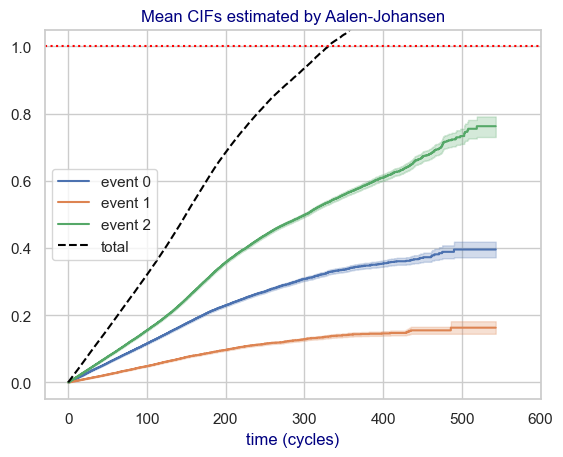

Concordance Index: 0.9980


In [258]:
from lifelines import AalenJohansenFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# crée un graphique
fig, ax = plt.subplots()

# initialise un dictionnaire pour stocker chaque CIF
cif_dict = {}

# identifie les types d'événements concurrents présents dans les données (clusters non censurés)
competing_risk_ids = sorted(train_data[train_data['censored_weibull'] == 1]['cluster'].unique())

# fonction pour ajuster le modèle Aalen-Johansen 
def fit_aj(event):
    print(f"Fitting Aalen-Johansen for event {event}...")
    ajf = AalenJohansenFitter(calculate_variance=True)
    
    # filtre les données pour les événements observés (pannes non censurées du cluster spécifique)
    filtered_data = train_data[(train_data['censored_weibull'] == 1) & (train_data['cluster'] == event)].copy()
    filtered_data['event_occurred'] = 1

    # ajoute les observations censurées pour ce cluster, avec 'event_occurred' à 0
    censored_data = train_data[train_data['censored_weibull'] == 0].copy()
    censored_data['event_occurred'] = 0

    # combine les deux jeux de données 
    data_for_fit = pd.concat([filtered_data, censored_data], ignore_index=True)

    # ajuste le modèle Aalen-Johansen
    ajf.fit(
        durations=data_for_fit["cycle"],
        event_observed=data_for_fit["event_occurred"],
        event_of_interest=1 
    )
    return ajf, event

# ajuste le modèle Aalen-Johansen en parallèle pour chaque événement concurrent
results = Parallel(n_jobs=12)(delayed(fit_aj)(event) for event in competing_risk_ids)

# crée une grille de temps commune pour toutes les courbes CIF
common_times = np.linspace(0, train_data["cycle"].max(), 1000)

# trace les courbes CIF pour chaque événement concurrent et interpoler sur les temps communs
for ajf, event in results:
    ajf.plot(ax=ax, label=f"event {event}")
    cif_df = ajf.cumulative_density_

    # interpole les valeurs de la CIF sur la grille de temps commune
    cif_times = cif_df.index.values
    cif_values = cif_df[cif_df.columns[0]].values
    interpolated_cif = np.interp(common_times, cif_times, cif_values)
    cif_dict[event] = interpolated_cif

# initialise un tableau de zéros pour la somme totale des probabilités sur la grille de temps commune
total_cif = np.zeros_like(common_times)

# calcule la somme des CIF pour chaque événement
for event, cif_values in cif_dict.items():
    total_cif += cif_values

# trace la courbe de la somme totale des CIF
ax.plot(common_times, total_cif, label="total", linestyle="--", color="black")

# s'assure que la somme des probabilités ne dépasse pas 1
if np.any(total_cif > 1):
    print("Attention : la somme des probabilités dépasse 1 à certains points dans le temps.")
    ax.axhline(1, color='red', linestyle=':')

# ajuste le titre et les labels des axes avec la couleur "navy"
ax.set(
    title="Mean CIFs estimated by Aalen-Johansen",
    xlabel="time (cycles)",
    xlim=(-30, 600),
    ylim=(-0.05, 1.05),
)
ax.title.set_color("navy")
ax.xaxis.label.set_color("navy")
ax.yaxis.label.set_color("navy")

plt.legend()
plt.show()

# colonnes du jeu de données qui correspondent aux temps d'événement, scores prédits, et indicateurs d'événement
event_times = train_data["cycle"] 
event_observed = train_data["censored_weibull"] 
predicted_scores = np.interp(event_times, common_times, total_cif)

# Calcul du C-index
c_index = concordance_index(event_times, predicted_scores, event_observed)
print(f"Concordance Index: {c_index:.4f}")

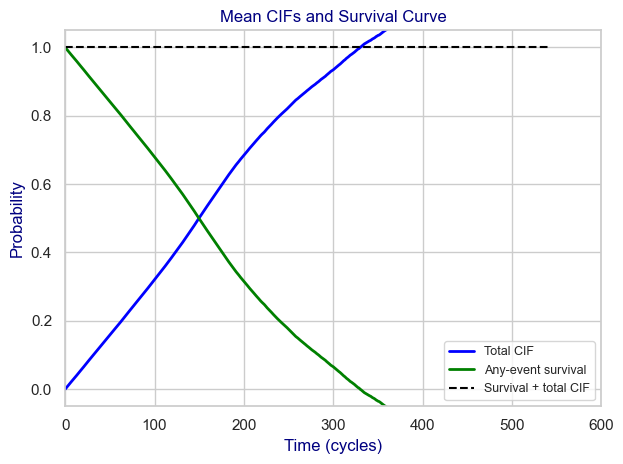

In [257]:
fig, ax = plt.subplots()

# utilise les courbes CIF obtenues avec Aalen-Johansen
# calcul de la probabilité de survie comme 1 moins la somme des CIFs
total_cif = np.zeros_like(common_times)

# additionne toutes les CIFs pour chaque type d'événement
for event, cif_values in cif_dict.items():
    total_cif += cif_values

# calcule la courbe de survie à partir de la somme des CIFs
mean_survival_curve = 1 - total_cif  


ax.plot(common_times, total_cif, label="Total CIF", color="blue", linewidth=2)
ax.plot(common_times, mean_survival_curve, label="Any-event survival", color="green", linewidth=2)
ax.plot(
    common_times,
    total_cif + mean_survival_curve,
    color="black",
    linestyle="--",
    label="Survival + total CIF",
    linewidth=1.5
)

ax.set(
    title="Mean CIFs and Survival Curve",
    xlabel="Time (cycles)",
    ylabel="Probability",
    xlim=(0, 600),
    ylim=(-0.05, 1.05)
)

ax.title.set_color("navy")
ax.xaxis.label.set_color("navy")
ax.yaxis.label.set_color("navy")

ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

Le premier graphique présente les fonctions d'incidence cumulées (CIF) estimées par le modèle Aalen-Johansen pour chaque type d'événement, distinguées par les différents clusters. Chaque courbe représente la probabilité cumulée qu'un moteur subisse un événement particulier (panne) au fil des cycles, en tenant compte de la concurrence entre les événements.

Chacune de ces courbes illustre l'évolution de la CIF pour un événement spécifique. Par exemple, la courbe verte atteint des valeurs plus élevées, suggérant que l'événement associé a une incidence cumulée plus importante comparée aux autres événements. En revanche, les courbes bleue et orange montrent des augmentations plus progressives, indiquant des probabilités plus faibles ou des événements survenant plus tard dans le temps. 
Le fait que les courbes présentent des comportements différents semble appuyer l'appartenance des moteurs à différents clusters qui ne sont pas soumis aux mêmes probabilités de transition vers un état de panne. Cela pourrait refléter des conditions opérationnelles variées, des différences de performance ou des facteurs spécifiques influençant chaque cluster.

L'estimation des CIFs semble globalement satisfaisante, avec des courbes qui suivent des trajectoires plausibles d'incidence cumulée. Cependant, un aspect notable est que la somme des probabilités dépasse 1 à partir d'un certain seuil. Cela indique une potentielle incohérence dans la modélisation des risques compétitifs, suggérant que certaines hypothèses du modèle ou des aspects des données pourraient nécessiter une vérification plus approfondie. Cela peut également souligner une limitation de l'estimation ou des biais introduits par la structure des données.

Le second graphique illustre la relation entre la probabilité de survie globale - probabilité de ne rencontrer aucun événement -, la CIF totale, et la somme de la probabilité de survie avec le total des CIFs. La courbe de survie (en vert) décroît au fil du temps, ce qui est attendu puisque la probabilité de survivre sans événement diminue. À l'inverse, la CIF totale augmente, reflétant la probabilité croissante de rencontrer au moins un des événements. Le croisement des courbes autour de 150 cycles montre que, passé ce point, il devient plus probable de rencontrer un événement que de survivre sans événement. Néanmoins, il est important de noter que la courbe bleue dépasse 1 à partir d'un certain seuil, ce qui suggère une surestimation de la probabilité cumulative.

#### II.c.2. Par un modèle de survie compétitive basé sur HistGradientBoostingClassifier et les clusters de caractéristiques importantes

Je n'ai malheureusement pas réussi à implémenter correctement le GrandiatBoostedCIF face à une erreur persistance - je me suis heurté à une résistance farouche a priori liée à la classe « IBSTrainingSampler » !. En alternative, ce second modèle propose d'implémenter une analyse de survie compétitive basée sur les fonctions d'incidences cumulatives (CIF), configurée pour évaluer la probabilité de survenue d’événements concurrents. Ce modèle s’appuie sur les clusters et les censures générés dans la phase de préparation des données du premier modèle, offrant ainsi une approche complète et supervisée de modélisation de survie.

La démarche propose d'entrainer le modèle HistGradientBoostingClassifier sur les caractéristiques importantes identifiées lors de la première étape de préparation des données, avec les clusters en tant que cible d’entraînement. En utilisant un classifieur supervisé, le modèle apprend à prédire les catégories de dégradation, permettant ainsi de modéliser la probabilité d’occurrence d’événements concurrents.

Les censures, définies par la loi de Weibull dans le premier modèle, fournissent également un cadre de référence pour interpréter les résultats. Bien que la variable de censure (censored_weibull) ne soit pas intégrée directement dans l’entraînement, elle est fondamentale pour la validation des prédictions. La censure indique en effet les cas où l’événement n’est pas observé, ce qui permet d’interpréter les probabilités de survie dans un contexte où certains événements restent non réalisés.

Une fois le modèle ajusté, les probabilités de survenue de chaque catégorie d’événement sont cumulées pour estimer les CIF au fil du temps. La courbe de survie globale est ensuite approximée par la relation suivante : $\hat{S}(t) \approx 1 - \sum_k \hat{CIF_k}(t)$, où $\hat{CIF_k}(t)$ représente la probabilité cumulative de survenue de l’événement concurrent de type $k$ au temps $t$. Cette formule permet ainsi de calculer la probabilité de survie restante en tenant compte des différents types d'événements concurrents, chacun contribuant à la probabilité d’échec cumulative.

Enfin, pour mieux comprendre l’impact des caractéristiques sur la survenue d’événements, le modèle utilise des Partial Dependence Plots (PDP) afin de visualiser l’influence de chaque covariable sur les probabilités des différentes classes d’événements. Les PDP pour les caractéristiques les plus importantes révèlent ainsi des tendances spécifiques pour chaque classe de dégradation, fournissant des informations utiles pour évaluer l’effet de chaque caractéristique dans le contexte de la survie compétitive.


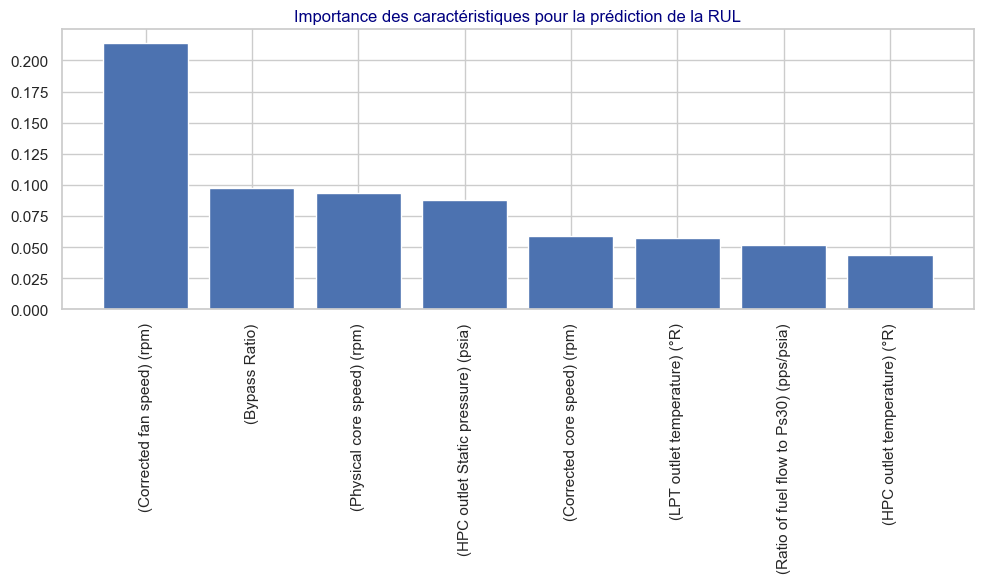

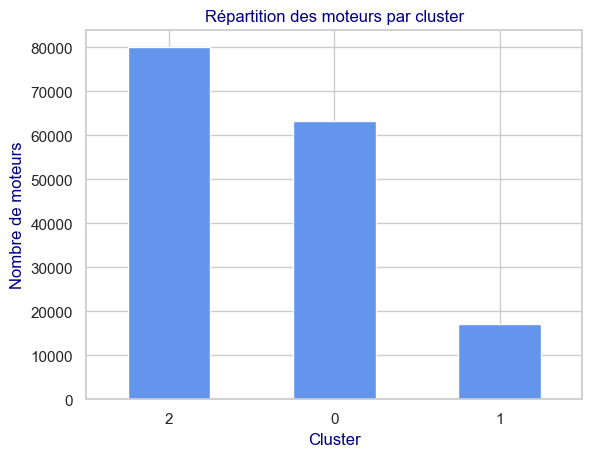

c-index pour HistGradientBoostingClassifier : 1.0000


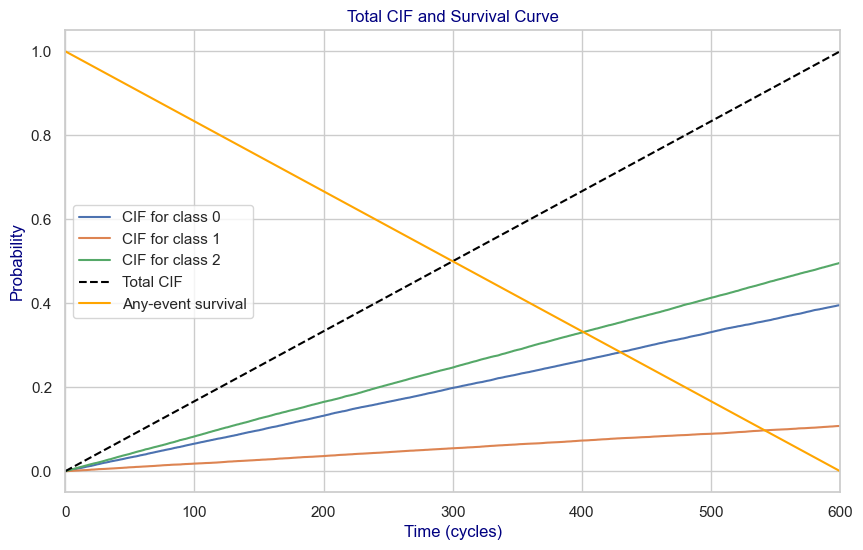

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 1re étape : identification des caractéristiques importantes avec Random Forest
features = [col for col in train_data.columns if col not in ['engine', 'cycle', 'RUL', 'censored_weibull']]
X = train_data[features]
y = train_data['RUL']

# entraîne RandomForestRegressor pour obtenir les 12 caractéristiques importantes
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=12)
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [features[i] for i in indices[:8]]

# visualisation de l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), importances[indices[:len(top_features)]], align='center')
plt.xticks(range(len(top_features)), np.array(top_features), rotation=90)
plt.title("Importance des caractéristiques pour la prédiction de la RUL", color="navy")
plt.tight_layout()
plt.show()

# 2e étape : création des clusters basés sur les caractéristiques importantes
scaled_top_features = StandardScaler().fit_transform(train_data[top_features])
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
train_data['cluster'] = kmeans.fit_predict(scaled_top_features)

# visualisation de la répartition des clusters
train_data['cluster'].value_counts().plot(kind='bar', color='cornflowerblue')
plt.xlabel('Cluster', color="navy")
plt.ylabel('Nombre de moteurs', color="navy")
plt.title('Répartition des moteurs par cluster', color="navy")
plt.xticks(rotation=0)
plt.show()

# 3e étape : divise les données en ensembles d'entraînement et de test
X_train, X_test, y_train_cr, y_test_cr = train_test_split(train_data[top_features], train_data['cluster'], test_size=0.2, random_state=42)

# 4e étape : entraîne HistGradientBoostingClassifier sur les données de clusters
gb_classifier = HistGradientBoostingClassifier(max_iter=100, max_depth=3, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train, y_train_cr)

# prédit les probabilités pour chaque classe dans X_test
y_pred_proba = gb_classifier.predict_proba(X_test)

# calcul du c-index pour le modèle HistGradientBoostingClassifier
y_pred_class = gb_classifier.predict(X_test)
c_index = roc_auc_score(y_test_cr, y_pred_proba, multi_class='ovr')
print(f"c-index pour HistGradientBoostingClassifier : {c_index:.4f}")

# crée une grille de temps de 0 à 600 cycles
time_grid = np.linspace(0, 600, len(y_pred_proba))

# calcul des CIF
cif_curves = np.cumsum(y_pred_proba, axis=0) / len(y_pred_proba)

# calcul de la courbe de survie
survival_curve = 1 - cif_curves.sum(axis=1)

# trace les courbes CIF, survie et la somme des deux
fig, ax = plt.subplots(figsize=(10, 6))
total_mean_cif = np.zeros_like(time_grid)
for i in range(cif_curves.shape[1]):
    mean_cif_curve = cif_curves[:, i]
    ax.plot(time_grid, mean_cif_curve, label=f"CIF for class {i}", linestyle="-")
    total_mean_cif += mean_cif_curve
ax.plot(time_grid, total_mean_cif, label="Total CIF", linestyle="--", color="black")
ax.plot(time_grid, survival_curve, label="Any-event survival", color="orange")
ax.set(
    title="Total CIF and Survival Curve", 
    xlabel="Time (cycles)", 
    ylabel="Probability", 
    xlim=(0, 600),
    ylim=(-0.05, 1.05)
)

ax.title.set_color("navy")
ax.xaxis.label.set_color("navy")
ax.yaxis.label.set_color("navy")

ax.legend()
plt.show()

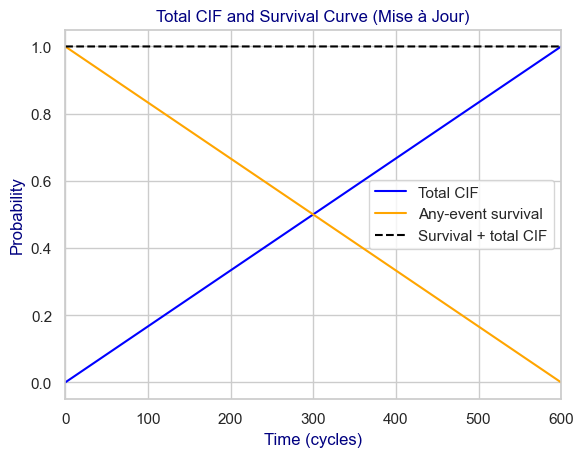

In [231]:
# obtient les prédictions de probabilité pour chaque classe
y_pred_proba = gb_classifier.predict_proba(X_test)

# crée une grille de temps de 0 à 600 cycles
time_grid = np.linspace(0, 600, len(y_pred_proba))

# calcul des CIF 
cif_curves = np.cumsum(y_pred_proba, axis=0) / len(y_pred_proba)

# calcul de la courbe de survie
survival_curve = 1 - cif_curves.sum(axis=1)

# trace les courbes CIF, survie et la somme des deux
fig, ax = plt.subplots()
mean_survival_curve = survival_curve
ax.plot(time_grid, cif_curves.sum(axis=1), label="Total CIF", color="blue")
ax.plot(time_grid, mean_survival_curve, label="Any-event survival", color="orange")
ax.plot(
    time_grid,
    cif_curves.sum(axis=1) + mean_survival_curve,
    color="black",
    linestyle="--",
    label="Survival + total CIF",
)
ax.legend()

ax.set_title("Total CIF and Survival Curve (Mise à Jour)", color="navy")
ax.set_xlabel("Time (cycles)", color="navy")
ax.set_ylabel("Probability", color="navy")

ax.set_xlim(0, 600)
ax.set_ylim(-0.05, 1.05)
plt.show()

Le premier graphique montre l’importance des différentes caractéristiques dans la prédiction de la durée de vie restante (RUL) des moteurs, telle que calculée par le modèle RandomForest. La vitesse corrigée du ventilateur (« Corrected fan speed ») se démarque comme la variable la plus influente, avec une importance bien supérieure aux autres. D'autres caractéristiques significatives incluent le rapport de dérivation (« Bypass Ratio »), la pression statique de sortie du compresseur haute pression (« HPC outlet Static pressure »), et la vitesse du cœur physique (« Physical core speed »). Cette hiérarchisation des variables souligne des facteurs essentiels qui influencent la dégradation des moteurs.

Le deuxième graphique illustre la répartition des moteurs en trois clusters, créés sur la base des caractéristiques les plus importantes. Ces clusters, bien que générés avec une méthode supervisée, sont en partie dérivés des regroupements identifiés initialement avec KMeans, ce qui permet de capitaliser sur la segmentation descriptive initiale. Le cluster n° 2 regroupe environ 80 000 moteurs, indiquant un nombre significativement plus élevé que les clusters n° 0 et n° 1, qui comptent respectivement 60 000 et 20 000 moteurs. Cette segmentation reflète des groupes de moteurs aux comportements de dégradation distincts.

Le troisième graphique présente les courbes de survie et les fonctions d’incidence cumulée pour chaque type d’événement, ainsi que la CIF totale et la courbe de survie globale. La courbe de survie (en orange) décroît avec le temps, indiquant la probabilité décroissante qu’aucun événement ne survienne. Parallèlement, les CIF pour chaque cluster augmentent progressivement, avec des différences marquées entre les événements. Par exemple, le cluster n° 2 montre une incidence cumulative plus rapide et élevée par rapport aux autres, suggérant un risque de défaillance plus important pour ce groupe. La courbe en pointillés noirs, représentant la somme des CIF et de la probabilité de survie, reste cohérente, indiquant une modélisation globalement satisfaisante des événements concurrents.

Le dernier graphique fournit un aperçu de la dynamique des probabilités d'événements sur une période de 600 cycles. La courbe représentant la CIF totale augmente de manière linéaire, indiquant une probabilité cumulée croissante de rencontrer au moins un des événements au fil du temps. En revanche, la courbe de la probabilité de survie décroît de manière symétrique, reflétant la diminution de la probabilité de ne rencontrer aucun événement. La ligne noire en pointillés, qui représente la somme de la probabilité de survie et de la CIF totale, reste stable à 1 tout au long de la période. Cela suggère une modélisation cohérente de la relation entre les risques d’événements et la survie globale.

À condition qu'il n'existe pas d'erreur d'implémentation, les résultats des modèles montrent une performance significative dans la prédiction des événements de survie. Le modèle d'Aalen-Johansen atteint un Concordance Index de 0,9980, ce qui suppose une excellente capacité à discriminer correctement les événements de survie en tenant compte des risques compétitifs. Cependant, le modèle HistGradientBoostingClassifier se distingue avec un Concordance Index de 1 à partir d'un certain seuil, suggérant une discrimination - théoriquement - parfaite entre les événements. En outre, sa capacité à produire des courbes de survie et de CIF qui respectent la somme des probabilités, sans dépasser 1, suggère une plus grande cohérence et une meilleure exploitation des caractéristiques pertinentes identifiées par la forêt aléatoire. En comparaison, le modèle Aalen-Johansen a présenté des incohérences, notamment avec des sommes de probabilités qui dépassaient 1. Cela suggère une adaptation légèrement meilleure du modèle basé sur HistGradientBoostingClassifier pour le cas étudié.


Caractéristiques sélectionnées après HistGradientBoostingClassifier : ['(Bypass Ratio)', '(HPC outlet Static pressure) (psia)', '(Corrected fan speed) (rpm)', '(Corrected core speed) (rpm)', '(HPC outlet temperature) (°R)', '(LPT outlet temperature) (°R)', '(Physical core speed) (rpm)', '(Ratio of fuel flow to Ps30) (pps/psia)']


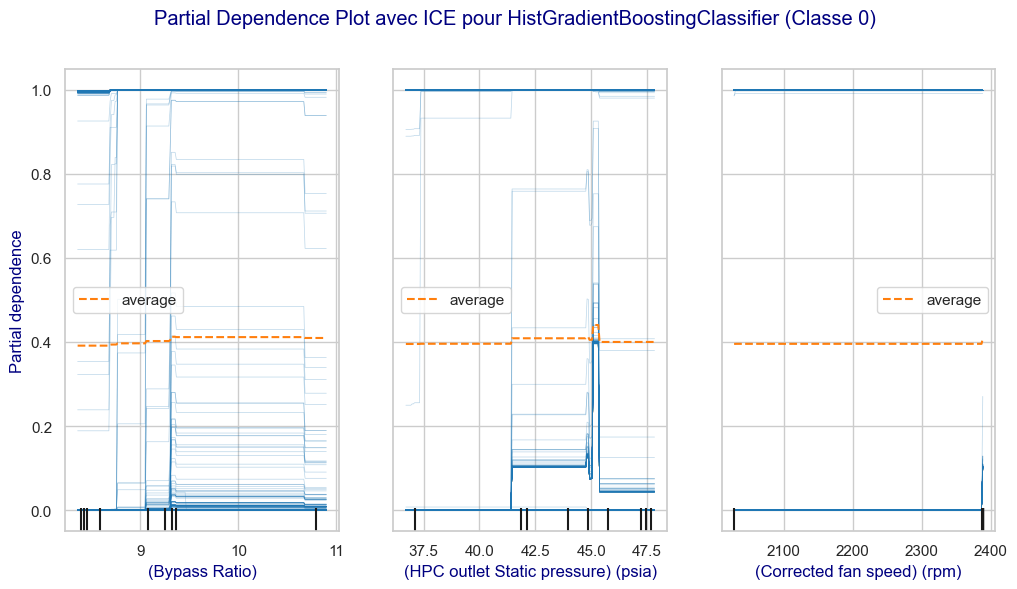

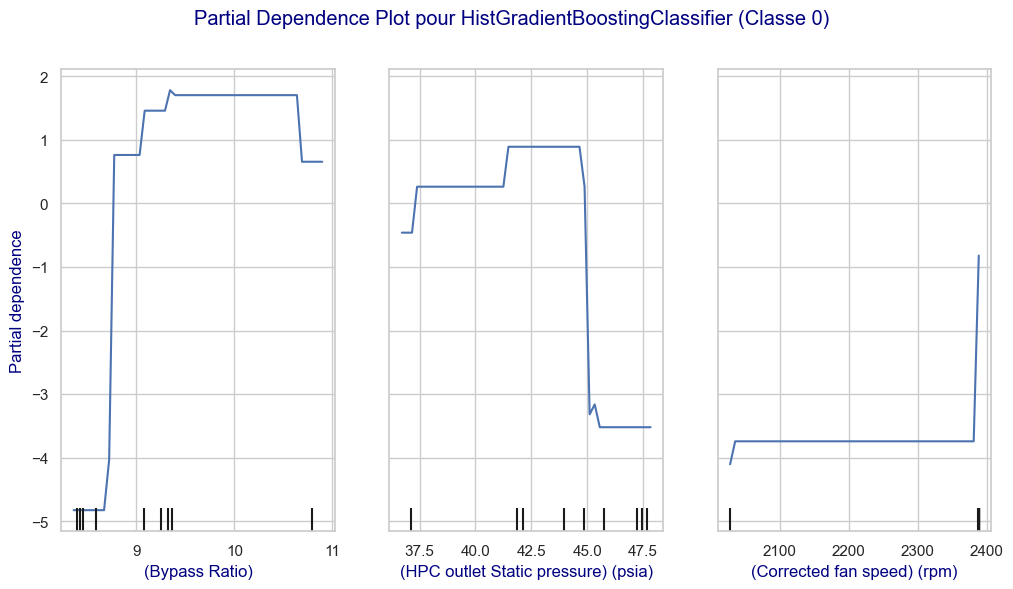

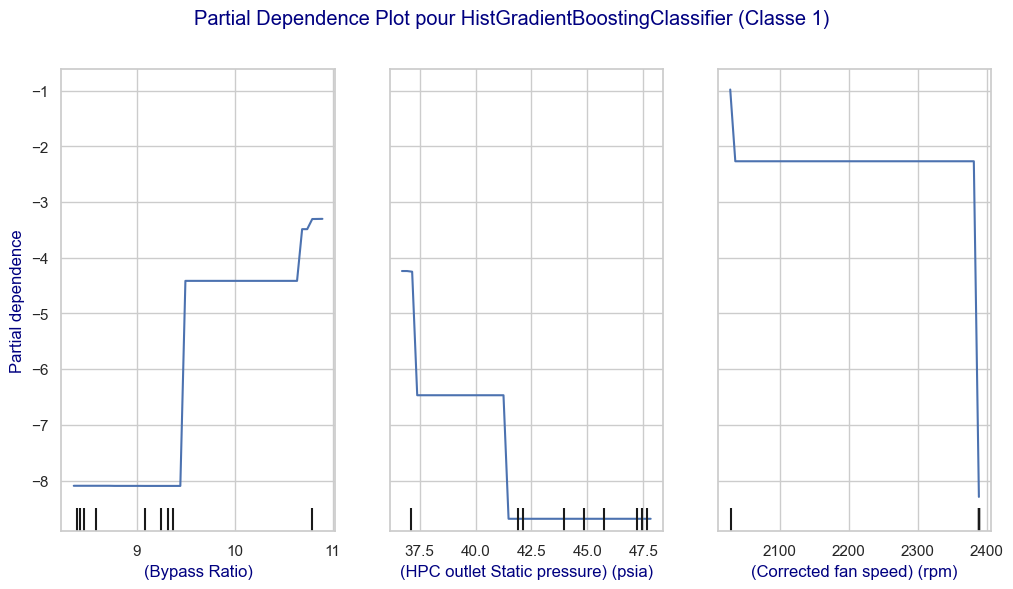

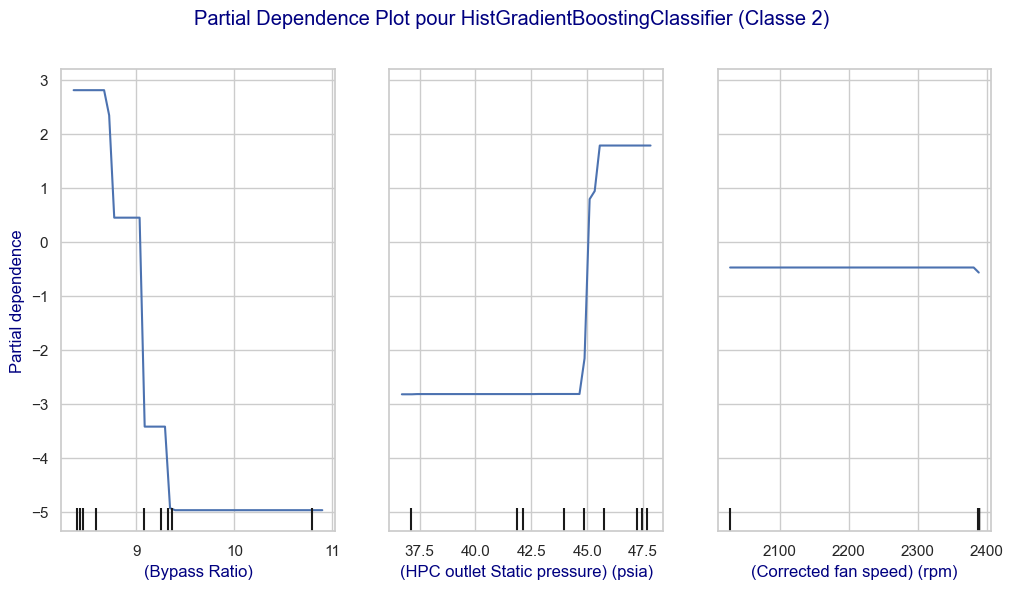

In [227]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import numpy as np

# calcule l'importance des caractéristiques par permutation
perm_importance = permutation_importance(gb_classifier, X_test, y_test_cr, n_repeats=10, random_state=42)
perm_importances = perm_importance.importances_mean

# trie les indices des caractéristiques par ordre d'importance décroissante
indices = np.argsort(perm_importances)[::-1]
print("Caractéristiques sélectionnées après HistGradientBoostingClassifier :", [top_features[i] for i in indices])

# affiche les PDP pour les trois caractéristiques les plus importantes après permutation importance
fig, ax = plt.subplots(figsize=(12, 6))
display = PartialDependenceDisplay.from_estimator(
    gb_classifier,
    X_test,
    features=[indices[0], indices[1], indices[2]],  
    feature_names=top_features,
    target=0,  
    ax=ax,
    kind='both',  
    grid_resolution=200
)
plt.suptitle("Partial Dependence Plot avec ICE pour HistGradientBoostingClassifier (Classe 0)", color="navy")

for ax_ in display.axes_.ravel():
    ax_.set_xlabel(ax_.get_xlabel(), color="navy")
    ax_.set_ylabel(ax_.get_ylabel(), color="navy")

plt.show()

# affichage des PDP pour chaque classe cible
for target_class in gb_classifier.classes_:
    fig, ax = plt.subplots(figsize=(12, 6))
    display = PartialDependenceDisplay.from_estimator(
        gb_classifier,
        X_test,
        features=[indices[0], indices[1], indices[2]],  
        feature_names=top_features,
        target=target_class,
        ax=ax,
        grid_resolution=50
    )
    plt.suptitle(f"Partial Dependence Plot pour HistGradientBoostingClassifier (Classe {target_class})", color="navy")

    for ax_ in display.axes_.ravel():
        ax_.set_xlabel(ax_.get_xlabel(), color="navy")
        ax_.set_ylabel(ax_.get_ylabel(), color="navy")

    plt.show()

Pour finir, notons que ce type de modèles permet d’explorer de manière détaillée l’influence des caractéristiques sur le risque de panne, tout en tenant compte des interactions complexes et non linéaires présentes dans les données. Ainsi, les résultats obtenus à l’aide des *Partial Dependence Plots* (PDP) et des *Individual Conditional Expectation* (ICE) pour le classifieur HistGradientBoostingClassifier apportent une compréhension plus fine de l’impact des caractéristiques sur la probabilité de panne des moteurs. Les caractéristiques qui ressortent comme ayant une influence majeure sont le « Bypass Ratio », la pression statique à la sortie du compresseur haute pression (« HPC outlet static pressure »), et la vitesse corrigée du ventilateur (« Corrected fan speed »).

Les analyses montrent des effets distincts pour chaque caractéristique selon la classe d'événements. Le « Bypass Ratio » présente des variations notables : pour la classe n° 0, les courbes PDP révèlent une augmentation de la probabilité de panne en augmentant le « Bypass Ratio », avant d'atteindre une certaine stabilisation. En revanche, pour la classe n° 2, une baisse marquée de la dépendance est observée lorsque le ratio descend en dessous de 9, suggérant un seuil critique. Ce comportement met en évidence l'importance de maintenir le « Bypass Ratio » dans des plages optimales pour éviter les défaillances.

La pression statique HPC influence également de manière significative les résultats. Un effet de seuil semble particulièrement marqué pour la classe n° 1, où une chute abrupte de la probabilité de panne se produit autour de 42,5 psia. À l'inverse, pour la classe n° 2, une augmentation rapide de la dépendance est constatée à des valeurs supérieures à 45 psia.

La vitesse corrigée du ventilateur montre des effets plus subtils. Pour la classe n° 0, l’influence devient significative aux valeurs extrêmes de la vitesse, avec une augmentation de la probabilité de panne. La classe n° 1 est marquée par une tendance inverse, avec un risque de panne qui chute fortement à partir de 2400 rpm, marquant un point critique, alors que la classe n° 2 ne semble pas influencée par cette variable. 

Il est également possible de croiser les influences des différentes caractéristiques au sein d'une même classe. Par exemple, un point intéressant à souligner est la tendance inverse observée pour les deux premières caractéristiques entre les classes n° 1 et n° 2. Ces tendances inverses suggèrent que les moteurs des deux classes pourraient fonctionner dans des régimes distincts ou avoir des vulnérabilités spécifiques, nécessitant des attentions au risque de panne différenciées.

Ces observations mettent en évidence la complexité de certaines relations non linéaires entre ces caractéristiques et le comportement des moteurs.

L'approche ICE combinée aux PDP apporte une nuance supplémentaire. Tandis que les PDP révèlent des tendances globales en montrant l'effet moyen de chaque caractéristique sur la probabilité de panne, l'approche ICE dévoile la variabilité individuelle des moteurs. Cela permet de distinguer les réponses spécifiques qui pourraient s’écarter de la tendance générale, et d’identifier des particularités - dans le cas étudié, des moteurs avec des comportements particuliers ou sensibles. Par exemple, bien que la tendance générale pour la classe n° 0 montre une faible sensibilité au « Bypass Ratio » autour de 9, certaines courbes ICE indiquent que des moteurs spécifiques voient leur probabilité de panne augmenter ou diminuer de manière significative dans cette plage. Cela suggère que certaines configurations individuelles des moteurs peuvent réagir de façon imprévisible à de légères variations du ratio, ce qui pourrait nécessiter une gestion plus précise.

## III. Documents de références

[1] Simon Quantin, « Méthodologie statistique, M 2018/02, Modèles semi-paramétriques de survie en temps continu sous R », INSEE, 2018. Lien internet : https://www.insee.fr/fr/statistiques/3695681 

[2] Philippe Saint Pierre, « Introduction à l'analyse des durées de survie », Institut de Mathématiques de Toulouse, Université Paul Sabatier - Toulouse III, avril 2021. Lien internet : https://perso.math.univ-toulouse.fr/psaintpi/files/2021/04/Cours_Survie_2.pdf

[3] A. Saxena, K. Goebel, D. Simon, et N. Eklund, « NASA Turbofan Jet Engine Data Set, Run to Failure Degradation Simulation », 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008. Lien internet : https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
